# Imports

In [1]:
import commons

# Plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# OS
import os
import platform
import sys

# Data
import random
import numpy as np
import pandas as pd

# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# import tensorflow_hub as hub
#import tensorflow_model_analysis as tfma


/Users/tacocat/anaconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def verify_gpu_m1():
    # import os
    # import platform
    # import sys
    
    # import numpy as np
    # import pandas as pd
    # import tensorflow as tf
    # from tensorflow import keras
  
    result = pd.DataFrame(columns=['library', 'version'])
    result.loc[0] = ['Platform', platform.platform()]
    result.loc[1] = ['TensorFlow', tf.__version__]
    result.loc[2] = ['Python', str(sys.version).split(' ')[0]]
    #result.loc[3] = ['Keras', tf.keras.__version__]
    result.loc[3] = ['Pandas', pd.__version__]
    #result.loc[] = ['SkLearn', sk.__version__]
    #result.loc[] = ['SciPy', sp.__version__]
    result.loc[4] = ['Metal GPU Access', 
                     len(tf.config.list_physical_devices('GPU')) > 0]
    return result

# Set Globals

In [3]:
PROJECT_ROOT = os.getcwd()

In [4]:
def prepdata(train_dir, valid_dir, test_dir, GLOBAL_CONFIG):
    tf.random.set_seed(GLOBAL_CONFIG['RANDOM_SEED'])
    print('Preparing dataset')
    
    #Override:
    GLOBAL_CONFIG['DIMS'] = (224, 224)
    GLOBAL_CONFIG['INPUT_SHAPE'] = (224, 224, 3)
    
    # Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
    train_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    print('Dimensions:', GLOBAL_CONFIG['DIMS'], '\n')

    # Import data from directories and turn it into batches
    print("\nTraining images:")
    train_data = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'], # number of images to process at a time 
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical", # type of problem we're working on
                                                   seed=GLOBAL_CONFIG['RANDOM_SEED'],
                                                   shuffle=True,
                                                   classes=GLOBAL_CONFIG['CLASSES'],
                                                   )
    print("Validation images:")
    valid_data = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'],
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical",
                                                   seed=GLOBAL_CONFIG['RANDOM_SEED'],
                                                   shuffle=True,
                                                   classes=GLOBAL_CONFIG['CLASSES'])
    
    print("Test images:")
    test_data = test_datagen.flow_from_directory(test_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'],
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical",
                                                   shuffle=False,
                                                   classes=GLOBAL_CONFIG['CLASSES'])
    
    GLOBAL_CONFIG['CLASSES'] = train_data.num_classes
    test_data_indices = test_data.class_indices
    
    print('Prepartaion complete')
    return train_data, valid_data, test_data, test_data_indices, GLOBAL_CONFIG

In [5]:
def configure_notebook(TARGET):
    print(verify_gpu_m1())
    
    if TARGET == 'mood':
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_moodtheme.tsv')
    else:
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_genre.tsv')

    tracks, tags, extra = commons.read_file(autotagging)
    head = list(tags.keys())[0]
    classes = tags[head].keys()
    CLASSES = list(classes)
    print(CLASSES)
    print('\npwd:',os.getcwd())
    TRAIN_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'train')
    VALID_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'valid')
    TEST_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test')
    
    GLOBAL_CONFIG = {'SCALING_FACTOR': 1,
                     'INPUT_SHAPE': None,
                     'DIMS': None,
                     'BATCH_SIZE': 32,
                     'CLASSES': CLASSES,
                     'MODEL_DIR': os.path.join(PROJECT_ROOT, 'models_'+TARGET),
                     'RANDOM_SEED': 42,
                     'LEARNING_RATE': 0.0001,
                     'EPOCHS': 100,
                     'TOP_K': 4,
                     'METRICS': ['accuracy',
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=4 ,name='top_4_accuracy'),
                                 tf.keras.metrics.AUC(multi_label=False, name='ROC-AUC'),
                                 tf.keras.metrics.AUC(curve='PR', name='PR-AUC'),
                                 tf.keras.metrics.TruePositives(name='tp'),
                                 tf.keras.metrics.FalsePositives(name='fp'),
                                 tf.keras.metrics.TrueNegatives(name='tn'),
                                 tf.keras.metrics.FalseNegatives(name='fn'), 
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 tfa.metrics.F1Score(average='macro', num_classes=len(CLASSES))
                                 #tf.keras.metrics.F1Score(threshold=None, average='macro', name='macro_f1')
                                 #tf.keras.metrics.F1Score(threshold=None, average='micro', name='micro_f1')
                                ]
                    }

    tf.random.set_seed(GLOBAL_CONFIG['RANDOM_SEED'])
    np.random.seed(GLOBAL_CONFIG['RANDOM_SEED'])
    print('Target:', TARGET)
    
    train_data, valid_data, test_data, test_data_indices, GLOBAL_CONFIG  = prepdata(TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG)
    
    DATA = {
        'train': train_data,
        'valid': valid_data,
        'test': test_data,
        'test_indices': test_data_indices
    }
    
    return TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG, DATA, CLASSES


In [6]:
TARGET = 'mood'
TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG, DATA, CLASSES = configure_notebook(TARGET)

            library                     version
0          Platform  macOS-14.0-arm64-arm-64bit
1        TensorFlow                      2.13.0
2            Python                     3.10.11
3            Pandas                       1.5.3
4  Metal GPU Access                        True
Reading: 18486 tracks, 4506 albums, 1533 artists
['background', 'film', 'melancholic', 'calm', 'melodic', 'children', 'relaxing', 'meditative', 'cool', 'documentary', 'emotional', 'space', 'love', 'drama', 'adventure', 'heavy', 'dark', 'soft', 'energetic', 'retro', 'ballad', 'advertising', 'epic', 'action', 'dramatic', 'powerful', 'upbeat', 'inspiring', 'uplifting', 'soundscape', 'slow', 'deep', 'fun', 'horror', 'nature', 'funny', 'happy', 'positive', 'sad', 'summer', 'dream', 'romantic', 'hopeful', 'mellow', 'motivational', 'party', 'groovy', 'corporate', 'sport', 'travel', 'sexy', 'movie', 'fast', 'commercial', 'holiday', 'ambiental', 'christmas', 'game', 'trailer']

pwd: /Volumes/Files/Syncthing/MA98

# Helper Functions

In [10]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    top4 = history.history['top_4_accuracy']
    val_accuracy = history.history['val_top_4_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    
    # Plot top 4
    plt.figure()
    plt.plot(epochs, accuracy, label='top4_accuracy')
    plt.plot(epochs, val_accuracy, label='val_top4_accuracy')
    plt.title('Top 4 Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [11]:
def plot_metrics(history):
  metrics = ['loss', 'PR-AUC', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [7]:
def load_and_prep_image(filename):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    img_shape = GLOBAL_CONFIG['DIMS']
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [224, 224])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    #img = tf.expand_dims(img, axis=0)  
    return img

In [13]:
def make_random_prediction(model, TARGET):
    if TARGET == 'mood':
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_moodtheme.tsv')
    else:
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_genre.tsv')

    tracks, tags, extra = commons.read_file(autotagging)
    head = list(tags.keys())[0]
    classes = tags[head].keys()
    CLASSES = list(classes)
    
    #random_class = random.choice(list(os.listdir(os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test'))))
    random_class = random.choice(CLASSES)
    current_dir = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test', random_class)
    track_list = list(os.listdir(current_dir))
    random_track = random.choice(track_list)
    current_dir = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test', random_class, random_track)
    #print(current_dir)
    
    result = pd.DataFrame(columns=['class_name', 'prob'])
    
    image = load_and_prep_image(current_dir)
    predictions = model.predict(tf.expand_dims(image, axis=0))
    #results['index'] = list(test_data_indices.values())
    #results['class_name'] = list(test_data_indices.keys())
    #results['prob'] = list(predictions[0])
    
    index = 0
    for c in CLASSES:
        result.loc[index] = [c, predictions[0][DATA['test_indices'][c]]]
        index += 1
    
    print('Track info:\n', tracks[int(random_track.split('.')[0])])
    result = result.sort_values(by=['prob'], ascending=False).head(4)
    preds = list()
    if TARGET == 'mood':
        actual = tracks[int(random_track.split('.')[0])]['mood/theme']
    else:
        actual = tracks[int(random_track.split('.')[0])]['genre']
    
    for name in result['class_name']:
        preds.append(name)
    
    plt.imshow(image)
    plt.title("Predictions: {0}\nActual: {1}\nCommon: {2}\nTrack: {3}".format(preds, 
                                                             actual,
                                                             set(preds).intersection(actual),
                                                             str(random_track).split('.')[0]))
    plt.axis(False);
    
    return result
    
    

In [15]:
DATA['test_indices']

{'background': 0,
 'film': 1,
 'melancholic': 2,
 'calm': 3,
 'melodic': 4,
 'children': 5,
 'relaxing': 6,
 'meditative': 7,
 'cool': 8,
 'documentary': 9,
 'emotional': 10,
 'space': 11,
 'love': 12,
 'drama': 13,
 'adventure': 14,
 'heavy': 15,
 'dark': 16,
 'soft': 17,
 'energetic': 18,
 'retro': 19,
 'ballad': 20,
 'advertising': 21,
 'epic': 22,
 'action': 23,
 'dramatic': 24,
 'powerful': 25,
 'upbeat': 26,
 'inspiring': 27,
 'uplifting': 28,
 'soundscape': 29,
 'slow': 30,
 'deep': 31,
 'fun': 32,
 'horror': 33,
 'nature': 34,
 'funny': 35,
 'happy': 36,
 'positive': 37,
 'sad': 38,
 'summer': 39,
 'dream': 40,
 'romantic': 41,
 'hopeful': 42,
 'mellow': 43,
 'motivational': 44,
 'party': 45,
 'groovy': 46,
 'corporate': 47,
 'sport': 48,
 'travel': 49,
 'sexy': 50,
 'movie': 51,
 'fast': 52,
 'commercial': 53,
 'holiday': 54,
 'ambiental': 55,
 'christmas': 56,
 'game': 57,
 'trailer': 58}

In [15]:
def test_best_model(config):
    model = tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 'models_mood', config['NAME']+'_checkpoints', 'cp.ckpt'))
    print('TEST:\n',model.evaluate(DATA['test']))

# Callbacks

In [16]:
def init_callbacks(config):
    checkpoint_path = os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']+'_checkpoints', 'cp.ckpt') # saving weights requires ".ckpt" extension

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                      patience=3,
                                                      verbose=1) # if val loss decreases for 3 epochs in a row, stop training

    # Create ModelCheckpoint callback to save best model during fine-tuning
    #checkpoint_path = "fine_tune_checkpoints/"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_best_only=True,
                                                          monitor="val_loss")

    # Create learning rate reduction callback
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                     factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                     patience=2,
                                                     verbose=1, # print when learning rate goes down 
                                                     min_lr=1e-7)
    return early_stopping, model_checkpoint, reduce_learning_rate

# Fine-tuning

In [17]:
# Only use in case of transfer learning.
def fine_tune(config):
    model = tf.keras.models.load_model(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']))
    for layer in model.layers:
        layer.trainable = True # all layers
    model.compile(loss=tf.keras.losses.categorical_crossentropy, # one-hot!!!
                        optimizer=tf.keras.optimizers.legacy.Adam(0.0001), # lowered by 10x
                        metrics=GLOBAL_CONFIG['METRICS'])
    print(model.summary())
    plot_model(model, to_file=os.path.join('model_img', config['NAME']+'_1.png'),
               show_layer_activations=True, 
               show_shapes=True,
               show_dtype=True, 
               show_layer_names=True, 
               expand_nested=True)
    early_stopping, model_checkpoint, reduce_learning_rate = init_callbacks(config)
    history = model.fit(DATA['train'],
                        epochs=GLOBAL_CONFIG['EPOCHS'], # fine-tune for a max of 100 epochs
                        steps_per_epoch=len(DATA['train']),
                        validation_data=DATA['valid'],
                        #validation_steps=int(0.15 * len(valid_data)), # validation during training on 15% of test data
                        callbacks=[
                        # create_tensorboard_callback("training_logs", "efnb0_2"), # track the model training logs
                        model_checkpoint, # save only the best model during training
                        early_stopping, # stop model after X epochs of no improvements
                        reduce_learning_rate
                        ]) # reduce the learning rate after X epochs of no improvements
    model.save(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']+'_FT'))
    print('VALID:\n',model.evaluate(DATA['valid']))
    print('TEST:\n',model.evaluate(DATA['test']))
    try:
        plot_loss_curves(history)
        with open(os.path.join(PROJECT_ROOT, 'history', config['NAME']+'_'+TARGET+'_FT'), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    except:
        print('No plots')
    return history
    

# Build and fit

In [18]:
def build_fit(model, config):
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=GLOBAL_CONFIG['LEARNING_RATE']),
                  metrics=GLOBAL_CONFIG['METRICS'])
    #tf.get_logger().setLevel('ERROR') # Only show errors
    print(model.summary())
    early_stopping, model_checkpoint, reduce_learning_rate = init_callbacks(config)
    plot_model(model, to_file=os.path.join('model_img', config['NAME']+'_1.png'),
               show_layer_activations=True, 
               show_shapes=True,
               show_dtype=True, 
               show_layer_names=True, 
               expand_nested=True)
    history = model.fit(DATA['train'],
                        epochs=GLOBAL_CONFIG['EPOCHS'],
                        steps_per_epoch=len(DATA['train']),
                        validation_data=DATA['valid'],
                        callbacks=[early_stopping, 
                                   model_checkpoint])
    
    model.save(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']))
    print('VALID:\n',model.evaluate(DATA['valid']))
    print('TEST:\n',model.evaluate(DATA['test']))
    try:
        plot_loss_curves(history)
        with open(os.path.join(PROJECT_ROOT, 'history', config['NAME']+'_'+TARGET), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    except:
        print('No plots')
    return history

# Models

In [19]:
def vgg19(config):
    base_model = tf.keras.applications.VGG19(include_top=False, 
                                             weights=config['WEIGHTS'], 
                                             # input_shape=GLOBAL_CONFIG['INPUT_SHAPE'],
                                             pooling='max')
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    inputs = layers.Input(GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.vgg19.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    # x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)

    return build_fit(model, config)

In [20]:
def effnet(config):
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, 
                                                        weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

In [21]:
def xception(config):
    base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                         weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.xception.preprocess_input(inputs)
    # x = layers.Rescaling(1./255)(x)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

In [22]:
def densenet(config):
    base_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

# Configs

In [12]:
vgg19_1_config = {'NAME': 'VGG19_1_TL',
                  'WEIGHTS': 'imagenet',
                  'TRANSFER_LEARNING': True
                  }
vgg19_2_config = {'NAME': 'VGG19_2',
                  'WEIGHTS': None,
                  'TRANSFER_LEARNING': False
                 }


effnet_1_config = {'NAME': 'EfficientNetV2B0_1_TL',            
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True,
                   }
effnet_2_config = {'NAME': 'EfficientNetV2B0_2',
                    'WEIGHTS': None,
                    'TRANSFER_LEARNING': False
                   }


xception_1_config = {'NAME': 'Xception_1_TL',
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True
                    }
xception_2_config = {'NAME': 'Xception_2',
                     'WEIGHTS': None,
                     'TRANSFER_LEARNING': False
                    }

densenet_1_config = {'NAME': 'densenet201_1_TL2',
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True
                    }
densenet_2_config = {'NAME': 'densenet201_2',
                     'WEIGHTS': None,
                     'TRANSFER_LEARNING': False
                    }




# Mood | Models

## Mood | VGG19

### Mood | VGG19 | Transfer Learning

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 344ms/step - loss: 3.8570 - accuracy: 0.0506 - top_2_accuracy: 0.0935 - top_3_accuracy: 0.1353 - top_4_accuracy: 0.1741 - ROC-AUC: 0.6964 - PR-AUC: 0.0341 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0064 - val_loss: 3.7426 - val_accuracy: 0.0623 - val_top_2_accuracy: 0.1070 - val_top_3_accuracy: 0.1595 - val_top_4_accuracy: 0.2045 - val_ROC-AUC: 0.7287 - val_PR-AUC: 0.0416 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0046
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.7369 - accuracy: 0.0642 - top_2_accuracy: 0.1147 - top_3_accuracy: 0.1593 - top_4_accuracy: 0.2042 - ROC-AUC: 0.7301 - PR-AUC: 0.0420 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.7369 - accuracy: 0.0642 - top_2_accuracy: 0.1147 - top_3_accuracy: 0.1593 - top_4_accuracy: 0.2042 - ROC-AUC: 0.7301 - PR-AUC: 0.0420 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0072 - val_loss: 3.7244 - val_accuracy: 0.0640 - val_top_2_accuracy: 0.1173 - val_top_3_accuracy: 0.1688 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7333 - val_PR-AUC: 0.0435 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0059
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.7161 - accuracy: 0.0688 - top_2_accuracy: 0.1239 - top_3_accuracy: 0.1706 - top_4_accuracy: 0.2151 - ROC-AUC: 0.7359 - PR-AUC: 0.0444 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.7161 - accuracy: 0.0688 - top_2_accuracy: 0.1239 - top_3_accuracy: 0.1706 - top_4_accuracy: 0.2151 - ROC-AUC: 0.7359 - PR-AUC: 0.0444 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0082 - val_loss: 3.7067 - val_accuracy: 0.0689 - val_top_2_accuracy: 0.1263 - val_top_3_accuracy: 0.1751 - val_top_4_accuracy: 0.2222 - val_ROC-AUC: 0.7385 - val_PR-AUC: 0.0460 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0065
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.6982 - accuracy: 0.0745 - top_2_accuracy: 0.1301 - top_3_accuracy: 0.1793 - top_4_accuracy: 0.2274 - ROC-AUC: 0.7405 - PR-AUC: 0.0473 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.6982 - accuracy: 0.0745 - top_2_accuracy: 0.1301 - top_3_accuracy: 0.1793 - top_4_accuracy: 0.2274 - ROC-AUC: 0.7405 - PR-AUC: 0.0473 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0103 - val_loss: 3.6909 - val_accuracy: 0.0686 - val_top_2_accuracy: 0.1356 - val_top_3_accuracy: 0.1865 - val_top_4_accuracy: 0.2298 - val_ROC-AUC: 0.7436 - val_PR-AUC: 0.0476 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0072
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.6821 - accuracy: 0.0763 - top_2_accuracy: 0.1383 - top_3_accuracy: 0.1921 - top_4_accuracy: 0.2395 - ROC-AUC: 0.7453 - PR-AUC: 0.0496 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.6821 - accuracy: 0.0763 - top_2_accuracy: 0.1383 - top_3_accuracy: 0.1921 - top_4_accuracy: 0.2395 - ROC-AUC: 0.7453 - PR-AUC: 0.0496 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0113 - val_loss: 3.6770 - val_accuracy: 0.0776 - val_top_2_accuracy: 0.1424 - val_top_3_accuracy: 0.1938 - val_top_4_accuracy: 0.2393 - val_ROC-AUC: 0.7462 - val_PR-AUC: 0.0502 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0087
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.6668 - accuracy: 0.0826 - top_2_accuracy: 0.1462 - top_3_accuracy: 0.2007 - top_4_accuracy: 0.2491 - ROC-AUC: 0.7488 - PR-AUC: 0.0523 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.6668 - accuracy: 0.0826 - top_2_accuracy: 0.1462 - top_3_accuracy: 0.2007 - top_4_accuracy: 0.2491 - ROC-AUC: 0.7488 - PR-AUC: 0.0523 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0133 - val_loss: 3.6649 - val_accuracy: 0.0792 - val_top_2_accuracy: 0.1410 - val_top_3_accuracy: 0.1949 - val_top_4_accuracy: 0.2448 - val_ROC-AUC: 0.7509 - val_PR-AUC: 0.0512 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0105
Epoch 7/100
348/348 [==============================] - ETA: 0s - loss: 3.6520 - accuracy: 0.0874 - top_2_accuracy: 0.1541 - top_3_accuracy: 0.2115 - top_4_accuracy: 0.2552 - ROC-AUC: 0.7527 - PR-AUC: 0.0546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.6520 - accuracy: 0.0874 - top_2_accuracy: 0.1541 - top_3_accuracy: 0.2115 - top_4_accuracy: 0.2552 - ROC-AUC: 0.7527 - PR-AUC: 0.0546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0158 - val_loss: 3.6535 - val_accuracy: 0.0849 - val_top_2_accuracy: 0.1519 - val_top_3_accuracy: 0.2015 - val_top_4_accuracy: 0.2475 - val_ROC-AUC: 0.7533 - val_PR-AUC: 0.0538 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0139
Epoch 8/100
348/348 [==============================] - ETA: 0s - loss: 3.6387 - accuracy: 0.0912 - top_2_accuracy: 0.1597 - top_3_accuracy: 0.2177 - top_4_accuracy: 0.2637 - ROC-AUC: 0.7562 - PR-AUC: 0.0564 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.6387 - accuracy: 0.0912 - top_2_accuracy: 0.1597 - top_3_accuracy: 0.2177 - top_4_accuracy: 0.2637 - ROC-AUC: 0.7562 - PR-AUC: 0.0564 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0169 - val_loss: 3.6432 - val_accuracy: 0.0814 - val_top_2_accuracy: 0.1536 - val_top_3_accuracy: 0.2099 - val_top_4_accuracy: 0.2576 - val_ROC-AUC: 0.7564 - val_PR-AUC: 0.0551 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0121
Epoch 9/100
348/348 [==============================] - ETA: 0s - loss: 3.6264 - accuracy: 0.0959 - top_2_accuracy: 0.1651 - top_3_accuracy: 0.2253 - top_4_accuracy: 0.2706 - ROC-AUC: 0.7598 - PR-AUC: 0.0587 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.6264 - accuracy: 0.0959 - top_2_accuracy: 0.1651 - top_3_accuracy: 0.2253 - top_4_accuracy: 0.2706 - ROC-AUC: 0.7598 - PR-AUC: 0.0587 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0184 - val_loss: 3.6321 - val_accuracy: 0.0852 - val_top_2_accuracy: 0.1609 - val_top_3_accuracy: 0.2113 - val_top_4_accuracy: 0.2603 - val_ROC-AUC: 0.7589 - val_PR-AUC: 0.0568 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0130
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.6152 - accuracy: 0.0977 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2234 - top_4_accuracy: 0.2705 - ROC-AUC: 0.7617 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.6152 - accuracy: 0.0977 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2234 - top_4_accuracy: 0.2705 - ROC-AUC: 0.7617 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0191 - val_loss: 3.6237 - val_accuracy: 0.0918 - val_top_2_accuracy: 0.1628 - val_top_3_accuracy: 0.2192 - val_top_4_accuracy: 0.2665 - val_ROC-AUC: 0.7612 - val_PR-AUC: 0.0578 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0151
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.6038 - accuracy: 0.0989 - top_2_accuracy: 0.1696 - top_3_accuracy: 0.2273 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7648 - PR-AUC: 0.0624 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.6038 - accuracy: 0.0989 - top_2_accuracy: 0.1696 - top_3_accuracy: 0.2273 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7648 - PR-AUC: 0.0624 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0195 - val_loss: 3.6149 - val_accuracy: 0.0937 - val_top_2_accuracy: 0.1680 - val_top_3_accuracy: 0.2230 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7638 - val_PR-AUC: 0.0597 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0170
Epoch 12/100
348/348 [==============================] - ETA: 0s - loss: 3.5928 - accuracy: 0.1022 - top_2_accuracy: 0.1775 - top_3_accuracy: 0.2316 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7673 - PR-AUC: 0.0644 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.5928 - accuracy: 0.1022 - top_2_accuracy: 0.1775 - top_3_accuracy: 0.2316 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7673 - PR-AUC: 0.0644 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0216 - val_loss: 3.6083 - val_accuracy: 0.0915 - val_top_2_accuracy: 0.1642 - val_top_3_accuracy: 0.2235 - val_top_4_accuracy: 0.2744 - val_ROC-AUC: 0.7653 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0145
Epoch 13/100
348/348 [==============================] - ETA: 0s - loss: 3.5838 - accuracy: 0.1044 - top_2_accuracy: 0.1790 - top_3_accuracy: 0.2386 - top_4_accuracy: 0.2869 - ROC-AUC: 0.7695 - PR-AUC: 0.0656 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5838 - accuracy: 0.1044 - top_2_accuracy: 0.1790 - top_3_accuracy: 0.2386 - top_4_accuracy: 0.2869 - ROC-AUC: 0.7695 - PR-AUC: 0.0656 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0217 - val_loss: 3.6005 - val_accuracy: 0.1029 - val_top_2_accuracy: 0.1704 - val_top_3_accuracy: 0.2290 - val_top_4_accuracy: 0.2728 - val_ROC-AUC: 0.7662 - val_PR-AUC: 0.0622 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0203
Epoch 14/100
348/348 [==============================] - ETA: 0s - loss: 3.5743 - accuracy: 0.1069 - top_2_accuracy: 0.1818 - top_3_accuracy: 0.2391 - top_4_accuracy: 0.2895 - ROC-AUC: 0.7716 - PR-AUC: 0.0676 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.5743 - accuracy: 0.1069 - top_2_accuracy: 0.1818 - top_3_accuracy: 0.2391 - top_4_accuracy: 0.2895 - ROC-AUC: 0.7716 - PR-AUC: 0.0676 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0238 - val_loss: 3.5927 - val_accuracy: 0.1035 - val_top_2_accuracy: 0.1721 - val_top_3_accuracy: 0.2320 - val_top_4_accuracy: 0.2793 - val_ROC-AUC: 0.7689 - val_PR-AUC: 0.0622 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0208
Epoch 15/100
348/348 [==============================] - ETA: 0s - loss: 3.5640 - accuracy: 0.1091 - top_2_accuracy: 0.1872 - top_3_accuracy: 0.2421 - top_4_accuracy: 0.2943 - ROC-AUC: 0.7742 - PR-AUC: 0.0689 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5640 - accuracy: 0.1091 - top_2_accuracy: 0.1872 - top_3_accuracy: 0.2421 - top_4_accuracy: 0.2943 - ROC-AUC: 0.7742 - PR-AUC: 0.0689 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0246 - val_loss: 3.5884 - val_accuracy: 0.1043 - val_top_2_accuracy: 0.1685 - val_top_3_accuracy: 0.2303 - val_top_4_accuracy: 0.2739 - val_ROC-AUC: 0.7694 - val_PR-AUC: 0.0640 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0200
Epoch 16/100
348/348 [==============================] - ETA: 0s - loss: 3.5568 - accuracy: 0.1083 - top_2_accuracy: 0.1854 - top_3_accuracy: 0.2455 - top_4_accuracy: 0.2966 - ROC-AUC: 0.7762 - PR-AUC: 0.0699 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5568 - accuracy: 0.1083 - top_2_accuracy: 0.1854 - top_3_accuracy: 0.2455 - top_4_accuracy: 0.2966 - ROC-AUC: 0.7762 - PR-AUC: 0.0699 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0236 - val_loss: 3.5813 - val_accuracy: 0.1070 - val_top_2_accuracy: 0.1764 - val_top_3_accuracy: 0.2352 - val_top_4_accuracy: 0.2815 - val_ROC-AUC: 0.7715 - val_PR-AUC: 0.0646 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0219
Epoch 17/100
348/348 [==============================] - ETA: 0s - loss: 3.5485 - accuracy: 0.1109 - top_2_accuracy: 0.1908 - top_3_accuracy: 0.2474 - top_4_accuracy: 0.2996 - ROC-AUC: 0.7779 - PR-AUC: 0.0712 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5485 - accuracy: 0.1109 - top_2_accuracy: 0.1908 - top_3_accuracy: 0.2474 - top_4_accuracy: 0.2996 - ROC-AUC: 0.7779 - PR-AUC: 0.0712 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0262 - val_loss: 3.5757 - val_accuracy: 0.1092 - val_top_2_accuracy: 0.1791 - val_top_3_accuracy: 0.2292 - val_top_4_accuracy: 0.2807 - val_ROC-AUC: 0.7725 - val_PR-AUC: 0.0647 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0238
Epoch 18/100
348/348 [==============================] - ETA: 0s - loss: 3.5406 - accuracy: 0.1129 - top_2_accuracy: 0.1906 - top_3_accuracy: 0.2482 - top_4_accuracy: 0.3003 - ROC-AUC: 0.7800 - PR-AUC: 0.0726 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.5406 - accuracy: 0.1129 - top_2_accuracy: 0.1906 - top_3_accuracy: 0.2482 - top_4_accuracy: 0.3003 - ROC-AUC: 0.7800 - PR-AUC: 0.0726 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0268 - val_loss: 3.5700 - val_accuracy: 0.1065 - val_top_2_accuracy: 0.1734 - val_top_3_accuracy: 0.2333 - val_top_4_accuracy: 0.2812 - val_ROC-AUC: 0.7729 - val_PR-AUC: 0.0652 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0223
Epoch 19/100
348/348 [==============================] - ETA: 0s - loss: 3.5332 - accuracy: 0.1161 - top_2_accuracy: 0.1922 - top_3_accuracy: 0.2507 - top_4_accuracy: 0.3039 - ROC-AUC: 0.7811 - PR-AUC: 0.0732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5332 - accuracy: 0.1161 - top_2_accuracy: 0.1922 - top_3_accuracy: 0.2507 - top_4_accuracy: 0.3039 - ROC-AUC: 0.7811 - PR-AUC: 0.0732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0270 - val_loss: 3.5645 - val_accuracy: 0.1122 - val_top_2_accuracy: 0.1838 - val_top_3_accuracy: 0.2369 - val_top_4_accuracy: 0.2829 - val_ROC-AUC: 0.7745 - val_PR-AUC: 0.0667 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0236
Epoch 20/100
348/348 [==============================] - ETA: 0s - loss: 3.5254 - accuracy: 0.1172 - top_2_accuracy: 0.1926 - top_3_accuracy: 0.2549 - top_4_accuracy: 0.3074 - ROC-AUC: 0.7833 - PR-AUC: 0.0742 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.5254 - accuracy: 0.1172 - top_2_accuracy: 0.1926 - top_3_accuracy: 0.2549 - top_4_accuracy: 0.3074 - ROC-AUC: 0.7833 - PR-AUC: 0.0742 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0281 - val_loss: 3.5611 - val_accuracy: 0.1116 - val_top_2_accuracy: 0.1811 - val_top_3_accuracy: 0.2399 - val_top_4_accuracy: 0.2900 - val_ROC-AUC: 0.7753 - val_PR-AUC: 0.0675 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0238
Epoch 21/100
348/348 [==============================] - ETA: 0s - loss: 3.5194 - accuracy: 0.1164 - top_2_accuracy: 0.1944 - top_3_accuracy: 0.2541 - top_4_accuracy: 0.3084 - ROC-AUC: 0.7844 - PR-AUC: 0.0750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5194 - accuracy: 0.1164 - top_2_accuracy: 0.1944 - top_3_accuracy: 0.2541 - top_4_accuracy: 0.3084 - ROC-AUC: 0.7844 - PR-AUC: 0.0750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0279 - val_loss: 3.5557 - val_accuracy: 0.1124 - val_top_2_accuracy: 0.1843 - val_top_3_accuracy: 0.2390 - val_top_4_accuracy: 0.2848 - val_ROC-AUC: 0.7773 - val_PR-AUC: 0.0685 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0252
Epoch 22/100
348/348 [==============================] - ETA: 0s - loss: 3.5121 - accuracy: 0.1183 - top_2_accuracy: 0.1959 - top_3_accuracy: 0.2584 - top_4_accuracy: 0.3147 - ROC-AUC: 0.7864 - PR-AUC: 0.0764 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.5121 - accuracy: 0.1183 - top_2_accuracy: 0.1959 - top_3_accuracy: 0.2584 - top_4_accuracy: 0.3147 - ROC-AUC: 0.7864 - PR-AUC: 0.0764 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0291 - val_loss: 3.5533 - val_accuracy: 0.1108 - val_top_2_accuracy: 0.1843 - val_top_3_accuracy: 0.2380 - val_top_4_accuracy: 0.2848 - val_ROC-AUC: 0.7784 - val_PR-AUC: 0.0675 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0241
Epoch 23/100
348/348 [==============================] - ETA: 0s - loss: 3.5066 - accuracy: 0.1192 - top_2_accuracy: 0.1990 - top_3_accuracy: 0.2611 - top_4_accuracy: 0.3158 - ROC-AUC: 0.7876 - PR-AUC: 0.0768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.5066 - accuracy: 0.1192 - top_2_accuracy: 0.1990 - top_3_accuracy: 0.2611 - top_4_accuracy: 0.3158 - ROC-AUC: 0.7876 - PR-AUC: 0.0768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0293 - val_loss: 3.5470 - val_accuracy: 0.1165 - val_top_2_accuracy: 0.1849 - val_top_3_accuracy: 0.2488 - val_top_4_accuracy: 0.2921 - val_ROC-AUC: 0.7791 - val_PR-AUC: 0.0688 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0271
Epoch 24/100
348/348 [==============================] - ETA: 0s - loss: 3.4987 - accuracy: 0.1199 - top_2_accuracy: 0.1996 - top_3_accuracy: 0.2623 - top_4_accuracy: 0.3167 - ROC-AUC: 0.7893 - PR-AUC: 0.0779 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.4987 - accuracy: 0.1199 - top_2_accuracy: 0.1996 - top_3_accuracy: 0.2623 - top_4_accuracy: 0.3167 - ROC-AUC: 0.7893 - PR-AUC: 0.0779 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0295 - val_loss: 3.5445 - val_accuracy: 0.1146 - val_top_2_accuracy: 0.1843 - val_top_3_accuracy: 0.2458 - val_top_4_accuracy: 0.2924 - val_ROC-AUC: 0.7788 - val_PR-AUC: 0.0692 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0258
Epoch 25/100
348/348 [==============================] - ETA: 0s - loss: 3.4928 - accuracy: 0.1244 - top_2_accuracy: 0.2038 - top_3_accuracy: 0.2646 - top_4_accuracy: 0.3163 - ROC-AUC: 0.7900 - PR-AUC: 0.0791 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4928 - accuracy: 0.1244 - top_2_accuracy: 0.2038 - top_3_accuracy: 0.2646 - top_4_accuracy: 0.3163 - ROC-AUC: 0.7900 - PR-AUC: 0.0791 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0324 - val_loss: 3.5392 - val_accuracy: 0.1135 - val_top_2_accuracy: 0.1895 - val_top_3_accuracy: 0.2456 - val_top_4_accuracy: 0.2957 - val_ROC-AUC: 0.7802 - val_PR-AUC: 0.0704 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0266
Epoch 26/100
348/348 [==============================] - ETA: 0s - loss: 3.4867 - accuracy: 0.1273 - top_2_accuracy: 0.2050 - top_3_accuracy: 0.2695 - top_4_accuracy: 0.3228 - ROC-AUC: 0.7920 - PR-AUC: 0.0806 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.4867 - accuracy: 0.1273 - top_2_accuracy: 0.2050 - top_3_accuracy: 0.2695 - top_4_accuracy: 0.3228 - ROC-AUC: 0.7920 - PR-AUC: 0.0806 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0340 - val_loss: 3.5371 - val_accuracy: 0.1168 - val_top_2_accuracy: 0.1854 - val_top_3_accuracy: 0.2453 - val_top_4_accuracy: 0.2916 - val_ROC-AUC: 0.7803 - val_PR-AUC: 0.0696 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0263
Epoch 27/100
348/348 [==============================] - ETA: 0s - loss: 3.4814 - accuracy: 0.1244 - top_2_accuracy: 0.2065 - top_3_accuracy: 0.2688 - top_4_accuracy: 0.3247 - ROC-AUC: 0.7921 - PR-AUC: 0.0807 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4814 - accuracy: 0.1244 - top_2_accuracy: 0.2065 - top_3_accuracy: 0.2688 - top_4_accuracy: 0.3247 - ROC-AUC: 0.7921 - PR-AUC: 0.0807 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0328 - val_loss: 3.5310 - val_accuracy: 0.1149 - val_top_2_accuracy: 0.1914 - val_top_3_accuracy: 0.2426 - val_top_4_accuracy: 0.2943 - val_ROC-AUC: 0.7824 - val_PR-AUC: 0.0707 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0247
Epoch 28/100
348/348 [==============================] - ETA: 0s - loss: 3.4756 - accuracy: 0.1266 - top_2_accuracy: 0.2080 - top_3_accuracy: 0.2687 - top_4_accuracy: 0.3239 - ROC-AUC: 0.7943 - PR-AUC: 0.0818 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.4756 - accuracy: 0.1266 - top_2_accuracy: 0.2080 - top_3_accuracy: 0.2687 - top_4_accuracy: 0.3239 - ROC-AUC: 0.7943 - PR-AUC: 0.0818 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0336 - val_loss: 3.5307 - val_accuracy: 0.1146 - val_top_2_accuracy: 0.1862 - val_top_3_accuracy: 0.2507 - val_top_4_accuracy: 0.2940 - val_ROC-AUC: 0.7827 - val_PR-AUC: 0.0703 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0278
Epoch 29/100
348/348 [==============================] - ETA: 0s - loss: 3.4697 - accuracy: 0.1287 - top_2_accuracy: 0.2107 - top_3_accuracy: 0.2738 - top_4_accuracy: 0.3289 - ROC-AUC: 0.7953 - PR-AUC: 0.0825 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4697 - accuracy: 0.1287 - top_2_accuracy: 0.2107 - top_3_accuracy: 0.2738 - top_4_accuracy: 0.3289 - ROC-AUC: 0.7953 - PR-AUC: 0.0825 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0351 - val_loss: 3.5255 - val_accuracy: 0.1154 - val_top_2_accuracy: 0.1868 - val_top_3_accuracy: 0.2513 - val_top_4_accuracy: 0.3000 - val_ROC-AUC: 0.7836 - val_PR-AUC: 0.0717 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0282
Epoch 30/100
348/348 [==============================] - ETA: 0s - loss: 3.4646 - accuracy: 0.1285 - top_2_accuracy: 0.2113 - top_3_accuracy: 0.2733 - top_4_accuracy: 0.3278 - ROC-AUC: 0.7962 - PR-AUC: 0.0831 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.4646 - accuracy: 0.1285 - top_2_accuracy: 0.2113 - top_3_accuracy: 0.2733 - top_4_accuracy: 0.3278 - ROC-AUC: 0.7962 - PR-AUC: 0.0831 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0356 - val_loss: 3.5236 - val_accuracy: 0.1160 - val_top_2_accuracy: 0.1895 - val_top_3_accuracy: 0.2488 - val_top_4_accuracy: 0.3033 - val_ROC-AUC: 0.7827 - val_PR-AUC: 0.0721 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0275
Epoch 31/100
348/348 [==============================] - ETA: 0s - loss: 3.4598 - accuracy: 0.1277 - top_2_accuracy: 0.2107 - top_3_accuracy: 0.2748 - top_4_accuracy: 0.3301 - ROC-AUC: 0.7975 - PR-AUC: 0.0832 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4598 - accuracy: 0.1277 - top_2_accuracy: 0.2107 - top_3_accuracy: 0.2748 - top_4_accuracy: 0.3301 - ROC-AUC: 0.7975 - PR-AUC: 0.0832 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0346 - val_loss: 3.5205 - val_accuracy: 0.1182 - val_top_2_accuracy: 0.1892 - val_top_3_accuracy: 0.2524 - val_top_4_accuracy: 0.3025 - val_ROC-AUC: 0.7836 - val_PR-AUC: 0.0727 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0271
Epoch 32/100
348/348 [==============================] - ETA: 0s - loss: 3.4552 - accuracy: 0.1281 - top_2_accuracy: 0.2111 - top_3_accuracy: 0.2746 - top_4_accuracy: 0.3304 - ROC-AUC: 0.7982 - PR-AUC: 0.0840 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4552 - accuracy: 0.1281 - top_2_accuracy: 0.2111 - top_3_accuracy: 0.2746 - top_4_accuracy: 0.3304 - ROC-AUC: 0.7982 - PR-AUC: 0.0840 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0349 - val_loss: 3.5151 - val_accuracy: 0.1201 - val_top_2_accuracy: 0.1963 - val_top_3_accuracy: 0.2524 - val_top_4_accuracy: 0.3068 - val_ROC-AUC: 0.7849 - val_PR-AUC: 0.0735 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0296
Epoch 33/100
348/348 [==============================] - ETA: 0s - loss: 3.4499 - accuracy: 0.1299 - top_2_accuracy: 0.2129 - top_3_accuracy: 0.2790 - top_4_accuracy: 0.3358 - ROC-AUC: 0.7989 - PR-AUC: 0.0854 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4499 - accuracy: 0.1299 - top_2_accuracy: 0.2129 - top_3_accuracy: 0.2790 - top_4_accuracy: 0.3358 - ROC-AUC: 0.7989 - PR-AUC: 0.0854 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0367 - val_loss: 3.5131 - val_accuracy: 0.1212 - val_top_2_accuracy: 0.1949 - val_top_3_accuracy: 0.2488 - val_top_4_accuracy: 0.3077 - val_ROC-AUC: 0.7860 - val_PR-AUC: 0.0737 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0281
Epoch 34/100
348/348 [==============================] - ETA: 0s - loss: 3.4440 - accuracy: 0.1318 - top_2_accuracy: 0.2163 - top_3_accuracy: 0.2813 - top_4_accuracy: 0.3348 - ROC-AUC: 0.8008 - PR-AUC: 0.0861 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.4440 - accuracy: 0.1318 - top_2_accuracy: 0.2163 - top_3_accuracy: 0.2813 - top_4_accuracy: 0.3348 - ROC-AUC: 0.8008 - PR-AUC: 0.0861 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0375 - val_loss: 3.5117 - val_accuracy: 0.1173 - val_top_2_accuracy: 0.1919 - val_top_3_accuracy: 0.2559 - val_top_4_accuracy: 0.3079 - val_ROC-AUC: 0.7862 - val_PR-AUC: 0.0742 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0291
Epoch 35/100
348/348 [==============================] - ETA: 0s - loss: 3.4399 - accuracy: 0.1306 - top_2_accuracy: 0.2166 - top_3_accuracy: 0.2843 - top_4_accuracy: 0.3390 - ROC-AUC: 0.8010 - PR-AUC: 0.0866 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4399 - accuracy: 0.1306 - top_2_accuracy: 0.2166 - top_3_accuracy: 0.2843 - top_4_accuracy: 0.3390 - ROC-AUC: 0.8010 - PR-AUC: 0.0866 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0367 - val_loss: 3.5079 - val_accuracy: 0.1195 - val_top_2_accuracy: 0.1947 - val_top_3_accuracy: 0.2516 - val_top_4_accuracy: 0.3047 - val_ROC-AUC: 0.7867 - val_PR-AUC: 0.0747 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0297
Epoch 36/100
348/348 [==============================] - ETA: 0s - loss: 3.4354 - accuracy: 0.1333 - top_2_accuracy: 0.2159 - top_3_accuracy: 0.2844 - top_4_accuracy: 0.3407 - ROC-AUC: 0.8023 - PR-AUC: 0.0874 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.4354 - accuracy: 0.1333 - top_2_accuracy: 0.2159 - top_3_accuracy: 0.2844 - top_4_accuracy: 0.3407 - ROC-AUC: 0.8023 - PR-AUC: 0.0874 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0384 - val_loss: 3.5063 - val_accuracy: 0.1280 - val_top_2_accuracy: 0.1963 - val_top_3_accuracy: 0.2551 - val_top_4_accuracy: 0.3090 - val_ROC-AUC: 0.7875 - val_PR-AUC: 0.0750 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0322
Epoch 37/100
348/348 [==============================] - ETA: 0s - loss: 3.4309 - accuracy: 0.1332 - top_2_accuracy: 0.2157 - top_3_accuracy: 0.2841 - top_4_accuracy: 0.3403 - ROC-AUC: 0.8030 - PR-AUC: 0.0882 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4309 - accuracy: 0.1332 - top_2_accuracy: 0.2157 - top_3_accuracy: 0.2841 - top_4_accuracy: 0.3403 - ROC-AUC: 0.8030 - PR-AUC: 0.0882 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0387 - val_loss: 3.5026 - val_accuracy: 0.1236 - val_top_2_accuracy: 0.1963 - val_top_3_accuracy: 0.2551 - val_top_4_accuracy: 0.3063 - val_ROC-AUC: 0.7872 - val_PR-AUC: 0.0753 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0309
Epoch 38/100
348/348 [==============================] - ETA: 0s - loss: 3.4259 - accuracy: 0.1338 - top_2_accuracy: 0.2183 - top_3_accuracy: 0.2842 - top_4_accuracy: 0.3422 - ROC-AUC: 0.8044 - PR-AUC: 0.0889 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.4259 - accuracy: 0.1338 - top_2_accuracy: 0.2183 - top_3_accuracy: 0.2842 - top_4_accuracy: 0.3422 - ROC-AUC: 0.8044 - PR-AUC: 0.0889 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0388 - val_loss: 3.5019 - val_accuracy: 0.1184 - val_top_2_accuracy: 0.1947 - val_top_3_accuracy: 0.2573 - val_top_4_accuracy: 0.3115 - val_ROC-AUC: 0.7867 - val_PR-AUC: 0.0748 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0281
Epoch 39/100
348/348 [==============================] - ETA: 0s - loss: 3.4216 - accuracy: 0.1347 - top_2_accuracy: 0.2186 - top_3_accuracy: 0.2882 - top_4_accuracy: 0.3434 - ROC-AUC: 0.8046 - PR-AUC: 0.0894 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4216 - accuracy: 0.1347 - top_2_accuracy: 0.2186 - top_3_accuracy: 0.2882 - top_4_accuracy: 0.3434 - ROC-AUC: 0.8046 - PR-AUC: 0.0894 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0397 - val_loss: 3.4995 - val_accuracy: 0.1222 - val_top_2_accuracy: 0.1971 - val_top_3_accuracy: 0.2614 - val_top_4_accuracy: 0.3166 - val_ROC-AUC: 0.7888 - val_PR-AUC: 0.0753 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0334
Epoch 40/100
348/348 [==============================] - ETA: 0s - loss: 3.4178 - accuracy: 0.1334 - top_2_accuracy: 0.2224 - top_3_accuracy: 0.2881 - top_4_accuracy: 0.3474 - ROC-AUC: 0.8056 - PR-AUC: 0.0898 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4178 - accuracy: 0.1334 - top_2_accuracy: 0.2224 - top_3_accuracy: 0.2881 - top_4_accuracy: 0.3474 - ROC-AUC: 0.8056 - PR-AUC: 0.0898 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0395 - val_loss: 3.4967 - val_accuracy: 0.1217 - val_top_2_accuracy: 0.1987 - val_top_3_accuracy: 0.2597 - val_top_4_accuracy: 0.3128 - val_ROC-AUC: 0.7892 - val_PR-AUC: 0.0764 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0321
Epoch 41/100
348/348 [==============================] - ETA: 0s - loss: 3.4132 - accuracy: 0.1371 - top_2_accuracy: 0.2209 - top_3_accuracy: 0.2889 - top_4_accuracy: 0.3472 - ROC-AUC: 0.8062 - PR-AUC: 0.0905 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4132 - accuracy: 0.1371 - top_2_accuracy: 0.2209 - top_3_accuracy: 0.2889 - top_4_accuracy: 0.3472 - ROC-AUC: 0.8062 - PR-AUC: 0.0905 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0419 - val_loss: 3.4934 - val_accuracy: 0.1255 - val_top_2_accuracy: 0.1998 - val_top_3_accuracy: 0.2633 - val_top_4_accuracy: 0.3169 - val_ROC-AUC: 0.7897 - val_PR-AUC: 0.0769 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0337
Epoch 42/100
348/348 [==============================] - ETA: 0s - loss: 3.4091 - accuracy: 0.1392 - top_2_accuracy: 0.2243 - top_3_accuracy: 0.2928 - top_4_accuracy: 0.3480 - ROC-AUC: 0.8078 - PR-AUC: 0.0915 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.4091 - accuracy: 0.1392 - top_2_accuracy: 0.2243 - top_3_accuracy: 0.2928 - top_4_accuracy: 0.3480 - ROC-AUC: 0.8078 - PR-AUC: 0.0915 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0434 - val_loss: 3.4917 - val_accuracy: 0.1258 - val_top_2_accuracy: 0.1985 - val_top_3_accuracy: 0.2581 - val_top_4_accuracy: 0.3142 - val_ROC-AUC: 0.7892 - val_PR-AUC: 0.0769 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0316
Epoch 43/100
348/348 [==============================] - ETA: 0s - loss: 3.4046 - accuracy: 0.1375 - top_2_accuracy: 0.2246 - top_3_accuracy: 0.2896 - top_4_accuracy: 0.3504 - ROC-AUC: 0.8082 - PR-AUC: 0.0916 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.4046 - accuracy: 0.1375 - top_2_accuracy: 0.2246 - top_3_accuracy: 0.2896 - top_4_accuracy: 0.3504 - ROC-AUC: 0.8082 - PR-AUC: 0.0916 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0414 - val_loss: 3.4908 - val_accuracy: 0.1244 - val_top_2_accuracy: 0.2009 - val_top_3_accuracy: 0.2614 - val_top_4_accuracy: 0.3164 - val_ROC-AUC: 0.7901 - val_PR-AUC: 0.0773 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0348
Epoch 44/100
348/348 [==============================] - ETA: 0s - loss: 3.4012 - accuracy: 0.1379 - top_2_accuracy: 0.2256 - top_3_accuracy: 0.2965 - top_4_accuracy: 0.3531 - ROC-AUC: 0.8089 - PR-AUC: 0.0925 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.4012 - accuracy: 0.1379 - top_2_accuracy: 0.2256 - top_3_accuracy: 0.2965 - top_4_accuracy: 0.3531 - ROC-AUC: 0.8089 - PR-AUC: 0.0925 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0427 - val_loss: 3.4892 - val_accuracy: 0.1274 - val_top_2_accuracy: 0.1982 - val_top_3_accuracy: 0.2567 - val_top_4_accuracy: 0.3128 - val_ROC-AUC: 0.7892 - val_PR-AUC: 0.0762 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0332
Epoch 45/100
348/348 [==============================] - ETA: 0s - loss: 3.3977 - accuracy: 0.1393 - top_2_accuracy: 0.2290 - top_3_accuracy: 0.3001 - top_4_accuracy: 0.3557 - ROC-AUC: 0.8095 - PR-AUC: 0.0931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.3977 - accuracy: 0.1393 - top_2_accuracy: 0.2290 - top_3_accuracy: 0.3001 - top_4_accuracy: 0.3557 - ROC-AUC: 0.8095 - PR-AUC: 0.0931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0432 - val_loss: 3.4857 - val_accuracy: 0.1285 - val_top_2_accuracy: 0.1996 - val_top_3_accuracy: 0.2595 - val_top_4_accuracy: 0.3210 - val_ROC-AUC: 0.7911 - val_PR-AUC: 0.0774 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0358
Epoch 46/100
348/348 [==============================] - 118s 338ms/step - loss: 3.3932 - accuracy: 0.1419 - top_2_accuracy: 0.2311 - top_3_accuracy: 0.2997 - top_4_accuracy: 0.3575 - ROC-AUC: 0.8099 - PR-AUC: 0.0936 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.3901 - accuracy: 0.1419 - top_2_accuracy: 0.2293 - top_3_accuracy: 0.2980 - top_4_accuracy: 0.3566 - ROC-AUC: 0.8112 - PR-AUC: 0.0941 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0457 - val_loss: 3.4820 - val_accuracy: 0.1206 - val_top_2_accuracy: 0.1993 - val_top_3_accuracy: 0.2633 - val_top_4_accuracy: 0.3191 - val_ROC-AUC: 0.7920 - val_PR-AUC: 0.0783 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0308
Epoch 48/100
348/348 [==============================] - ETA: 0s - loss: 3.3856 - accuracy: 0.1410 - top_2_accuracy: 0.2285 - top_3_accuracy: 0.2995 - top_4_accuracy: 0.3536 - ROC-AUC: 0.8124 - PR-AUC: 0.0947 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.3856 - accuracy: 0.1410 - top_2_accuracy: 0.2285 - top_3_accuracy: 0.2995 - top_4_accuracy: 0.3536 - ROC-AUC: 0.8124 - PR-AUC: 0.0947 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0444 - val_loss: 3.4803 - val_accuracy: 0.1271 - val_top_2_accuracy: 0.2023 - val_top_3_accuracy: 0.2657 - val_top_4_accuracy: 0.3226 - val_ROC-AUC: 0.7922 - val_PR-AUC: 0.0783 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0356
Epoch 49/100
348/348 [==============================] - ETA: 0s - loss: 3.3816 - accuracy: 0.1385 - top_2_accuracy: 0.2299 - top_3_accuracy: 0.3009 - top_4_accuracy: 0.3577 - ROC-AUC: 0.8128 - PR-AUC: 0.0951 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3816 - accuracy: 0.1385 - top_2_accuracy: 0.2299 - top_3_accuracy: 0.3009 - top_4_accuracy: 0.3577 - ROC-AUC: 0.8128 - PR-AUC: 0.0951 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0438 - val_loss: 3.4789 - val_accuracy: 0.1252 - val_top_2_accuracy: 0.2009 - val_top_3_accuracy: 0.2641 - val_top_4_accuracy: 0.3180 - val_ROC-AUC: 0.7917 - val_PR-AUC: 0.0787 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0338
Epoch 50/100
348/348 [==============================] - ETA: 0s - loss: 3.3777 - accuracy: 0.1431 - top_2_accuracy: 0.2320 - top_3_accuracy: 0.3020 - top_4_accuracy: 0.3612 - ROC-AUC: 0.8137 - PR-AUC: 0.0961 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.3777 - accuracy: 0.1431 - top_2_accuracy: 0.2320 - top_3_accuracy: 0.3020 - top_4_accuracy: 0.3612 - ROC-AUC: 0.8137 - PR-AUC: 0.0961 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0462 - val_loss: 3.4769 - val_accuracy: 0.1271 - val_top_2_accuracy: 0.2004 - val_top_3_accuracy: 0.2595 - val_top_4_accuracy: 0.3172 - val_ROC-AUC: 0.7920 - val_PR-AUC: 0.0786 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0347
Epoch 51/100
348/348 [==============================] - ETA: 0s - loss: 3.3750 - accuracy: 0.1429 - top_2_accuracy: 0.2340 - top_3_accuracy: 0.3035 - top_4_accuracy: 0.3620 - ROC-AUC: 0.8139 - PR-AUC: 0.0967 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3750 - accuracy: 0.1429 - top_2_accuracy: 0.2340 - top_3_accuracy: 0.3035 - top_4_accuracy: 0.3620 - ROC-AUC: 0.8139 - PR-AUC: 0.0967 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0468 - val_loss: 3.4759 - val_accuracy: 0.1247 - val_top_2_accuracy: 0.1990 - val_top_3_accuracy: 0.2600 - val_top_4_accuracy: 0.3169 - val_ROC-AUC: 0.7927 - val_PR-AUC: 0.0790 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0320
Epoch 52/100
348/348 [==============================] - ETA: 0s - loss: 3.3710 - accuracy: 0.1431 - top_2_accuracy: 0.2360 - top_3_accuracy: 0.3043 - top_4_accuracy: 0.3624 - ROC-AUC: 0.8145 - PR-AUC: 0.0973 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3710 - accuracy: 0.1431 - top_2_accuracy: 0.2360 - top_3_accuracy: 0.3043 - top_4_accuracy: 0.3624 - ROC-AUC: 0.8145 - PR-AUC: 0.0973 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0473 - val_loss: 3.4738 - val_accuracy: 0.1274 - val_top_2_accuracy: 0.2017 - val_top_3_accuracy: 0.2633 - val_top_4_accuracy: 0.3232 - val_ROC-AUC: 0.7927 - val_PR-AUC: 0.0791 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0347
Epoch 53/100
348/348 [==============================] - ETA: 0s - loss: 3.3682 - accuracy: 0.1463 - top_2_accuracy: 0.2351 - top_3_accuracy: 0.3048 - top_4_accuracy: 0.3643 - ROC-AUC: 0.8152 - PR-AUC: 0.0980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 347ms/step - loss: 3.3682 - accuracy: 0.1463 - top_2_accuracy: 0.2351 - top_3_accuracy: 0.3048 - top_4_accuracy: 0.3643 - ROC-AUC: 0.8152 - PR-AUC: 0.0980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0491 - val_loss: 3.4720 - val_accuracy: 0.1288 - val_top_2_accuracy: 0.2007 - val_top_3_accuracy: 0.2619 - val_top_4_accuracy: 0.3221 - val_ROC-AUC: 0.7927 - val_PR-AUC: 0.0797 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0363
Epoch 54/100
348/348 [==============================] - ETA: 0s - loss: 3.3649 - accuracy: 0.1452 - top_2_accuracy: 0.2367 - top_3_accuracy: 0.3084 - top_4_accuracy: 0.3633 - ROC-AUC: 0.8160 - PR-AUC: 0.0980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3649 - accuracy: 0.1452 - top_2_accuracy: 0.2367 - top_3_accuracy: 0.3084 - top_4_accuracy: 0.3633 - ROC-AUC: 0.8160 - PR-AUC: 0.0980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0478 - val_loss: 3.4706 - val_accuracy: 0.1293 - val_top_2_accuracy: 0.2077 - val_top_3_accuracy: 0.2671 - val_top_4_accuracy: 0.3253 - val_ROC-AUC: 0.7935 - val_PR-AUC: 0.0800 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0380
Epoch 55/100
348/348 [==============================] - ETA: 0s - loss: 3.3608 - accuracy: 0.1450 - top_2_accuracy: 0.2365 - top_3_accuracy: 0.3094 - top_4_accuracy: 0.3685 - ROC-AUC: 0.8169 - PR-AUC: 0.0988 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.3608 - accuracy: 0.1450 - top_2_accuracy: 0.2365 - top_3_accuracy: 0.3094 - top_4_accuracy: 0.3685 - ROC-AUC: 0.8169 - PR-AUC: 0.0988 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0496 - val_loss: 3.4704 - val_accuracy: 0.1263 - val_top_2_accuracy: 0.2050 - val_top_3_accuracy: 0.2712 - val_top_4_accuracy: 0.3256 - val_ROC-AUC: 0.7934 - val_PR-AUC: 0.0797 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0371
Epoch 56/100
348/348 [==============================] - ETA: 0s - loss: 3.3579 - accuracy: 0.1490 - top_2_accuracy: 0.2375 - top_3_accuracy: 0.3084 - top_4_accuracy: 0.3658 - ROC-AUC: 0.8174 - PR-AUC: 0.0990 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3579 - accuracy: 0.1490 - top_2_accuracy: 0.2375 - top_3_accuracy: 0.3084 - top_4_accuracy: 0.3658 - ROC-AUC: 0.8174 - PR-AUC: 0.0990 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0508 - val_loss: 3.4682 - val_accuracy: 0.1263 - val_top_2_accuracy: 0.2020 - val_top_3_accuracy: 0.2668 - val_top_4_accuracy: 0.3226 - val_ROC-AUC: 0.7937 - val_PR-AUC: 0.0806 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0353
Epoch 57/100
348/348 [==============================] - ETA: 0s - loss: 3.3540 - accuracy: 0.1508 - top_2_accuracy: 0.2370 - top_3_accuracy: 0.3113 - top_4_accuracy: 0.3703 - ROC-AUC: 0.8177 - PR-AUC: 0.0999 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.3540 - accuracy: 0.1508 - top_2_accuracy: 0.2370 - top_3_accuracy: 0.3113 - top_4_accuracy: 0.3703 - ROC-AUC: 0.8177 - PR-AUC: 0.0999 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0528 - val_loss: 3.4677 - val_accuracy: 0.1282 - val_top_2_accuracy: 0.2034 - val_top_3_accuracy: 0.2704 - val_top_4_accuracy: 0.3245 - val_ROC-AUC: 0.7945 - val_PR-AUC: 0.0801 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0391
Epoch 58/100
348/348 [==============================] - ETA: 0s - loss: 3.3513 - accuracy: 0.1477 - top_2_accuracy: 0.2392 - top_3_accuracy: 0.3116 - top_4_accuracy: 0.3689 - ROC-AUC: 0.8183 - PR-AUC: 0.1005 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.3513 - accuracy: 0.1477 - top_2_accuracy: 0.2392 - top_3_accuracy: 0.3116 - top_4_accuracy: 0.3689 - ROC-AUC: 0.8183 - PR-AUC: 0.1005 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0512 - val_loss: 3.4650 - val_accuracy: 0.1231 - val_top_2_accuracy: 0.2080 - val_top_3_accuracy: 0.2706 - val_top_4_accuracy: 0.3308 - val_ROC-AUC: 0.7942 - val_PR-AUC: 0.0813 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0347
Epoch 59/100
348/348 [==============================] - ETA: 0s - loss: 3.3479 - accuracy: 0.1477 - top_2_accuracy: 0.2416 - top_3_accuracy: 0.3148 - top_4_accuracy: 0.3741 - ROC-AUC: 0.8193 - PR-AUC: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3479 - accuracy: 0.1477 - top_2_accuracy: 0.2416 - top_3_accuracy: 0.3148 - top_4_accuracy: 0.3741 - ROC-AUC: 0.8193 - PR-AUC: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0521 - val_loss: 3.4643 - val_accuracy: 0.1250 - val_top_2_accuracy: 0.2056 - val_top_3_accuracy: 0.2709 - val_top_4_accuracy: 0.3251 - val_ROC-AUC: 0.7947 - val_PR-AUC: 0.0810 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0352
Epoch 60/100
348/348 [==============================] - ETA: 0s - loss: 3.3452 - accuracy: 0.1471 - top_2_accuracy: 0.2418 - top_3_accuracy: 0.3146 - top_4_accuracy: 0.3701 - ROC-AUC: 0.8197 - PR-AUC: 0.1011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 343ms/step - loss: 3.3452 - accuracy: 0.1471 - top_2_accuracy: 0.2418 - top_3_accuracy: 0.3146 - top_4_accuracy: 0.3701 - ROC-AUC: 0.8197 - PR-AUC: 0.1011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0511 - val_loss: 3.4618 - val_accuracy: 0.1252 - val_top_2_accuracy: 0.2077 - val_top_3_accuracy: 0.2693 - val_top_4_accuracy: 0.3311 - val_ROC-AUC: 0.7946 - val_PR-AUC: 0.0817 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0366
Epoch 61/100
348/348 [==============================] - ETA: 0s - loss: 3.3408 - accuracy: 0.1495 - top_2_accuracy: 0.2433 - top_3_accuracy: 0.3177 - top_4_accuracy: 0.3735 - ROC-AUC: 0.8204 - PR-AUC: 0.1023 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3408 - accuracy: 0.1495 - top_2_accuracy: 0.2433 - top_3_accuracy: 0.3177 - top_4_accuracy: 0.3735 - ROC-AUC: 0.8204 - PR-AUC: 0.1023 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0531 - val_loss: 3.4608 - val_accuracy: 0.1293 - val_top_2_accuracy: 0.2050 - val_top_3_accuracy: 0.2698 - val_top_4_accuracy: 0.3327 - val_ROC-AUC: 0.7957 - val_PR-AUC: 0.0816 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0391
Epoch 62/100
348/348 [==============================] - 118s 338ms/step - loss: 3.3373 - accuracy: 0.1498 - top_2_accuracy: 0.2428 - top_3_accuracy: 0.3164 - top_4_accuracy: 0.3772 - ROC-AUC: 0.8207 - PR-AUC: 0.1024 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.3359 - accuracy: 0.1523 - top_2_accuracy: 0.2446 - top_3_accuracy: 0.3186 - top_4_accuracy: 0.3739 - ROC-AUC: 0.8216 - PR-AUC: 0.1033 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0552 - val_loss: 3.4582 - val_accuracy: 0.1293 - val_top_2_accuracy: 0.2045 - val_top_3_accuracy: 0.2731 - val_top_4_accuracy: 0.3286 - val_ROC-AUC: 0.7960 - val_PR-AUC: 0.0821 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0394
Epoch 64/100
348/348 [==============================] - ETA: 0s - loss: 3.3324 - accuracy: 0.1509 - top_2_accuracy: 0.2441 - top_3_accuracy: 0.3182 - top_4_accuracy: 0.3770 - ROC-AUC: 0.8219 - PR-AUC: 0.1038 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0544

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3324 - accuracy: 0.1509 - top_2_accuracy: 0.2441 - top_3_accuracy: 0.3182 - top_4_accuracy: 0.3770 - ROC-AUC: 0.8219 - PR-AUC: 0.1038 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0544 - val_loss: 3.4568 - val_accuracy: 0.1274 - val_top_2_accuracy: 0.2058 - val_top_3_accuracy: 0.2763 - val_top_4_accuracy: 0.3305 - val_ROC-AUC: 0.7966 - val_PR-AUC: 0.0821 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0378
Epoch 65/100
348/348 [==============================] - ETA: 0s - loss: 3.3293 - accuracy: 0.1529 - top_2_accuracy: 0.2445 - top_3_accuracy: 0.3192 - top_4_accuracy: 0.3788 - ROC-AUC: 0.8224 - PR-AUC: 0.1044 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 343ms/step - loss: 3.3293 - accuracy: 0.1529 - top_2_accuracy: 0.2445 - top_3_accuracy: 0.3192 - top_4_accuracy: 0.3788 - ROC-AUC: 0.8224 - PR-AUC: 0.1044 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0555 - val_loss: 3.4552 - val_accuracy: 0.1301 - val_top_2_accuracy: 0.2050 - val_top_3_accuracy: 0.2679 - val_top_4_accuracy: 0.3289 - val_ROC-AUC: 0.7962 - val_PR-AUC: 0.0822 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0394
Epoch 66/100
348/348 [==============================] - 118s 339ms/step - loss: 3.3255 - accuracy: 0.1521 - top_2_accuracy: 0.2446 - top_3_accuracy: 0.3211 - top_4_accuracy: 0.3762 - ROC-AUC: 0.8229 - PR-AUC: 0.1050 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3232 - accuracy: 0.1535 - top_2_accuracy: 0.2474 - top_3_accuracy: 0.3187 - top_4_accuracy: 0.3803 - ROC-AUC: 0.8230 - PR-AUC: 0.1053 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0555 - val_loss: 3.4544 - val_accuracy: 0.1299 - val_top_2_accuracy: 0.2050 - val_top_3_accuracy: 0.2750 - val_top_4_accuracy: 0.3330 - val_ROC-AUC: 0.7968 - val_PR-AUC: 0.0829 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0394
Epoch 68/100
348/348 [==============================] - ETA: 0s - loss: 3.3206 - accuracy: 0.1551 - top_2_accuracy: 0.2487 - top_3_accuracy: 0.3243 - top_4_accuracy: 0.3811 - ROC-AUC: 0.8243 - PR-AUC: 0.1062 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3206 - accuracy: 0.1551 - top_2_accuracy: 0.2487 - top_3_accuracy: 0.3243 - top_4_accuracy: 0.3811 - ROC-AUC: 0.8243 - PR-AUC: 0.1062 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0562 - val_loss: 3.4543 - val_accuracy: 0.1255 - val_top_2_accuracy: 0.2091 - val_top_3_accuracy: 0.2720 - val_top_4_accuracy: 0.3341 - val_ROC-AUC: 0.7968 - val_PR-AUC: 0.0827 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0394
Epoch 69/100
348/348 [==============================] - ETA: 0s - loss: 3.3172 - accuracy: 0.1550 - top_2_accuracy: 0.2486 - top_3_accuracy: 0.3236 - top_4_accuracy: 0.3832 - ROC-AUC: 0.8247 - PR-AUC: 0.1067 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3172 - accuracy: 0.1550 - top_2_accuracy: 0.2486 - top_3_accuracy: 0.3236 - top_4_accuracy: 0.3832 - ROC-AUC: 0.8247 - PR-AUC: 0.1067 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0574 - val_loss: 3.4517 - val_accuracy: 0.1323 - val_top_2_accuracy: 0.2099 - val_top_3_accuracy: 0.2755 - val_top_4_accuracy: 0.3349 - val_ROC-AUC: 0.7961 - val_PR-AUC: 0.0827 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0416
Epoch 70/100
348/348 [==============================] - ETA: 0s - loss: 3.3144 - accuracy: 0.1539 - top_2_accuracy: 0.2490 - top_3_accuracy: 0.3225 - top_4_accuracy: 0.3860 - ROC-AUC: 0.8251 - PR-AUC: 0.1069 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3144 - accuracy: 0.1539 - top_2_accuracy: 0.2490 - top_3_accuracy: 0.3225 - top_4_accuracy: 0.3860 - ROC-AUC: 0.8251 - PR-AUC: 0.1069 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0558 - val_loss: 3.4503 - val_accuracy: 0.1266 - val_top_2_accuracy: 0.2080 - val_top_3_accuracy: 0.2742 - val_top_4_accuracy: 0.3322 - val_ROC-AUC: 0.7959 - val_PR-AUC: 0.0834 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0388
Epoch 71/100
348/348 [==============================] - ETA: 0s - loss: 3.3120 - accuracy: 0.1563 - top_2_accuracy: 0.2477 - top_3_accuracy: 0.3201 - top_4_accuracy: 0.3814 - ROC-AUC: 0.8250 - PR-AUC: 0.1073 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0588

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3120 - accuracy: 0.1563 - top_2_accuracy: 0.2477 - top_3_accuracy: 0.3201 - top_4_accuracy: 0.3814 - ROC-AUC: 0.8250 - PR-AUC: 0.1073 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0588 - val_loss: 3.4488 - val_accuracy: 0.1307 - val_top_2_accuracy: 0.2094 - val_top_3_accuracy: 0.2747 - val_top_4_accuracy: 0.3330 - val_ROC-AUC: 0.7970 - val_PR-AUC: 0.0839 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0401
Epoch 72/100
348/348 [==============================] - ETA: 0s - loss: 3.3089 - accuracy: 0.1557 - top_2_accuracy: 0.2500 - top_3_accuracy: 0.3273 - top_4_accuracy: 0.3873 - ROC-AUC: 0.8263 - PR-AUC: 0.1076 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0581

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.3089 - accuracy: 0.1557 - top_2_accuracy: 0.2500 - top_3_accuracy: 0.3273 - top_4_accuracy: 0.3873 - ROC-AUC: 0.8263 - PR-AUC: 0.1076 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0581 - val_loss: 3.4484 - val_accuracy: 0.1290 - val_top_2_accuracy: 0.2124 - val_top_3_accuracy: 0.2774 - val_top_4_accuracy: 0.3360 - val_ROC-AUC: 0.7980 - val_PR-AUC: 0.0834 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0400
Epoch 73/100
348/348 [==============================] - ETA: 0s - loss: 3.3061 - accuracy: 0.1569 - top_2_accuracy: 0.2546 - top_3_accuracy: 0.3272 - top_4_accuracy: 0.3868 - ROC-AUC: 0.8270 - PR-AUC: 0.1081 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.3061 - accuracy: 0.1569 - top_2_accuracy: 0.2546 - top_3_accuracy: 0.3272 - top_4_accuracy: 0.3868 - ROC-AUC: 0.8270 - PR-AUC: 0.1081 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0591 - val_loss: 3.4476 - val_accuracy: 0.1299 - val_top_2_accuracy: 0.2118 - val_top_3_accuracy: 0.2755 - val_top_4_accuracy: 0.3330 - val_ROC-AUC: 0.7976 - val_PR-AUC: 0.0834 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0387
Epoch 74/100
348/348 [==============================] - ETA: 0s - loss: 3.3032 - accuracy: 0.1547 - top_2_accuracy: 0.2500 - top_3_accuracy: 0.3246 - top_4_accuracy: 0.3837 - ROC-AUC: 0.8267 - PR-AUC: 0.1086 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 340ms/step - loss: 3.3032 - accuracy: 0.1547 - top_2_accuracy: 0.2500 - top_3_accuracy: 0.3246 - top_4_accuracy: 0.3837 - ROC-AUC: 0.8267 - PR-AUC: 0.1086 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0584 - val_loss: 3.4472 - val_accuracy: 0.1274 - val_top_2_accuracy: 0.2091 - val_top_3_accuracy: 0.2744 - val_top_4_accuracy: 0.3346 - val_ROC-AUC: 0.7974 - val_PR-AUC: 0.0839 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0405
Epoch 75/100
348/348 [==============================] - ETA: 0s - loss: 3.3003 - accuracy: 0.1581 - top_2_accuracy: 0.2540 - top_3_accuracy: 0.3284 - top_4_accuracy: 0.3874 - ROC-AUC: 0.8276 - PR-AUC: 0.1092 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0589

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.3003 - accuracy: 0.1581 - top_2_accuracy: 0.2540 - top_3_accuracy: 0.3284 - top_4_accuracy: 0.3874 - ROC-AUC: 0.8276 - PR-AUC: 0.1092 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0589 - val_loss: 3.4453 - val_accuracy: 0.1280 - val_top_2_accuracy: 0.2075 - val_top_3_accuracy: 0.2720 - val_top_4_accuracy: 0.3349 - val_ROC-AUC: 0.7979 - val_PR-AUC: 0.0839 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0392
Epoch 76/100
348/348 [==============================] - ETA: 0s - loss: 3.2982 - accuracy: 0.1585 - top_2_accuracy: 0.2527 - top_3_accuracy: 0.3284 - top_4_accuracy: 0.3891 - ROC-AUC: 0.8277 - PR-AUC: 0.1102 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0616

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 345ms/step - loss: 3.2982 - accuracy: 0.1585 - top_2_accuracy: 0.2527 - top_3_accuracy: 0.3284 - top_4_accuracy: 0.3891 - ROC-AUC: 0.8277 - PR-AUC: 0.1102 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0616 - val_loss: 3.4447 - val_accuracy: 0.1285 - val_top_2_accuracy: 0.2066 - val_top_3_accuracy: 0.2774 - val_top_4_accuracy: 0.3360 - val_ROC-AUC: 0.7983 - val_PR-AUC: 0.0839 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0410
Epoch 77/100
348/348 [==============================] - ETA: 0s - loss: 3.2953 - accuracy: 0.1605 - top_2_accuracy: 0.2568 - top_3_accuracy: 0.3280 - top_4_accuracy: 0.3894 - ROC-AUC: 0.8283 - PR-AUC: 0.1107 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 347ms/step - loss: 3.2953 - accuracy: 0.1605 - top_2_accuracy: 0.2568 - top_3_accuracy: 0.3280 - top_4_accuracy: 0.3894 - ROC-AUC: 0.8283 - PR-AUC: 0.1107 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0617 - val_loss: 3.4436 - val_accuracy: 0.1320 - val_top_2_accuracy: 0.2056 - val_top_3_accuracy: 0.2747 - val_top_4_accuracy: 0.3286 - val_ROC-AUC: 0.7987 - val_PR-AUC: 0.0842 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0407
Epoch 78/100
348/348 [==============================] - ETA: 0s - loss: 3.2927 - accuracy: 0.1601 - top_2_accuracy: 0.2538 - top_3_accuracy: 0.3281 - top_4_accuracy: 0.3903 - ROC-AUC: 0.8289 - PR-AUC: 0.1104 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0607

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 341ms/step - loss: 3.2927 - accuracy: 0.1601 - top_2_accuracy: 0.2538 - top_3_accuracy: 0.3281 - top_4_accuracy: 0.3903 - ROC-AUC: 0.8289 - PR-AUC: 0.1104 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0607 - val_loss: 3.4420 - val_accuracy: 0.1280 - val_top_2_accuracy: 0.2096 - val_top_3_accuracy: 0.2744 - val_top_4_accuracy: 0.3305 - val_ROC-AUC: 0.7980 - val_PR-AUC: 0.0851 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0391
Epoch 79/100
348/348 [==============================] - ETA: 0s - loss: 3.2903 - accuracy: 0.1593 - top_2_accuracy: 0.2565 - top_3_accuracy: 0.3310 - top_4_accuracy: 0.3892 - ROC-AUC: 0.8294 - PR-AUC: 0.1112 - tp: 1.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11113.0000 - precision: 0.3333 - recall: 8.9977e-05 - f1_score: 0.0619INFO:ten

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.2903 - accuracy: 0.1593 - top_2_accuracy: 0.2565 - top_3_accuracy: 0.3310 - top_4_accuracy: 0.3892 - ROC-AUC: 0.8294 - PR-AUC: 0.1112 - tp: 1.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11113.0000 - precision: 0.3333 - recall: 8.9977e-05 - f1_score: 0.0619 - val_loss: 3.4414 - val_accuracy: 0.1310 - val_top_2_accuracy: 0.2091 - val_top_3_accuracy: 0.2780 - val_top_4_accuracy: 0.3362 - val_ROC-AUC: 0.7982 - val_PR-AUC: 0.0846 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0397
Epoch 80/100
348/348 [==============================] - 118s 338ms/step - loss: 3.2870 - accuracy: 0.1593 - top_2_accuracy: 0.2552 - top_3_accuracy: 0.3328 - top_4_accuracy: 0.3945 - ROC-AUC: 0.8297 - PR-AUC: 0.1113 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0629 - v

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.2854 - accuracy: 0.1612 - top_2_accuracy: 0.2589 - top_3_accuracy: 0.3334 - top_4_accuracy: 0.3937 - ROC-AUC: 0.8301 - PR-AUC: 0.1124 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0633 - val_loss: 3.4388 - val_accuracy: 0.1290 - val_top_2_accuracy: 0.2110 - val_top_3_accuracy: 0.2780 - val_top_4_accuracy: 0.3343 - val_ROC-AUC: 0.7984 - val_PR-AUC: 0.0856 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0406
Epoch 82/100
348/348 [==============================] - 119s 342ms/step - loss: 3.2815 - accuracy: 0.1618 - top_2_accuracy: 0.2575 - top_3_accuracy: 0.3359 - top_4_accuracy: 0.3929 - ROC-AUC: 0.8311 - PR-AUC: 0.1130 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0646

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 348ms/step - loss: 3.2799 - accuracy: 0.1613 - top_2_accuracy: 0.2586 - top_3_accuracy: 0.3354 - top_4_accuracy: 0.3934 - ROC-AUC: 0.8314 - PR-AUC: 0.1134 - tp: 1.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11113.0000 - precision: 1.0000 - recall: 8.9977e-05 - f1_score: 0.0633 - val_loss: 3.4377 - val_accuracy: 0.1277 - val_top_2_accuracy: 0.2162 - val_top_3_accuracy: 0.2782 - val_top_4_accuracy: 0.3381 - val_ROC-AUC: 0.7990 - val_PR-AUC: 0.0857 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0425
Epoch 84/100
348/348 [==============================] - 119s 341ms/step - loss: 3.2772 - accuracy: 0.1645 - top_2_accuracy: 0.2578 - top_3_accuracy: 0.3315 - top_4_accuracy: 0.3959 - ROC-AUC: 0.8317 - PR-AUC: 0.1137 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0657 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 343ms/step - loss: 3.2752 - accuracy: 0.1656 - top_2_accuracy: 0.2617 - top_3_accuracy: 0.3371 - top_4_accuracy: 0.3964 - ROC-AUC: 0.8320 - PR-AUC: 0.1139 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0655 - val_loss: 3.4360 - val_accuracy: 0.1285 - val_top_2_accuracy: 0.2083 - val_top_3_accuracy: 0.2761 - val_top_4_accuracy: 0.3376 - val_ROC-AUC: 0.7992 - val_PR-AUC: 0.0855 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0424
Epoch 86/100
348/348 [==============================] - 119s 340ms/step - loss: 3.2724 - accuracy: 0.1631 - top_2_accuracy: 0.2584 - top_3_accuracy: 0.3355 - top_4_accuracy: 0.3943 - ROC-AUC: 0.8326 - PR-AUC: 0.1141 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0654 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.2702 - accuracy: 0.1644 - top_2_accuracy: 0.2616 - top_3_accuracy: 0.3375 - top_4_accuracy: 0.3959 - ROC-AUC: 0.8332 - PR-AUC: 0.1146 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0659 - val_loss: 3.4350 - val_accuracy: 0.1296 - val_top_2_accuracy: 0.2173 - val_top_3_accuracy: 0.2856 - val_top_4_accuracy: 0.3444 - val_ROC-AUC: 0.7998 - val_PR-AUC: 0.0865 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0452
Epoch 88/100
348/348 [==============================] - ETA: 0s - loss: 3.2672 - accuracy: 0.1652 - top_2_accuracy: 0.2606 - top_3_accuracy: 0.3397 - top_4_accuracy: 0.3974 - ROC-AUC: 0.8333 - PR-AUC: 0.1156 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0677INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 344ms/step - loss: 3.2672 - accuracy: 0.1652 - top_2_accuracy: 0.2606 - top_3_accuracy: 0.3397 - top_4_accuracy: 0.3974 - ROC-AUC: 0.8333 - PR-AUC: 0.1156 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0677 - val_loss: 3.4349 - val_accuracy: 0.1301 - val_top_2_accuracy: 0.2129 - val_top_3_accuracy: 0.2807 - val_top_4_accuracy: 0.3406 - val_ROC-AUC: 0.8000 - val_PR-AUC: 0.0854 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0419
Epoch 89/100
348/348 [==============================] - ETA: 0s - loss: 3.2649 - accuracy: 0.1638 - top_2_accuracy: 0.2628 - top_3_accuracy: 0.3393 - top_4_accuracy: 0.4032 - ROC-AUC: 0.8335 - PR-AUC: 0.1156 - tp: 1.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11113.0000 - precision: 0.3333 - recall: 8.9977e-05 - f1_score: 0.0668INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 343ms/step - loss: 3.2649 - accuracy: 0.1638 - top_2_accuracy: 0.2628 - top_3_accuracy: 0.3393 - top_4_accuracy: 0.4032 - ROC-AUC: 0.8335 - PR-AUC: 0.1156 - tp: 1.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11113.0000 - precision: 0.3333 - recall: 8.9977e-05 - f1_score: 0.0668 - val_loss: 3.4345 - val_accuracy: 0.1280 - val_top_2_accuracy: 0.2124 - val_top_3_accuracy: 0.2793 - val_top_4_accuracy: 0.3428 - val_ROC-AUC: 0.8003 - val_PR-AUC: 0.0857 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0419
Epoch 90/100
348/348 [==============================] - ETA: 0s - loss: 3.2625 - accuracy: 0.1642 - top_2_accuracy: 0.2665 - top_3_accuracy: 0.3423 - top_4_accuracy: 0.4008 - ROC-AUC: 0.8339 - PR-AUC: 0.1160 - tp: 2.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11112.0000 - precision: 0.5000 - recall: 1.7995e-04 - f1_score: 0.0661INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 120s 346ms/step - loss: 3.2625 - accuracy: 0.1642 - top_2_accuracy: 0.2665 - top_3_accuracy: 0.3423 - top_4_accuracy: 0.4008 - ROC-AUC: 0.8339 - PR-AUC: 0.1160 - tp: 2.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11112.0000 - precision: 0.5000 - recall: 1.7995e-04 - f1_score: 0.0661 - val_loss: 3.4330 - val_accuracy: 0.1290 - val_top_2_accuracy: 0.2167 - val_top_3_accuracy: 0.2831 - val_top_4_accuracy: 0.3368 - val_ROC-AUC: 0.7995 - val_PR-AUC: 0.0861 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0433
Epoch 91/100
348/348 [==============================] - ETA: 0s - loss: 3.2604 - accuracy: 0.1673 - top_2_accuracy: 0.2677 - top_3_accuracy: 0.3424 - top_4_accuracy: 0.4026 - ROC-AUC: 0.8345 - PR-AUC: 0.1168 - tp: 3.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11111.0000 - precision: 0.7500 - recall: 2.6993e-04 - f1_score: 0.0692INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.2604 - accuracy: 0.1673 - top_2_accuracy: 0.2677 - top_3_accuracy: 0.3424 - top_4_accuracy: 0.4026 - ROC-AUC: 0.8345 - PR-AUC: 0.1168 - tp: 3.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11111.0000 - precision: 0.7500 - recall: 2.6993e-04 - f1_score: 0.0692 - val_loss: 3.4321 - val_accuracy: 0.1340 - val_top_2_accuracy: 0.2167 - val_top_3_accuracy: 0.2823 - val_top_4_accuracy: 0.3425 - val_ROC-AUC: 0.7989 - val_PR-AUC: 0.0867 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0447
Epoch 92/100
348/348 [==============================] - ETA: 0s - loss: 3.2573 - accuracy: 0.1644 - top_2_accuracy: 0.2664 - top_3_accuracy: 0.3425 - top_4_accuracy: 0.4039 - ROC-AUC: 0.8350 - PR-AUC: 0.1176 - tp: 4.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11110.0000 - precision: 0.8000 - recall: 3.5991e-04 - f1_score: 0.0677INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 118s 340ms/step - loss: 3.2573 - accuracy: 0.1644 - top_2_accuracy: 0.2664 - top_3_accuracy: 0.3425 - top_4_accuracy: 0.4039 - ROC-AUC: 0.8350 - PR-AUC: 0.1176 - tp: 4.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11110.0000 - precision: 0.8000 - recall: 3.5991e-04 - f1_score: 0.0677 - val_loss: 3.4317 - val_accuracy: 0.1299 - val_top_2_accuracy: 0.2126 - val_top_3_accuracy: 0.2826 - val_top_4_accuracy: 0.3398 - val_ROC-AUC: 0.7996 - val_PR-AUC: 0.0864 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0432
Epoch 93/100
348/348 [==============================] - ETA: 0s - loss: 3.2553 - accuracy: 0.1635 - top_2_accuracy: 0.2663 - top_3_accuracy: 0.3412 - top_4_accuracy: 0.4007 - ROC-AUC: 0.8356 - PR-AUC: 0.1173 - tp: 2.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11112.0000 - precision: 0.6667 - recall: 1.7995e-04 - f1_score: 0.0668INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 342ms/step - loss: 3.2553 - accuracy: 0.1635 - top_2_accuracy: 0.2663 - top_3_accuracy: 0.3412 - top_4_accuracy: 0.4007 - ROC-AUC: 0.8356 - PR-AUC: 0.1173 - tp: 2.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11112.0000 - precision: 0.6667 - recall: 1.7995e-04 - f1_score: 0.0668 - val_loss: 3.4312 - val_accuracy: 0.1269 - val_top_2_accuracy: 0.2115 - val_top_3_accuracy: 0.2875 - val_top_4_accuracy: 0.3439 - val_ROC-AUC: 0.7992 - val_PR-AUC: 0.0868 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0412
Epoch 94/100
348/348 [==============================] - 118s 340ms/step - loss: 3.2525 - accuracy: 0.1668 - top_2_accuracy: 0.2652 - top_3_accuracy: 0.3407 - top_4_accuracy: 0.4055 - ROC-AUC: 0.8363 - PR-AUC: 0.1177 - tp: 2.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11112.0000 - precision: 0.6667 - recall: 1.7995e-04 - f1_score: 0.0690 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 122s 351ms/step - loss: 3.2508 - accuracy: 0.1693 - top_2_accuracy: 0.2703 - top_3_accuracy: 0.3465 - top_4_accuracy: 0.4047 - ROC-AUC: 0.8356 - PR-AUC: 0.1187 - tp: 4.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11110.0000 - precision: 0.6667 - recall: 3.5991e-04 - f1_score: 0.0700 - val_loss: 3.4297 - val_accuracy: 0.1301 - val_top_2_accuracy: 0.2181 - val_top_3_accuracy: 0.2799 - val_top_4_accuracy: 0.3417 - val_ROC-AUC: 0.8006 - val_PR-AUC: 0.0871 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0461
Epoch 96/100
348/348 [==============================] - ETA: 0s - loss: 3.2483 - accuracy: 0.1686 - top_2_accuracy: 0.2676 - top_3_accuracy: 0.3438 - top_4_accuracy: 0.4042 - ROC-AUC: 0.8364 - PR-AUC: 0.1197 - tp: 3.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11111.0000 - precision: 0.7500 - recall: 2.6993e-04 - f1_score: 0.0696INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 348ms/step - loss: 3.2483 - accuracy: 0.1686 - top_2_accuracy: 0.2676 - top_3_accuracy: 0.3438 - top_4_accuracy: 0.4042 - ROC-AUC: 0.8364 - PR-AUC: 0.1197 - tp: 3.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11111.0000 - precision: 0.7500 - recall: 2.6993e-04 - f1_score: 0.0696 - val_loss: 3.4289 - val_accuracy: 0.1334 - val_top_2_accuracy: 0.2203 - val_top_3_accuracy: 0.2880 - val_top_4_accuracy: 0.3466 - val_ROC-AUC: 0.7995 - val_PR-AUC: 0.0875 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0455
Epoch 97/100
348/348 [==============================] - ETA: 0s - loss: 3.2464 - accuracy: 0.1683 - top_2_accuracy: 0.2671 - top_3_accuracy: 0.3434 - top_4_accuracy: 0.4049 - ROC-AUC: 0.8372 - PR-AUC: 0.1194 - tp: 4.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11110.0000 - precision: 0.6667 - recall: 3.5991e-04 - f1_score: 0.0693INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 346ms/step - loss: 3.2464 - accuracy: 0.1683 - top_2_accuracy: 0.2671 - top_3_accuracy: 0.3434 - top_4_accuracy: 0.4049 - ROC-AUC: 0.8372 - PR-AUC: 0.1194 - tp: 4.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11110.0000 - precision: 0.6667 - recall: 3.5991e-04 - f1_score: 0.0693 - val_loss: 3.4282 - val_accuracy: 0.1331 - val_top_2_accuracy: 0.2208 - val_top_3_accuracy: 0.2859 - val_top_4_accuracy: 0.3420 - val_ROC-AUC: 0.8004 - val_PR-AUC: 0.0874 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0470
Epoch 98/100
348/348 [==============================] - ETA: 0s - loss: 3.2445 - accuracy: 0.1710 - top_2_accuracy: 0.2686 - top_3_accuracy: 0.3452 - top_4_accuracy: 0.4056 - ROC-AUC: 0.8374 - PR-AUC: 0.1199 - tp: 4.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11110.0000 - precision: 0.6667 - recall: 3.5991e-04 - f1_score: 0.0715INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 121s 346ms/step - loss: 3.2445 - accuracy: 0.1710 - top_2_accuracy: 0.2686 - top_3_accuracy: 0.3452 - top_4_accuracy: 0.4056 - ROC-AUC: 0.8374 - PR-AUC: 0.1199 - tp: 4.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11110.0000 - precision: 0.6667 - recall: 3.5991e-04 - f1_score: 0.0715 - val_loss: 3.4271 - val_accuracy: 0.1288 - val_top_2_accuracy: 0.2200 - val_top_3_accuracy: 0.2853 - val_top_4_accuracy: 0.3428 - val_ROC-AUC: 0.8000 - val_PR-AUC: 0.0875 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0446
Epoch 99/100
348/348 [==============================] - 118s 340ms/step - loss: 3.2412 - accuracy: 0.1680 - top_2_accuracy: 0.2707 - top_3_accuracy: 0.3439 - top_4_accuracy: 0.4041 - ROC-AUC: 0.8378 - PR-AUC: 0.1204 - tp: 5.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11109.0000 - precision: 0.8333 - recall: 4.4988e-04 - f1_score: 0.0701 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 119s 343ms/step - loss: 3.2392 - accuracy: 0.1691 - top_2_accuracy: 0.2676 - top_3_accuracy: 0.3447 - top_4_accuracy: 0.4077 - ROC-AUC: 0.8380 - PR-AUC: 0.1214 - tp: 5.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11109.0000 - precision: 0.7143 - recall: 4.4988e-04 - f1_score: 0.0720 - val_loss: 3.4259 - val_accuracy: 0.1304 - val_top_2_accuracy: 0.2238 - val_top_3_accuracy: 0.2880 - val_top_4_accuracy: 0.3460 - val_ROC-AUC: 0.8001 - val_PR-AUC: 0.0880 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0469
INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL/assets


INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL/assets


115/115 [==============================] - 29s 255ms/step - loss: 3.4259 - accuracy: 0.1304 - top_2_accuracy: 0.2238 - top_3_accuracy: 0.2880 - top_4_accuracy: 0.3460 - ROC-AUC: 0.8001 - PR-AUC: 0.0880 - tp: 0.0000e+00 - fp: 1.0000 - tn: 213033.0000 - fn: 3673.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0469
VALID:
 [3.4259040355682373, 0.13041110336780548, 0.22379526495933533, 0.2880479097366333, 0.34603866934776306, 0.800114631652832, 0.08802444487810135, 0.0, 1.0, 213033.0, 3673.0, 0.0, 0.0, 0.04694894328713417]
116/116 [==============================] - 30s 255ms/step - loss: 3.4377 - accuracy: 0.1379 - top_2_accuracy: 0.2257 - top_3_accuracy: 0.3004 - top_4_accuracy: 0.3550 - ROC-AUC: 0.7956 - PR-AUC: 0.0889 - tp: 1.0000 - fp: 1.0000 - tn: 214541.0000 - fn: 3698.0000 - precision: 0.5000 - recall: 2.7034e-04 - f1_score: 0.0509
TEST:
 [3.437716484069824, 0.13787509500980377, 0.22573669254779816, 0.30035144090652466, 0.3549607992172241, 0.7956012487411499, 0.08894

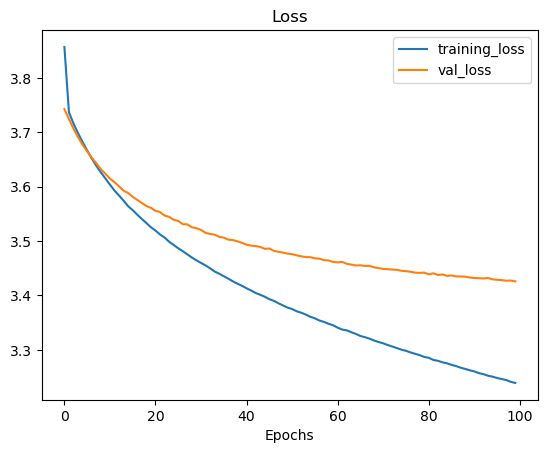

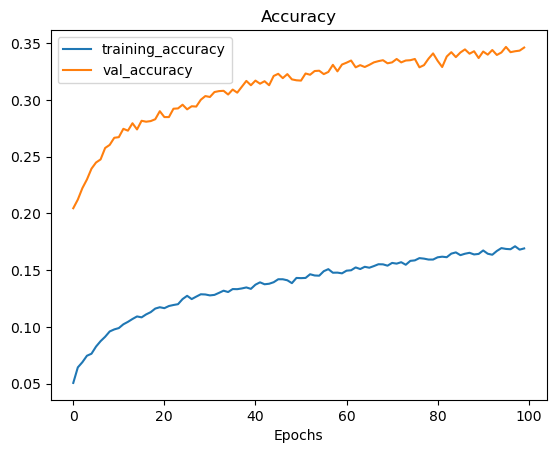

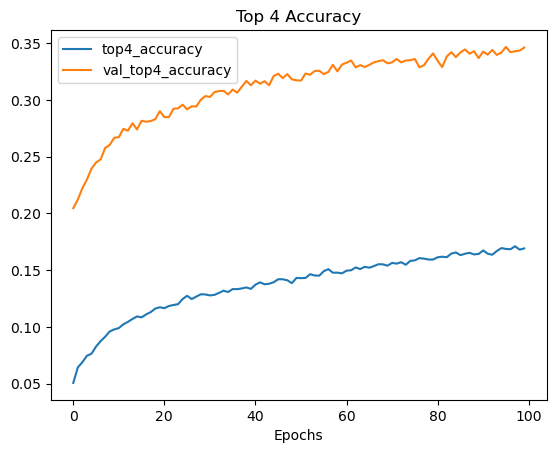

In [25]:
vgg19_1_history_mood = vgg19(vgg19_1_config)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 59)                30267     
                                                                 
 activation (Activation)     (None, 59)                0         
                                                                 
Total params: 20054651 (76.50 MB)
Trainable params: 20054651 (76.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
348/348 [==============================] - ETA: 0s - loss: 3.6852 - accuracy: 0.0815 - top_2_accuracy: 0.1642 - top_3_accuracy: 0.2236

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 366s 1s/step - loss: 3.6852 - accuracy: 0.0815 - top_2_accuracy: 0.1642 - top_3_accuracy: 0.2236 - top_4_accuracy: 0.2727 - ROC-AUC: 0.7597 - PR-AUC: 0.0603 - tp: 3.0000 - fp: 34.0000 - tn: 859120.0000 - fn: 14810.0000 - precision: 0.0811 - recall: 2.0252e-04 - f1_score: 0.0273 - val_loss: 3.5733 - val_accuracy: 0.0871 - val_top_2_accuracy: 0.1576 - val_top_3_accuracy: 0.2151 - val_top_4_accuracy: 0.2682 - val_ROC-AUC: 0.7729 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0149 - lr: 1.0000e-04
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.5254 - accuracy: 0.1107 - top_2_accuracy: 0.1845 - top_3_accuracy: 0.2440 - top_4_accuracy: 0.3003 - ROC-AUC: 0.7806 - PR-AUC: 0.0689 - tp: 2.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11112.0000 - precision: 0.4000 - recall: 1.7995e-04 - f1_score: 0.0287IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 367s 1s/step - loss: 3.5254 - accuracy: 0.1107 - top_2_accuracy: 0.1845 - top_3_accuracy: 0.2440 - top_4_accuracy: 0.3003 - ROC-AUC: 0.7806 - PR-AUC: 0.0689 - tp: 2.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11112.0000 - precision: 0.4000 - recall: 1.7995e-04 - f1_score: 0.0287 - val_loss: 3.4671 - val_accuracy: 0.1244 - val_top_2_accuracy: 0.2047 - val_top_3_accuracy: 0.2641 - val_top_4_accuracy: 0.3188 - val_ROC-AUC: 0.7927 - val_PR-AUC: 0.0763 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0300 - lr: 1.0000e-04
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.4562 - accuracy: 0.1256 - top_2_accuracy: 0.2059 - top_3_accuracy: 0.2706 - top_4_accuracy: 0.3284 - ROC-AUC: 0.7941 - PR-AUC: 0.0798 - tp: 9.0000 - fp: 13.0000 - tn: 644599.0000 - fn: 11105.0000 - precision: 0.4091 - recall: 8.0979e-04 - f1_score: 0.0383IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 369s 1s/step - loss: 3.4562 - accuracy: 0.1256 - top_2_accuracy: 0.2059 - top_3_accuracy: 0.2706 - top_4_accuracy: 0.3284 - ROC-AUC: 0.7941 - PR-AUC: 0.0798 - tp: 9.0000 - fp: 13.0000 - tn: 644599.0000 - fn: 11105.0000 - precision: 0.4091 - recall: 8.0979e-04 - f1_score: 0.0383 - val_loss: 3.4420 - val_accuracy: 0.1375 - val_top_2_accuracy: 0.2126 - val_top_3_accuracy: 0.2777 - val_top_4_accuracy: 0.3289 - val_ROC-AUC: 0.7948 - val_PR-AUC: 0.0882 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3672.0000 - val_precision: 0.5000 - val_recall: 2.7226e-04 - val_f1_score: 0.0366 - lr: 1.0000e-04
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.3875 - accuracy: 0.1346 - top_2_accuracy: 0.2218 - top_3_accuracy: 0.2892 - top_4_accuracy: 0.3461 - ROC-AUC: 0.8060 - PR-AUC: 0.0923 - tp: 38.0000 - fp: 29.0000 - tn: 644583.0000 - fn: 11076.0000 - precision: 0.5672 - recall: 0.0034 - f1_score: 0.0471INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 366s 1s/step - loss: 3.3875 - accuracy: 0.1346 - top_2_accuracy: 0.2218 - top_3_accuracy: 0.2892 - top_4_accuracy: 0.3461 - ROC-AUC: 0.8060 - PR-AUC: 0.0923 - tp: 38.0000 - fp: 29.0000 - tn: 644583.0000 - fn: 11076.0000 - precision: 0.5672 - recall: 0.0034 - f1_score: 0.0471 - val_loss: 3.4077 - val_accuracy: 0.1470 - val_top_2_accuracy: 0.2287 - val_top_3_accuracy: 0.2924 - val_top_4_accuracy: 0.3496 - val_ROC-AUC: 0.8009 - val_PR-AUC: 0.0934 - val_tp: 13.0000 - val_fp: 12.0000 - val_tn: 213022.0000 - val_fn: 3660.0000 - val_precision: 0.5200 - val_recall: 0.0035 - val_f1_score: 0.0510 - lr: 1.0000e-04
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.3374 - accuracy: 0.1467 - top_2_accuracy: 0.2408 - top_3_accuracy: 0.3138 - top_4_accuracy: 0.3721 - ROC-AUC: 0.8138 - PR-AUC: 0.1009 - tp: 57.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11057.0000 - precision: 0.5588 - recall: 0.0051 - f1_score: 0.0594INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 365s 1s/step - loss: 3.3374 - accuracy: 0.1467 - top_2_accuracy: 0.2408 - top_3_accuracy: 0.3138 - top_4_accuracy: 0.3721 - ROC-AUC: 0.8138 - PR-AUC: 0.1009 - tp: 57.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11057.0000 - precision: 0.5588 - recall: 0.0051 - f1_score: 0.0594 - val_loss: 3.3861 - val_accuracy: 0.1511 - val_top_2_accuracy: 0.2404 - val_top_3_accuracy: 0.3109 - val_top_4_accuracy: 0.3635 - val_ROC-AUC: 0.8040 - val_PR-AUC: 0.1002 - val_tp: 41.0000 - val_fp: 35.0000 - val_tn: 212999.0000 - val_fn: 3632.0000 - val_precision: 0.5395 - val_recall: 0.0112 - val_f1_score: 0.0540 - lr: 1.0000e-04
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.2752 - accuracy: 0.1603 - top_2_accuracy: 0.2573 - top_3_accuracy: 0.3325 - top_4_accuracy: 0.3876 - ROC-AUC: 0.8231 - PR-AUC: 0.1144 - tp: 80.0000 - fp: 60.0000 - tn: 644552.0000 - fn: 11034.0000 - precision: 0.5714 - recall: 0.0072 - f1_score: 0.0661INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 364s 1s/step - loss: 3.2752 - accuracy: 0.1603 - top_2_accuracy: 0.2573 - top_3_accuracy: 0.3325 - top_4_accuracy: 0.3876 - ROC-AUC: 0.8231 - PR-AUC: 0.1144 - tp: 80.0000 - fp: 60.0000 - tn: 644552.0000 - fn: 11034.0000 - precision: 0.5714 - recall: 0.0072 - f1_score: 0.0661 - val_loss: 3.3599 - val_accuracy: 0.1508 - val_top_2_accuracy: 0.2352 - val_top_3_accuracy: 0.3087 - val_top_4_accuracy: 0.3675 - val_ROC-AUC: 0.8080 - val_PR-AUC: 0.1050 - val_tp: 41.0000 - val_fp: 30.0000 - val_tn: 213004.0000 - val_fn: 3632.0000 - val_precision: 0.5775 - val_recall: 0.0112 - val_f1_score: 0.0507 - lr: 1.0000e-04
Epoch 7/100
348/348 [==============================] - ETA: 0s - loss: 3.2079 - accuracy: 0.1763 - top_2_accuracy: 0.2753 - top_3_accuracy: 0.3513 - top_4_accuracy: 0.4115 - ROC-AUC: 0.8333 - PR-AUC: 0.1284 - tp: 112.0000 - fp: 79.0000 - tn: 644533.0000 - fn: 11002.0000 - precision: 0.5864 - recall: 0.0101 - f1_score: 0.0825INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 367s 1s/step - loss: 3.2079 - accuracy: 0.1763 - top_2_accuracy: 0.2753 - top_3_accuracy: 0.3513 - top_4_accuracy: 0.4115 - ROC-AUC: 0.8333 - PR-AUC: 0.1284 - tp: 112.0000 - fp: 79.0000 - tn: 644533.0000 - fn: 11002.0000 - precision: 0.5864 - recall: 0.0101 - f1_score: 0.0825 - val_loss: 3.3171 - val_accuracy: 0.1582 - val_top_2_accuracy: 0.2483 - val_top_3_accuracy: 0.3248 - val_top_4_accuracy: 0.3833 - val_ROC-AUC: 0.8156 - val_PR-AUC: 0.1133 - val_tp: 47.0000 - val_fp: 31.0000 - val_tn: 213003.0000 - val_fn: 3626.0000 - val_precision: 0.6026 - val_recall: 0.0128 - val_f1_score: 0.0657 - lr: 1.0000e-04
Epoch 8/100
348/348 [==============================] - 362s 1s/step - loss: 3.1314 - accuracy: 0.1939 - top_2_accuracy: 0.2953 - top_3_accuracy: 0.3736 - top_4_accuracy: 0.4354 - ROC-AUC: 0.8434 - PR-AUC: 0.1475 - tp: 180.0000 - fp: 95.0000 - tn: 644517.0000 - fn: 10934.0000 - precision: 0.6545 - recall: 0.0162 - f1_score: 0.0982 - val_loss: 3

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_1_TL_FT/assets


115/115 [==============================] - 29s 255ms/step - loss: 3.3343 - accuracy: 0.1732 - top_2_accuracy: 0.2698 - top_3_accuracy: 0.3357 - top_4_accuracy: 0.3923 - ROC-AUC: 0.8135 - PR-AUC: 0.1310 - tp: 131.0000 - fp: 138.0000 - tn: 212896.0000 - fn: 3542.0000 - precision: 0.4870 - recall: 0.0357 - f1_score: 0.0997
VALID:
 [3.334299087524414, 0.17315545678138733, 0.2698066830635071, 0.3356928825378418, 0.3923223614692688, 0.8135277032852173, 0.13101458549499512, 131.0, 138.0, 212896.0, 3542.0, 0.4869888424873352, 0.03566566854715347, 0.09972024708986282]
116/116 [==============================] - 30s 255ms/step - loss: 3.3120 - accuracy: 0.1795 - top_2_accuracy: 0.2722 - top_3_accuracy: 0.3531 - top_4_accuracy: 0.4079 - ROC-AUC: 0.8157 - PR-AUC: 0.1336 - tp: 128.0000 - fp: 137.0000 - tn: 214405.0000 - fn: 3571.0000 - precision: 0.4830 - recall: 0.0346 - f1_score: 0.1008
TEST:
 [3.3120429515838623, 0.17950797080993652, 0.2722357511520386, 0.35306841135025024, 0.4079481065273285, 0.

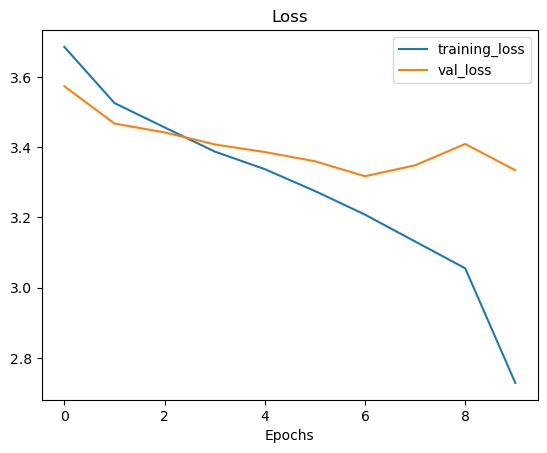

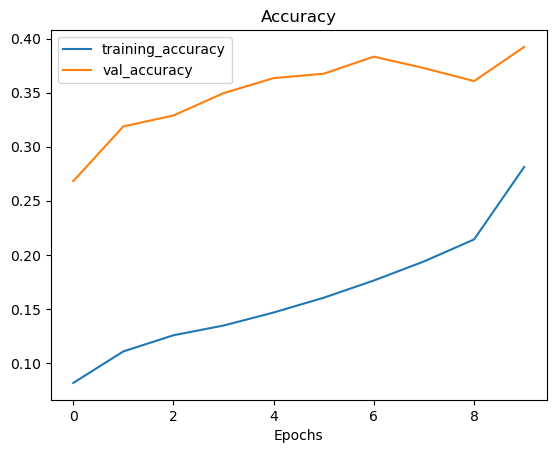

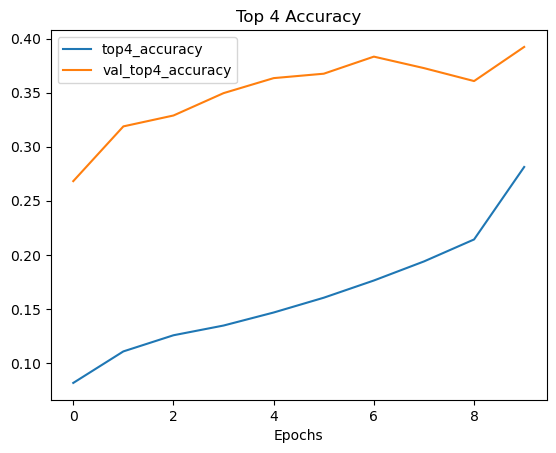

In [26]:
vgg19_1_history_mood_ft = fine_tune(vgg19_1_config)

### Mood | VGG19 | Learning from stratch

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 375s 1s/step - loss: 3.7861 - accuracy: 0.0571 - top_2_accuracy: 0.1518 - top_3_accuracy: 0.2004 - top_4_accuracy: 0.2494 - ROC-AUC: 0.7341 - PR-AUC: 0.0649 - tp: 341.0000 - fp: 674.0000 - tn: 858480.0000 - fn: 14472.0000 - precision: 0.3360 - recall: 0.0230 - f1_score: 0.0465 - val_loss: 3.7670 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1065 - val_top_3_accuracy: 0.1800 - val_top_4_accuracy: 0.2126 - val_ROC-AUC: 0.7277 - val_PR-AUC: 0.0401 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.7392 - accuracy: 0.0668 - top_2_accuracy: 0.1271 - top_3_accuracy: 0.1737 - top_4_accuracy: 0.2209 - ROC-AUC: 0.7298 - PR-AUC: 0.0430 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0064INFO:ten

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.7392 - accuracy: 0.0668 - top_2_accuracy: 0.1271 - top_3_accuracy: 0.1737 - top_4_accuracy: 0.2209 - ROC-AUC: 0.7298 - PR-AUC: 0.0430 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0064 - val_loss: 3.6812 - val_accuracy: 0.0871 - val_top_2_accuracy: 0.1443 - val_top_3_accuracy: 0.2015 - val_top_4_accuracy: 0.2518 - val_ROC-AUC: 0.7452 - val_PR-AUC: 0.0503 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0073
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.6762 - accuracy: 0.0814 - top_2_accuracy: 0.1441 - top_3_accuracy: 0.1942 - top_4_accuracy: 0.2457 - ROC-AUC: 0.7469 - PR-AUC: 0.0488 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 362s 1s/step - loss: 3.6762 - accuracy: 0.0814 - top_2_accuracy: 0.1441 - top_3_accuracy: 0.1942 - top_4_accuracy: 0.2457 - ROC-AUC: 0.7469 - PR-AUC: 0.0488 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0079 - val_loss: 3.6455 - val_accuracy: 0.0800 - val_top_2_accuracy: 0.1503 - val_top_3_accuracy: 0.2045 - val_top_4_accuracy: 0.2559 - val_ROC-AUC: 0.7548 - val_PR-AUC: 0.0537 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0049
Epoch 4/100
348/348 [==============================] - 359s 1s/step - loss: 3.6501 - accuracy: 0.0880 - top_2_accuracy: 0.1472 - top_3_accuracy: 0.2004 - top_4_accuracy: 0.2490 - ROC-AUC: 0.7531 - PR-AUC: 0.0511 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_scor

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 362s 1s/step - loss: 3.6291 - accuracy: 0.0857 - top_2_accuracy: 0.1493 - top_3_accuracy: 0.2047 - top_4_accuracy: 0.2536 - ROC-AUC: 0.7582 - PR-AUC: 0.0532 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0099 - val_loss: 3.6123 - val_accuracy: 0.0972 - val_top_2_accuracy: 0.1533 - val_top_3_accuracy: 0.2118 - val_top_4_accuracy: 0.2581 - val_ROC-AUC: 0.7626 - val_PR-AUC: 0.0551 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0125
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.6153 - accuracy: 0.0905 - top_2_accuracy: 0.1493 - top_3_accuracy: 0.2095 - top_4_accuracy: 0.2633 - ROC-AUC: 0.7619 - PR-AUC: 0.0540 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.6153 - accuracy: 0.0905 - top_2_accuracy: 0.1493 - top_3_accuracy: 0.2095 - top_4_accuracy: 0.2633 - ROC-AUC: 0.7619 - PR-AUC: 0.0540 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0126 - val_loss: 3.5975 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1620 - val_top_3_accuracy: 0.2118 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7664 - val_PR-AUC: 0.0577 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0098
Epoch 7/100
348/348 [==============================] - 359s 1s/step - loss: 3.5989 - accuracy: 0.0906 - top_2_accuracy: 0.1577 - top_3_accuracy: 0.2153 - top_4_accuracy: 0.2676 - ROC-AUC: 0.7655 - PR-AUC: 0.0557 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_scor

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.5887 - accuracy: 0.0934 - top_2_accuracy: 0.1585 - top_3_accuracy: 0.2157 - top_4_accuracy: 0.2680 - ROC-AUC: 0.7675 - PR-AUC: 0.0572 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0169 - val_loss: 3.5854 - val_accuracy: 0.1002 - val_top_2_accuracy: 0.1718 - val_top_3_accuracy: 0.2301 - val_top_4_accuracy: 0.2837 - val_ROC-AUC: 0.7673 - val_PR-AUC: 0.0607 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0173
Epoch 9/100
348/348 [==============================] - ETA: 0s - loss: 3.5683 - accuracy: 0.0960 - top_2_accuracy: 0.1695 - top_3_accuracy: 0.2256 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7719 - PR-AUC: 0.0599 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.5683 - accuracy: 0.0960 - top_2_accuracy: 0.1695 - top_3_accuracy: 0.2256 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7719 - PR-AUC: 0.0599 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0196 - val_loss: 3.5679 - val_accuracy: 0.0928 - val_top_2_accuracy: 0.1639 - val_top_3_accuracy: 0.2246 - val_top_4_accuracy: 0.2840 - val_ROC-AUC: 0.7733 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0180
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.5432 - accuracy: 0.1041 - top_2_accuracy: 0.1783 - top_3_accuracy: 0.2373 - top_4_accuracy: 0.2923 - ROC-AUC: 0.7777 - PR-AUC: 0.0630 - tp: 1.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11113.0000 - precision: 1.0000 - recall: 8.9977e-05 - f1_score: 0.0239INF

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.5432 - accuracy: 0.1041 - top_2_accuracy: 0.1783 - top_3_accuracy: 0.2373 - top_4_accuracy: 0.2923 - ROC-AUC: 0.7777 - PR-AUC: 0.0630 - tp: 1.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11113.0000 - precision: 1.0000 - recall: 8.9977e-05 - f1_score: 0.0239 - val_loss: 3.5566 - val_accuracy: 0.1007 - val_top_2_accuracy: 0.1712 - val_top_3_accuracy: 0.2350 - val_top_4_accuracy: 0.2932 - val_ROC-AUC: 0.7758 - val_PR-AUC: 0.0636 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0197
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.5168 - accuracy: 0.1082 - top_2_accuracy: 0.1864 - top_3_accuracy: 0.2468 - top_4_accuracy: 0.3001 - ROC-AUC: 0.7832 - PR-AUC: 0.0665 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0290INFO:te

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 368s 1s/step - loss: 3.5168 - accuracy: 0.1082 - top_2_accuracy: 0.1864 - top_3_accuracy: 0.2468 - top_4_accuracy: 0.3001 - ROC-AUC: 0.7832 - PR-AUC: 0.0665 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0290 - val_loss: 3.5184 - val_accuracy: 0.1133 - val_top_2_accuracy: 0.1971 - val_top_3_accuracy: 0.2524 - val_top_4_accuracy: 0.3071 - val_ROC-AUC: 0.7825 - val_PR-AUC: 0.0708 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0243
Epoch 12/100
348/348 [==============================] - 360s 1s/step - loss: 3.4757 - accuracy: 0.1207 - top_2_accuracy: 0.1995 - top_3_accuracy: 0.2672 - top_4_accuracy: 0.3244 - ROC-AUC: 0.7910 - PR-AUC: 0.0736 - tp: 3.0000 - fp: 4.0000 - tn: 644608.0000 - fn: 11111.0000 - precision: 0.4286 - recall: 2.6993e-04 - f1_score: 0.0365 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.4415 - accuracy: 0.1268 - top_2_accuracy: 0.2096 - top_3_accuracy: 0.2760 - top_4_accuracy: 0.3319 - ROC-AUC: 0.7973 - PR-AUC: 0.0789 - tp: 2.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11112.0000 - precision: 0.4000 - recall: 1.7995e-04 - f1_score: 0.0409 - val_loss: 3.4792 - val_accuracy: 0.1187 - val_top_2_accuracy: 0.2039 - val_top_3_accuracy: 0.2638 - val_top_4_accuracy: 0.3191 - val_ROC-AUC: 0.7896 - val_PR-AUC: 0.0785 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3672.0000 - val_precision: 0.5000 - val_recall: 2.7226e-04 - val_f1_score: 0.0326
Epoch 14/100
348/348 [==============================] - 360s 1s/step - loss: 3.3945 - accuracy: 0.1353 - top_2_accuracy: 0.2258 - top_3_accuracy: 0.2943 - top_4_accuracy: 0.3482 - ROC-AUC: 0.8050 - PR-AUC: 0.0886 - tp: 11.0000 - fp: 6.0000 - tn: 644606.0000 - fn: 11103.0000 - precision: 0.6471 - recall: 9.8974e-04 - f1_score: 0.0478 - val_loss: 3.4954 - val

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 361s 1s/step - loss: 3.3466 - accuracy: 0.1470 - top_2_accuracy: 0.2391 - top_3_accuracy: 0.3093 - top_4_accuracy: 0.3662 - ROC-AUC: 0.8132 - PR-AUC: 0.0969 - tp: 14.0000 - fp: 19.0000 - tn: 644593.0000 - fn: 11100.0000 - precision: 0.4242 - recall: 0.0013 - f1_score: 0.0582 - val_loss: 3.4596 - val_accuracy: 0.1280 - val_top_2_accuracy: 0.2099 - val_top_3_accuracy: 0.2744 - val_top_4_accuracy: 0.3194 - val_ROC-AUC: 0.7935 - val_PR-AUC: 0.0800 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3672.0000 - val_precision: 1.0000 - val_recall: 2.7226e-04 - val_f1_score: 0.0464
Epoch 16/100
348/348 [==============================] - 360s 1s/step - loss: 3.2881 - accuracy: 0.1576 - top_2_accuracy: 0.2547 - top_3_accuracy: 0.3273 - top_4_accuracy: 0.3907 - ROC-AUC: 0.8211 - PR-AUC: 0.1101 - tp: 42.0000 - fp: 23.0000 - tn: 644589.0000 - fn: 11072.0000 - precision: 0.6462 - recall: 0.0038 - f1_score: 0.0684 - val_loss: 3.4604 - val_

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/VGG19_2/assets


115/115 [==============================] - 30s 255ms/step - loss: 3.5448 - accuracy: 0.1337 - top_2_accuracy: 0.2167 - top_3_accuracy: 0.2744 - top_4_accuracy: 0.3286 - ROC-AUC: 0.7861 - PR-AUC: 0.0865 - tp: 44.0000 - fp: 90.0000 - tn: 212944.0000 - fn: 3629.0000 - precision: 0.3284 - recall: 0.0120 - f1_score: 0.0547
VALID:
 [3.544797420501709, 0.13367819786071777, 0.21671658754348755, 0.2744350731372833, 0.328614205121994, 0.7860938310623169, 0.08647520840167999, 44.0, 90.0, 212944.0, 3629.0, 0.3283582031726837, 0.011979308910667896, 0.05473566800355911]
116/116 [==============================] - 30s 258ms/step - loss: 3.5455 - accuracy: 0.1392 - top_2_accuracy: 0.2195 - top_3_accuracy: 0.2825 - top_4_accuracy: 0.3382 - ROC-AUC: 0.7859 - PR-AUC: 0.0834 - tp: 41.0000 - fp: 97.0000 - tn: 214445.0000 - fn: 3658.0000 - precision: 0.2971 - recall: 0.0111 - f1_score: 0.0625
TEST:
 [3.5454931259155273, 0.13922682404518127, 0.21951879560947418, 0.2825087904930115, 0.33819952607154846, 0.7859

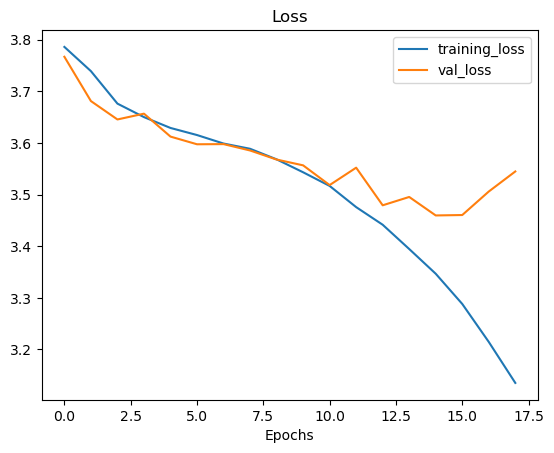

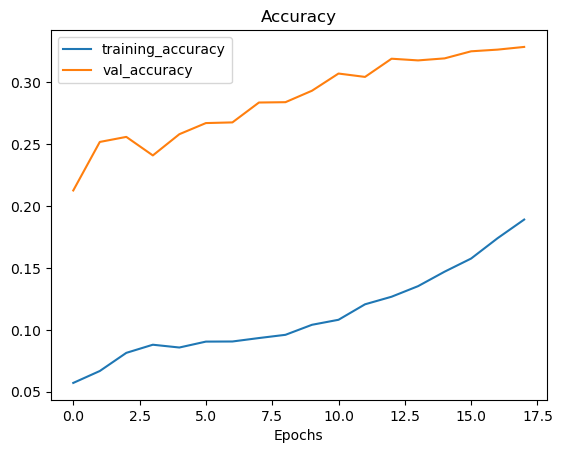

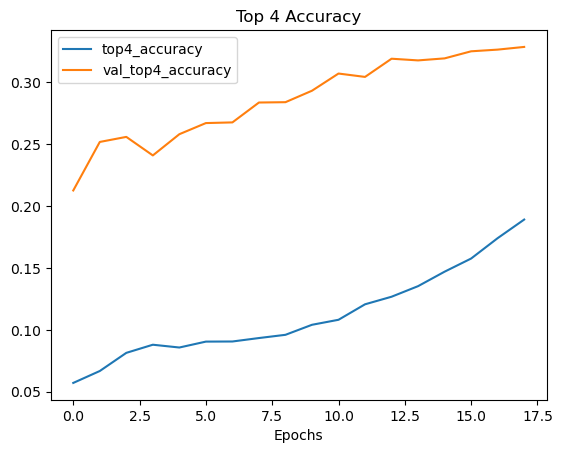

In [31]:
vgg19_2_history_mood = vgg19(vgg19_2_config)

- training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

- training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

## Mood | EfficientNetV2L

### Mood | EfficientNetV2L | Transfer Learning

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 67s 183ms/step - loss: 3.8186 - accuracy: 0.0579 - top_2_accuracy: 0.1460 - top_3_accuracy: 0.2010 - top_4_accuracy: 0.2486 - ROC-AUC: 0.7385 - PR-AUC: 0.0648 - tp: 128.0000 - fp: 137.0000 - tn: 859017.0000 - fn: 14685.0000 - precision: 0.4830 - recall: 0.0086 - f1_score: 0.0405 - val_loss: 3.7450 - val_accuracy: 0.0615 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1666 - val_top_4_accuracy: 0.2077 - val_ROC-AUC: 0.7271 - val_PR-AUC: 0.0403 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0025
Epoch 2/100
348/348 [==============================] - 51s 146ms/step - loss: 3.7588 - accuracy: 0.0578 - top_2_accuracy: 0.1106 - top_3_accuracy: 0.1610 - top_4_accuracy: 0.2063 - ROC-AUC: 0.7236 - PR-AUC: 0.0395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.004

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 172ms/step - loss: 3.7579 - accuracy: 0.0589 - top_2_accuracy: 0.1117 - top_3_accuracy: 0.1593 - top_4_accuracy: 0.2052 - ROC-AUC: 0.7243 - PR-AUC: 0.0398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0059 - val_loss: 3.7449 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1655 - val_top_4_accuracy: 0.2137 - val_ROC-AUC: 0.7260 - val_PR-AUC: 0.0411 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.7579 - accuracy: 0.0572 - top_2_accuracy: 0.1146 - top_3_accuracy: 0.1596 - top_4_accuracy: 0.2030 - ROC-AUC: 0.7243 - PR-AUC: 0.0399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 173ms/step - loss: 3.7579 - accuracy: 0.0572 - top_2_accuracy: 0.1146 - top_3_accuracy: 0.1596 - top_4_accuracy: 0.2030 - ROC-AUC: 0.7243 - PR-AUC: 0.0399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0042 - val_loss: 3.7447 - val_accuracy: 0.0585 - val_top_2_accuracy: 0.1010 - val_top_3_accuracy: 0.1563 - val_top_4_accuracy: 0.2156 - val_ROC-AUC: 0.7282 - val_PR-AUC: 0.0397 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0019
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.7557 - accuracy: 0.0560 - top_2_accuracy: 0.1095 - top_3_accuracy: 0.1603 - top_4_accuracy: 0.2042 - ROC-AUC: 0.7245 - PR-AUC: 0.0401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 171ms/step - loss: 3.7557 - accuracy: 0.0560 - top_2_accuracy: 0.1095 - top_3_accuracy: 0.1603 - top_4_accuracy: 0.2042 - ROC-AUC: 0.7245 - PR-AUC: 0.0401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0058 - val_loss: 3.7439 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2096 - val_ROC-AUC: 0.7289 - val_PR-AUC: 0.0412 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020
Epoch 6/100
348/348 [==============================] - 51s 146ms/step - loss: 3.7563 - accuracy: 0.0614 - top_2_accuracy: 0.1154 - top_3_accuracy: 0.1636 - top_4_accuracy: 0.2037 - ROC-AUC: 0.7248 - PR-AUC: 0.0403 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 171ms/step - loss: 3.7568 - accuracy: 0.0641 - top_2_accuracy: 0.1109 - top_3_accuracy: 0.1575 - top_4_accuracy: 0.2014 - ROC-AUC: 0.7242 - PR-AUC: 0.0400 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0046 - val_loss: 3.7417 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1040 - val_top_3_accuracy: 0.1625 - val_top_4_accuracy: 0.2026 - val_ROC-AUC: 0.7279 - val_PR-AUC: 0.0408 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020
Epoch 8/100
348/348 [==============================] - ETA: 0s - loss: 3.7540 - accuracy: 0.0582 - top_2_accuracy: 0.1156 - top_3_accuracy: 0.1593 - top_4_accuracy: 0.2053 - ROC-AUC: 0.7252 - PR-AUC: 0.0402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 172ms/step - loss: 3.7540 - accuracy: 0.0582 - top_2_accuracy: 0.1156 - top_3_accuracy: 0.1593 - top_4_accuracy: 0.2053 - ROC-AUC: 0.7252 - PR-AUC: 0.0402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0054 - val_loss: 3.7408 - val_accuracy: 0.0585 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2061 - val_ROC-AUC: 0.7292 - val_PR-AUC: 0.0405 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0019
Epoch 9/100
348/348 [==============================] - 51s 146ms/step - loss: 3.7550 - accuracy: 0.0607 - top_2_accuracy: 0.1132 - top_3_accuracy: 0.1626 - top_4_accuracy: 0.2078 - ROC-AUC: 0.7258 - PR-AUC: 0.0400 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 60s 173ms/step - loss: 3.7581 - accuracy: 0.0604 - top_2_accuracy: 0.1132 - top_3_accuracy: 0.1606 - top_4_accuracy: 0.2077 - ROC-AUC: 0.7247 - PR-AUC: 0.0400 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0052 - val_loss: 3.7392 - val_accuracy: 0.0585 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1661 - val_top_4_accuracy: 0.2132 - val_ROC-AUC: 0.7299 - val_PR-AUC: 0.0408 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0019
Epoch 12/100
348/348 [==============================] - 51s 146ms/step - loss: 3.7556 - accuracy: 0.0582 - top_2_accuracy: 0.1116 - top_3_accuracy: 0.1635 - top_4_accuracy: 0.2073 - ROC-AUC: 0.7247 - PR-AUC: 0.0401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL/assets


115/115 [==============================] - 13s 110ms/step - loss: 3.7414 - accuracy: 0.0438 - top_2_accuracy: 0.1062 - top_3_accuracy: 0.1478 - top_4_accuracy: 0.2064 - ROC-AUC: 0.7289 - PR-AUC: 0.0396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 213034.0000 - fn: 3673.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014
VALID:
 [3.7414495944976807, 0.043833378702402115, 0.10618023574352264, 0.14783555269241333, 0.20637081563472748, 0.7289392352104187, 0.03958255425095558, 0.0, 0.0, 213034.0, 3673.0, 0.0, 0.0, 0.0014234812697395682]
116/116 [==============================] - 14s 121ms/step - loss: 3.7461 - accuracy: 0.0438 - top_2_accuracy: 0.1054 - top_3_accuracy: 0.1471 - top_4_accuracy: 0.2049 - ROC-AUC: 0.7275 - PR-AUC: 0.0392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 214542.0000 - fn: 3699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0014
TEST:
 [3.7460899353027344, 0.043795619159936905, 0.10543390363454819, 0.14706677198410034, 0.20492024719715118, 0.7

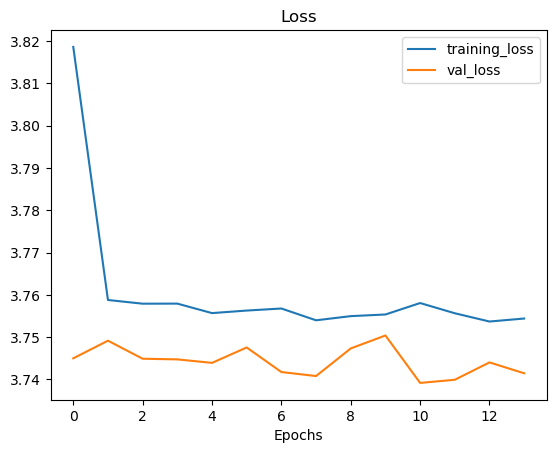

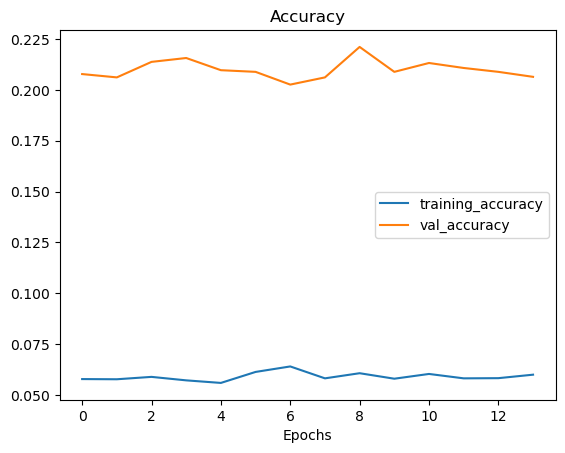

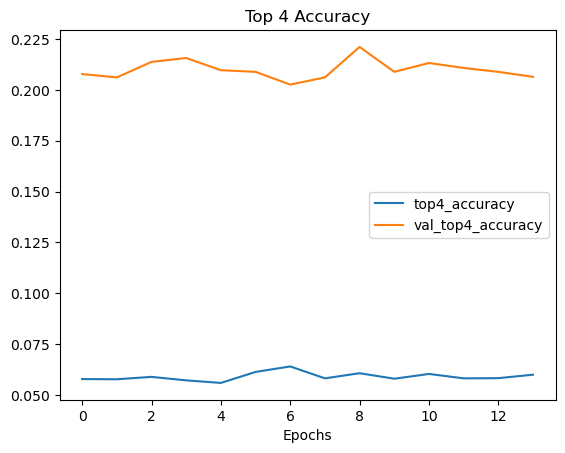

In [27]:
effnet_1_history_mood = effnet(effnet_1_config) #b0 0.0001

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 1280)              0         
 oling2D)                                                        
                                                                 
 dense_1 (Dense)             (None, 59)                75579     
                                                                 
 activation_1 (Activation)   (None, 59)                0         
                                                                 
Total params: 5994891 (22.87 MB)
Trainable params: 5934283 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 136s 359ms/step - loss: 3.7865 - accuracy: 0.0544 - top_2_accuracy: 0.1064 - top_3_accuracy: 0.1508 - top_4_accuracy: 0.1977 - ROC-AUC: 0.7180 - PR-AUC: 0.0383 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 859154.0000 - fn: 14813.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0077 - val_loss: 3.7557 - val_accuracy: 0.0471 - val_top_2_accuracy: 0.1056 - val_top_3_accuracy: 0.1500 - val_top_4_accuracy: 0.1794 - val_ROC-AUC: 0.7245 - val_PR-AUC: 0.0375 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0015 - lr: 1.0000e-04
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.7601 - accuracy: 0.0573 - top_2_accuracy: 0.1117 - top_3_accuracy: 0.1605 - top_4_accuracy: 0.2052 - ROC-AUC: 0.7239 - PR-AUC: 0.0392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 318ms/step - loss: 3.7601 - accuracy: 0.0573 - top_2_accuracy: 0.1117 - top_3_accuracy: 0.1605 - top_4_accuracy: 0.2052 - ROC-AUC: 0.7239 - PR-AUC: 0.0392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0061 - val_loss: 3.7411 - val_accuracy: 0.0585 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1650 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7289 - val_PR-AUC: 0.0407 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0019 - lr: 1.0000e-04
Epoch 3/100
348/348 [==============================] - 101s 287ms/step - loss: 3.7549 - accuracy: 0.0594 - top_2_accuracy: 0.1123 - top_3_accuracy: 0.1573 - top_4_accuracy: 0.2014 - ROC-AUC: 0.7245 - PR-AUC: 0.0396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recal

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 321ms/step - loss: 3.7529 - accuracy: 0.0615 - top_2_accuracy: 0.1171 - top_3_accuracy: 0.1616 - top_4_accuracy: 0.2051 - ROC-AUC: 0.7257 - PR-AUC: 0.0400 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0037 - val_loss: 3.7397 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1606 - val_top_4_accuracy: 0.2050 - val_ROC-AUC: 0.7299 - val_PR-AUC: 0.0410 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 1.0000e-04
Epoch 5/100
348/348 [==============================] - 101s 287ms/step - loss: 3.7502 - accuracy: 0.0594 - top_2_accuracy: 0.1158 - top_3_accuracy: 0.1628 - top_4_accuracy: 0.2060 - ROC-AUC: 0.7266 - PR-AUC: 0.0401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recal

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7512 - accuracy: 0.0561 - top_2_accuracy: 0.1133 - top_3_accuracy: 0.1589 - top_4_accuracy: 0.2038 - ROC-AUC: 0.7265 - PR-AUC: 0.0395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0038 - val_loss: 3.7344 - val_accuracy: 0.0585 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1644 - val_top_4_accuracy: 0.2088 - val_ROC-AUC: 0.7312 - val_PR-AUC: 0.0409 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0019 - lr: 1.0000e-04
Epoch 7/100
348/348 [==============================] - 101s 288ms/step - loss: 3.7473 - accuracy: 0.0606 - top_2_accuracy: 0.1158 - top_3_accuracy: 0.1613 - top_4_accuracy: 0.2078 - ROC-AUC: 0.7275 - PR-AUC: 0.0402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recal

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 320ms/step - loss: 3.7409 - accuracy: 0.0610 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1634 - top_4_accuracy: 0.2105 - ROC-AUC: 0.7287 - PR-AUC: 0.0406 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0035 - val_loss: 3.7301 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7321 - val_PR-AUC: 0.0414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 2.0000e-05
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.7384 - accuracy: 0.0620 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1662 - top_4_accuracy: 0.2081 - ROC-AUC: 0.7294 - PR-AUC: 0.0407 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.7384 - accuracy: 0.0620 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1662 - top_4_accuracy: 0.2081 - ROC-AUC: 0.7294 - PR-AUC: 0.0407 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0035 - val_loss: 3.7300 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2115 - val_ROC-AUC: 0.7326 - val_PR-AUC: 0.0415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 2.0000e-05
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.7388 - accuracy: 0.0620 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1660 - top_4_accuracy: 0.2095 - ROC-AUC: 0.7299 - PR-AUC: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 318ms/step - loss: 3.7366 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2095 - ROC-AUC: 0.7301 - PR-AUC: 0.0410 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0020 - val_loss: 3.7294 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7324 - val_PR-AUC: 0.0415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 13/100
348/348 [==============================] - ETA: 0s - loss: 3.7361 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2101 - ROC-AUC: 0.7301 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7361 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2101 - ROC-AUC: 0.7301 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0020 - val_loss: 3.7291 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2105 - val_ROC-AUC: 0.7324 - val_PR-AUC: 0.0415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 14/100
348/348 [==============================] - ETA: 0s - loss: 3.7361 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2106 - ROC-AUC: 0.7300 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7361 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2106 - ROC-AUC: 0.7300 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0020 - val_loss: 3.7290 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2140 - val_ROC-AUC: 0.7322 - val_PR-AUC: 0.0414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 15/100
348/348 [==============================] - ETA: 0s - loss: 3.7359 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2089 - ROC-AUC: 0.7303 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 319ms/step - loss: 3.7359 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2089 - ROC-AUC: 0.7303 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0020 - val_loss: 3.7288 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7324 - val_PR-AUC: 0.0414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 16/100
348/348 [==============================] - ETA: 0s - loss: 3.7358 - accuracy: 0.0611 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2095 - ROC-AUC: 0.7303 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7358 - accuracy: 0.0611 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1667 - top_4_accuracy: 0.2095 - ROC-AUC: 0.7303 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0027 - val_loss: 3.7285 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2077 - val_ROC-AUC: 0.7323 - val_PR-AUC: 0.0415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 17/100
348/348 [==============================] - ETA: 0s - loss: 3.7354 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1662 - top_4_accuracy: 0.2092 - ROC-AUC: 0.7302 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.7354 - accuracy: 0.0617 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1662 - top_4_accuracy: 0.2092 - ROC-AUC: 0.7302 - PR-AUC: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0020 - val_loss: 3.7280 - val_accuracy: 0.0623 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2121 - val_ROC-AUC: 0.7325 - val_PR-AUC: 0.0416 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0023 - lr: 4.0000e-06
Epoch 18/100
348/348 [==============================] - ETA: 0s - loss: 3.7350 - accuracy: 0.0637 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1663 - top_4_accuracy: 0.2088 - ROC-AUC: 0.7302 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.7350 - accuracy: 0.0637 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1663 - top_4_accuracy: 0.2088 - ROC-AUC: 0.7302 - PR-AUC: 0.0411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0035 - val_loss: 3.7271 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1677 - val_top_4_accuracy: 0.2077 - val_ROC-AUC: 0.7323 - val_PR-AUC: 0.0415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0020 - lr: 4.0000e-06
Epoch 19/100
348/348 [==============================] - ETA: 0s - loss: 3.7337 - accuracy: 0.0654 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1673 - top_4_accuracy: 0.2075 - ROC-AUC: 0.7302 - PR-AUC: 0.0416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.7337 - accuracy: 0.0654 - top_2_accuracy: 0.1198 - top_3_accuracy: 0.1673 - top_4_accuracy: 0.2075 - ROC-AUC: 0.7302 - PR-AUC: 0.0416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0041 - val_loss: 3.7256 - val_accuracy: 0.0621 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1680 - val_top_4_accuracy: 0.2134 - val_ROC-AUC: 0.7321 - val_PR-AUC: 0.0417 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0021 - lr: 4.0000e-06
Epoch 20/100
348/348 [==============================] - ETA: 0s - loss: 3.7307 - accuracy: 0.0655 - top_2_accuracy: 0.1207 - top_3_accuracy: 0.1670 - top_4_accuracy: 0.2101 - ROC-AUC: 0.7310 - PR-AUC: 0.0424 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7307 - accuracy: 0.0655 - top_2_accuracy: 0.1207 - top_3_accuracy: 0.1670 - top_4_accuracy: 0.2101 - ROC-AUC: 0.7310 - PR-AUC: 0.0424 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0040 - val_loss: 3.7197 - val_accuracy: 0.0678 - val_top_2_accuracy: 0.1206 - val_top_3_accuracy: 0.1712 - val_top_4_accuracy: 0.2110 - val_ROC-AUC: 0.7343 - val_PR-AUC: 0.0446 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0042 - lr: 4.0000e-06
Epoch 21/100
348/348 [==============================] - ETA: 0s - loss: 3.7233 - accuracy: 0.0660 - top_2_accuracy: 0.1226 - top_3_accuracy: 0.1687 - top_4_accuracy: 0.2148 - ROC-AUC: 0.7337 - PR-AUC: 0.0437 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.7233 - accuracy: 0.0660 - top_2_accuracy: 0.1226 - top_3_accuracy: 0.1687 - top_4_accuracy: 0.2148 - ROC-AUC: 0.7337 - PR-AUC: 0.0437 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0040 - val_loss: 3.7122 - val_accuracy: 0.0727 - val_top_2_accuracy: 0.1331 - val_top_3_accuracy: 0.1770 - val_top_4_accuracy: 0.2151 - val_ROC-AUC: 0.7362 - val_PR-AUC: 0.0459 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0056 - lr: 4.0000e-06
Epoch 22/100
348/348 [==============================] - ETA: 0s - loss: 3.7138 - accuracy: 0.0681 - top_2_accuracy: 0.1315 - top_3_accuracy: 0.1777 - top_4_accuracy: 0.2242 - ROC-AUC: 0.7370 - PR-AUC: 0.0450 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.7138 - accuracy: 0.0681 - top_2_accuracy: 0.1315 - top_3_accuracy: 0.1777 - top_4_accuracy: 0.2242 - ROC-AUC: 0.7370 - PR-AUC: 0.0450 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0053 - val_loss: 3.7034 - val_accuracy: 0.0738 - val_top_2_accuracy: 0.1364 - val_top_3_accuracy: 0.1778 - val_top_4_accuracy: 0.2276 - val_ROC-AUC: 0.7401 - val_PR-AUC: 0.0471 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0065 - lr: 4.0000e-06
Epoch 23/100
348/348 [==============================] - ETA: 0s - loss: 3.7037 - accuracy: 0.0700 - top_2_accuracy: 0.1335 - top_3_accuracy: 0.1870 - top_4_accuracy: 0.2356 - ROC-AUC: 0.7401 - PR-AUC: 0.0467 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.7037 - accuracy: 0.0700 - top_2_accuracy: 0.1335 - top_3_accuracy: 0.1870 - top_4_accuracy: 0.2356 - ROC-AUC: 0.7401 - PR-AUC: 0.0467 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0065 - val_loss: 3.6944 - val_accuracy: 0.0779 - val_top_2_accuracy: 0.1405 - val_top_3_accuracy: 0.1892 - val_top_4_accuracy: 0.2331 - val_ROC-AUC: 0.7425 - val_PR-AUC: 0.0482 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0082 - lr: 4.0000e-06
Epoch 24/100
348/348 [==============================] - ETA: 0s - loss: 3.6924 - accuracy: 0.0764 - top_2_accuracy: 0.1411 - top_3_accuracy: 0.1946 - top_4_accuracy: 0.2403 - ROC-AUC: 0.7424 - PR-AUC: 0.0479 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.6924 - accuracy: 0.0764 - top_2_accuracy: 0.1411 - top_3_accuracy: 0.1946 - top_4_accuracy: 0.2403 - ROC-AUC: 0.7424 - PR-AUC: 0.0479 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0095 - val_loss: 3.6881 - val_accuracy: 0.0743 - val_top_2_accuracy: 0.1413 - val_top_3_accuracy: 0.1938 - val_top_4_accuracy: 0.2380 - val_ROC-AUC: 0.7439 - val_PR-AUC: 0.0489 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0077 - lr: 4.0000e-06
Epoch 25/100
348/348 [==============================] - ETA: 0s - loss: 3.6836 - accuracy: 0.0784 - top_2_accuracy: 0.1442 - top_3_accuracy: 0.2016 - top_4_accuracy: 0.2456 - ROC-AUC: 0.7449 - PR-AUC: 0.0489 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.6836 - accuracy: 0.0784 - top_2_accuracy: 0.1442 - top_3_accuracy: 0.2016 - top_4_accuracy: 0.2456 - ROC-AUC: 0.7449 - PR-AUC: 0.0489 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0096 - val_loss: 3.6785 - val_accuracy: 0.0839 - val_top_2_accuracy: 0.1413 - val_top_3_accuracy: 0.1987 - val_top_4_accuracy: 0.2401 - val_ROC-AUC: 0.7455 - val_PR-AUC: 0.0499 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0090 - lr: 4.0000e-06
Epoch 26/100
348/348 [==============================] - ETA: 0s - loss: 3.6726 - accuracy: 0.0803 - top_2_accuracy: 0.1465 - top_3_accuracy: 0.2024 - top_4_accuracy: 0.2481 - ROC-AUC: 0.7480 - PR-AUC: 0.0501 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 116s 329ms/step - loss: 3.6726 - accuracy: 0.0803 - top_2_accuracy: 0.1465 - top_3_accuracy: 0.2024 - top_4_accuracy: 0.2481 - ROC-AUC: 0.7480 - PR-AUC: 0.0501 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0107 - val_loss: 3.6738 - val_accuracy: 0.0760 - val_top_2_accuracy: 0.1410 - val_top_3_accuracy: 0.1960 - val_top_4_accuracy: 0.2431 - val_ROC-AUC: 0.7480 - val_PR-AUC: 0.0498 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0091 - lr: 4.0000e-06
Epoch 27/100
348/348 [==============================] - ETA: 0s - loss: 3.6618 - accuracy: 0.0794 - top_2_accuracy: 0.1494 - top_3_accuracy: 0.2046 - top_4_accuracy: 0.2496 - ROC-AUC: 0.7510 - PR-AUC: 0.0510 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.6618 - accuracy: 0.0794 - top_2_accuracy: 0.1494 - top_3_accuracy: 0.2046 - top_4_accuracy: 0.2496 - ROC-AUC: 0.7510 - PR-AUC: 0.0510 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0114 - val_loss: 3.6612 - val_accuracy: 0.0800 - val_top_2_accuracy: 0.1476 - val_top_3_accuracy: 0.2083 - val_top_4_accuracy: 0.2469 - val_ROC-AUC: 0.7508 - val_PR-AUC: 0.0518 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0096 - lr: 4.0000e-06
Epoch 28/100
348/348 [==============================] - ETA: 0s - loss: 3.6544 - accuracy: 0.0806 - top_2_accuracy: 0.1519 - top_3_accuracy: 0.2063 - top_4_accuracy: 0.2527 - ROC-AUC: 0.7525 - PR-AUC: 0.0517 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.6544 - accuracy: 0.0806 - top_2_accuracy: 0.1519 - top_3_accuracy: 0.2063 - top_4_accuracy: 0.2527 - ROC-AUC: 0.7525 - PR-AUC: 0.0517 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0114 - val_loss: 3.6537 - val_accuracy: 0.0798 - val_top_2_accuracy: 0.1484 - val_top_3_accuracy: 0.2083 - val_top_4_accuracy: 0.2529 - val_ROC-AUC: 0.7527 - val_PR-AUC: 0.0519 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0097 - lr: 4.0000e-06
Epoch 29/100
348/348 [==============================] - ETA: 0s - loss: 3.6467 - accuracy: 0.0843 - top_2_accuracy: 0.1524 - top_3_accuracy: 0.2069 - top_4_accuracy: 0.2532 - ROC-AUC: 0.7544 - PR-AUC: 0.0528 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.6467 - accuracy: 0.0843 - top_2_accuracy: 0.1524 - top_3_accuracy: 0.2069 - top_4_accuracy: 0.2532 - ROC-AUC: 0.7544 - PR-AUC: 0.0528 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0124 - val_loss: 3.6481 - val_accuracy: 0.0768 - val_top_2_accuracy: 0.1459 - val_top_3_accuracy: 0.2075 - val_top_4_accuracy: 0.2540 - val_ROC-AUC: 0.7550 - val_PR-AUC: 0.0530 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0100 - lr: 4.0000e-06
Epoch 30/100
348/348 [==============================] - ETA: 0s - loss: 3.6414 - accuracy: 0.0830 - top_2_accuracy: 0.1539 - top_3_accuracy: 0.2084 - top_4_accuracy: 0.2584 - ROC-AUC: 0.7561 - PR-AUC: 0.0531 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.6414 - accuracy: 0.0830 - top_2_accuracy: 0.1539 - top_3_accuracy: 0.2084 - top_4_accuracy: 0.2584 - ROC-AUC: 0.7561 - PR-AUC: 0.0531 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0118 - val_loss: 3.6388 - val_accuracy: 0.0819 - val_top_2_accuracy: 0.1530 - val_top_3_accuracy: 0.2173 - val_top_4_accuracy: 0.2630 - val_ROC-AUC: 0.7560 - val_PR-AUC: 0.0541 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0107 - lr: 4.0000e-06
Epoch 31/100
348/348 [==============================] - ETA: 0s - loss: 3.6350 - accuracy: 0.0852 - top_2_accuracy: 0.1551 - top_3_accuracy: 0.2094 - top_4_accuracy: 0.2591 - ROC-AUC: 0.7579 - PR-AUC: 0.0539 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.6350 - accuracy: 0.0852 - top_2_accuracy: 0.1551 - top_3_accuracy: 0.2094 - top_4_accuracy: 0.2591 - ROC-AUC: 0.7579 - PR-AUC: 0.0539 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0124 - val_loss: 3.6370 - val_accuracy: 0.0792 - val_top_2_accuracy: 0.1508 - val_top_3_accuracy: 0.2091 - val_top_4_accuracy: 0.2548 - val_ROC-AUC: 0.7565 - val_PR-AUC: 0.0543 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0103 - lr: 4.0000e-06
Epoch 32/100
348/348 [==============================] - ETA: 0s - loss: 3.6281 - accuracy: 0.0890 - top_2_accuracy: 0.1573 - top_3_accuracy: 0.2126 - top_4_accuracy: 0.2609 - ROC-AUC: 0.7596 - PR-AUC: 0.0546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.6281 - accuracy: 0.0890 - top_2_accuracy: 0.1573 - top_3_accuracy: 0.2126 - top_4_accuracy: 0.2609 - ROC-AUC: 0.7596 - PR-AUC: 0.0546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0124 - val_loss: 3.6312 - val_accuracy: 0.0847 - val_top_2_accuracy: 0.1530 - val_top_3_accuracy: 0.2175 - val_top_4_accuracy: 0.2627 - val_ROC-AUC: 0.7569 - val_PR-AUC: 0.0552 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0117 - lr: 4.0000e-06
Epoch 33/100
348/348 [==============================] - ETA: 0s - loss: 3.6245 - accuracy: 0.0884 - top_2_accuracy: 0.1561 - top_3_accuracy: 0.2118 - top_4_accuracy: 0.2680 - ROC-AUC: 0.7605 - PR-AUC: 0.0550 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 115s 328ms/step - loss: 3.6245 - accuracy: 0.0884 - top_2_accuracy: 0.1561 - top_3_accuracy: 0.2118 - top_4_accuracy: 0.2680 - ROC-AUC: 0.7605 - PR-AUC: 0.0550 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0123 - val_loss: 3.6280 - val_accuracy: 0.0860 - val_top_2_accuracy: 0.1555 - val_top_3_accuracy: 0.2143 - val_top_4_accuracy: 0.2646 - val_ROC-AUC: 0.7593 - val_PR-AUC: 0.0564 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0106 - lr: 4.0000e-06
Epoch 34/100
348/348 [==============================] - ETA: 0s - loss: 3.6195 - accuracy: 0.0849 - top_2_accuracy: 0.1570 - top_3_accuracy: 0.2140 - top_4_accuracy: 0.2637 - ROC-AUC: 0.7619 - PR-AUC: 0.0553 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.6195 - accuracy: 0.0849 - top_2_accuracy: 0.1570 - top_3_accuracy: 0.2140 - top_4_accuracy: 0.2637 - ROC-AUC: 0.7619 - PR-AUC: 0.0553 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0120 - val_loss: 3.6202 - val_accuracy: 0.0863 - val_top_2_accuracy: 0.1560 - val_top_3_accuracy: 0.2167 - val_top_4_accuracy: 0.2619 - val_ROC-AUC: 0.7609 - val_PR-AUC: 0.0573 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0112 - lr: 4.0000e-06
Epoch 35/100
348/348 [==============================] - ETA: 0s - loss: 3.6144 - accuracy: 0.0885 - top_2_accuracy: 0.1611 - top_3_accuracy: 0.2151 - top_4_accuracy: 0.2667 - ROC-AUC: 0.7628 - PR-AUC: 0.0563 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 320ms/step - loss: 3.6144 - accuracy: 0.0885 - top_2_accuracy: 0.1611 - top_3_accuracy: 0.2151 - top_4_accuracy: 0.2667 - ROC-AUC: 0.7628 - PR-AUC: 0.0563 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0128 - val_loss: 3.6191 - val_accuracy: 0.0890 - val_top_2_accuracy: 0.1555 - val_top_3_accuracy: 0.2178 - val_top_4_accuracy: 0.2641 - val_ROC-AUC: 0.7612 - val_PR-AUC: 0.0576 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0112 - lr: 4.0000e-06
Epoch 36/100
348/348 [==============================] - 101s 288ms/step - loss: 3.6088 - accuracy: 0.0904 - top_2_accuracy: 0.1609 - top_3_accuracy: 0.2175 - top_4_accuracy: 0.2665 - ROC-AUC: 0.7643 - PR-AUC: 0.0567 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.5949 - accuracy: 0.0931 - top_2_accuracy: 0.1640 - top_3_accuracy: 0.2191 - top_4_accuracy: 0.2711 - ROC-AUC: 0.7674 - PR-AUC: 0.0583 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0135 - val_loss: 3.6085 - val_accuracy: 0.0890 - val_top_2_accuracy: 0.1555 - val_top_3_accuracy: 0.2118 - val_top_4_accuracy: 0.2660 - val_ROC-AUC: 0.7634 - val_PR-AUC: 0.0584 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0120 - lr: 8.0000e-07
Epoch 39/100
348/348 [==============================] - ETA: 0s - loss: 3.5920 - accuracy: 0.0922 - top_2_accuracy: 0.1635 - top_3_accuracy: 0.2204 - top_4_accuracy: 0.2738 - ROC-AUC: 0.7684 - PR-AUC: 0.0588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.5920 - accuracy: 0.0922 - top_2_accuracy: 0.1635 - top_3_accuracy: 0.2204 - top_4_accuracy: 0.2738 - ROC-AUC: 0.7684 - PR-AUC: 0.0588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0135 - val_loss: 3.6076 - val_accuracy: 0.0915 - val_top_2_accuracy: 0.1614 - val_top_3_accuracy: 0.2178 - val_top_4_accuracy: 0.2649 - val_ROC-AUC: 0.7638 - val_PR-AUC: 0.0591 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0122 - lr: 8.0000e-07
Epoch 40/100
348/348 [==============================] - ETA: 0s - loss: 3.5911 - accuracy: 0.0926 - top_2_accuracy: 0.1616 - top_3_accuracy: 0.2220 - top_4_accuracy: 0.2741 - ROC-AUC: 0.7680 - PR-AUC: 0.0588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5911 - accuracy: 0.0926 - top_2_accuracy: 0.1616 - top_3_accuracy: 0.2220 - top_4_accuracy: 0.2741 - ROC-AUC: 0.7680 - PR-AUC: 0.0588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0134 - val_loss: 3.6063 - val_accuracy: 0.0893 - val_top_2_accuracy: 0.1582 - val_top_3_accuracy: 0.2156 - val_top_4_accuracy: 0.2663 - val_ROC-AUC: 0.7640 - val_PR-AUC: 0.0592 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0117 - lr: 8.0000e-07
Epoch 41/100
348/348 [==============================] - ETA: 0s - loss: 3.5903 - accuracy: 0.0912 - top_2_accuracy: 0.1645 - top_3_accuracy: 0.2216 - top_4_accuracy: 0.2732 - ROC-AUC: 0.7685 - PR-AUC: 0.0589 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5903 - accuracy: 0.0912 - top_2_accuracy: 0.1645 - top_3_accuracy: 0.2216 - top_4_accuracy: 0.2732 - ROC-AUC: 0.7685 - PR-AUC: 0.0589 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0132 - val_loss: 3.6057 - val_accuracy: 0.0890 - val_top_2_accuracy: 0.1541 - val_top_3_accuracy: 0.2129 - val_top_4_accuracy: 0.2655 - val_ROC-AUC: 0.7647 - val_PR-AUC: 0.0590 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0115 - lr: 8.0000e-07
Epoch 42/100
348/348 [==============================] - ETA: 0s - loss: 3.5895 - accuracy: 0.0922 - top_2_accuracy: 0.1642 - top_3_accuracy: 0.2213 - top_4_accuracy: 0.2732 - ROC-AUC: 0.7687 - PR-AUC: 0.0590 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5895 - accuracy: 0.0922 - top_2_accuracy: 0.1642 - top_3_accuracy: 0.2213 - top_4_accuracy: 0.2732 - ROC-AUC: 0.7687 - PR-AUC: 0.0590 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0134 - val_loss: 3.6043 - val_accuracy: 0.0901 - val_top_2_accuracy: 0.1582 - val_top_3_accuracy: 0.2143 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7650 - val_PR-AUC: 0.0594 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0119 - lr: 8.0000e-07
Epoch 43/100
348/348 [==============================] - ETA: 0s - loss: 3.5876 - accuracy: 0.0934 - top_2_accuracy: 0.1649 - top_3_accuracy: 0.2218 - top_4_accuracy: 0.2746 - ROC-AUC: 0.7688 - PR-AUC: 0.0593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5876 - accuracy: 0.0934 - top_2_accuracy: 0.1649 - top_3_accuracy: 0.2218 - top_4_accuracy: 0.2746 - ROC-AUC: 0.7688 - PR-AUC: 0.0593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0136 - val_loss: 3.6036 - val_accuracy: 0.0898 - val_top_2_accuracy: 0.1601 - val_top_3_accuracy: 0.2170 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7638 - val_PR-AUC: 0.0593 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0117 - lr: 8.0000e-07
Epoch 44/100
348/348 [==============================] - ETA: 0s - loss: 3.5870 - accuracy: 0.0929 - top_2_accuracy: 0.1638 - top_3_accuracy: 0.2203 - top_4_accuracy: 0.2752 - ROC-AUC: 0.7690 - PR-AUC: 0.0593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.5870 - accuracy: 0.0929 - top_2_accuracy: 0.1638 - top_3_accuracy: 0.2203 - top_4_accuracy: 0.2752 - ROC-AUC: 0.7690 - PR-AUC: 0.0593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0134 - val_loss: 3.6033 - val_accuracy: 0.0898 - val_top_2_accuracy: 0.1552 - val_top_3_accuracy: 0.2140 - val_top_4_accuracy: 0.2652 - val_ROC-AUC: 0.7651 - val_PR-AUC: 0.0593 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0119 - lr: 8.0000e-07
Epoch 45/100
348/348 [==============================] - ETA: 0s - loss: 3.5852 - accuracy: 0.0940 - top_2_accuracy: 0.1658 - top_3_accuracy: 0.2204 - top_4_accuracy: 0.2747 - ROC-AUC: 0.7694 - PR-AUC: 0.0596 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5852 - accuracy: 0.0940 - top_2_accuracy: 0.1658 - top_3_accuracy: 0.2204 - top_4_accuracy: 0.2747 - ROC-AUC: 0.7694 - PR-AUC: 0.0596 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0137 - val_loss: 3.6031 - val_accuracy: 0.0898 - val_top_2_accuracy: 0.1587 - val_top_3_accuracy: 0.2167 - val_top_4_accuracy: 0.2674 - val_ROC-AUC: 0.7646 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0116 - lr: 8.0000e-07
Epoch 46/100
348/348 [==============================] - ETA: 0s - loss: 3.5848 - accuracy: 0.0933 - top_2_accuracy: 0.1654 - top_3_accuracy: 0.2217 - top_4_accuracy: 0.2751 - ROC-AUC: 0.7697 - PR-AUC: 0.0595 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 321ms/step - loss: 3.5848 - accuracy: 0.0933 - top_2_accuracy: 0.1654 - top_3_accuracy: 0.2217 - top_4_accuracy: 0.2751 - ROC-AUC: 0.7697 - PR-AUC: 0.0595 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0135 - val_loss: 3.6022 - val_accuracy: 0.0901 - val_top_2_accuracy: 0.1623 - val_top_3_accuracy: 0.2181 - val_top_4_accuracy: 0.2663 - val_ROC-AUC: 0.7650 - val_PR-AUC: 0.0597 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0122 - lr: 8.0000e-07
Epoch 47/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5839 - accuracy: 0.0928 - top_2_accuracy: 0.1655 - top_3_accuracy: 0.2222 - top_4_accuracy: 0.2758 - ROC-AUC: 0.7697 - PR-AUC: 0.0596 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5828 - accuracy: 0.0941 - top_2_accuracy: 0.1653 - top_3_accuracy: 0.2216 - top_4_accuracy: 0.2750 - ROC-AUC: 0.7697 - PR-AUC: 0.0597 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0137 - val_loss: 3.6010 - val_accuracy: 0.0920 - val_top_2_accuracy: 0.1614 - val_top_3_accuracy: 0.2192 - val_top_4_accuracy: 0.2660 - val_ROC-AUC: 0.7650 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0126 - lr: 8.0000e-07
Epoch 49/100
348/348 [==============================] - ETA: 0s - loss: 3.5818 - accuracy: 0.0938 - top_2_accuracy: 0.1650 - top_3_accuracy: 0.2219 - top_4_accuracy: 0.2773 - ROC-AUC: 0.7701 - PR-AUC: 0.0599 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5818 - accuracy: 0.0938 - top_2_accuracy: 0.1650 - top_3_accuracy: 0.2219 - top_4_accuracy: 0.2773 - ROC-AUC: 0.7701 - PR-AUC: 0.0599 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0142 - val_loss: 3.6004 - val_accuracy: 0.0901 - val_top_2_accuracy: 0.1614 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2657 - val_ROC-AUC: 0.7645 - val_PR-AUC: 0.0597 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0116 - lr: 8.0000e-07
Epoch 50/100
348/348 [==============================] - ETA: 0s - loss: 3.5818 - accuracy: 0.0951 - top_2_accuracy: 0.1658 - top_3_accuracy: 0.2243 - top_4_accuracy: 0.2742 - ROC-AUC: 0.7702 - PR-AUC: 0.0598 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.5818 - accuracy: 0.0951 - top_2_accuracy: 0.1658 - top_3_accuracy: 0.2243 - top_4_accuracy: 0.2742 - ROC-AUC: 0.7702 - PR-AUC: 0.0598 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0144 - val_loss: 3.5991 - val_accuracy: 0.0918 - val_top_2_accuracy: 0.1628 - val_top_3_accuracy: 0.2184 - val_top_4_accuracy: 0.2676 - val_ROC-AUC: 0.7651 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0123 - lr: 8.0000e-07
Epoch 51/100
348/348 [==============================] - ETA: 0s - loss: 3.5797 - accuracy: 0.0934 - top_2_accuracy: 0.1659 - top_3_accuracy: 0.2234 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7706 - PR-AUC: 0.0603 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5797 - accuracy: 0.0934 - top_2_accuracy: 0.1659 - top_3_accuracy: 0.2234 - top_4_accuracy: 0.2769 - ROC-AUC: 0.7706 - PR-AUC: 0.0603 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0135 - val_loss: 3.5988 - val_accuracy: 0.0923 - val_top_2_accuracy: 0.1612 - val_top_3_accuracy: 0.2186 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7656 - val_PR-AUC: 0.0598 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0127 - lr: 8.0000e-07
Epoch 52/100
348/348 [==============================] - ETA: 0s - loss: 3.5787 - accuracy: 0.0956 - top_2_accuracy: 0.1665 - top_3_accuracy: 0.2238 - top_4_accuracy: 0.2780 - ROC-AUC: 0.7710 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 326ms/step - loss: 3.5787 - accuracy: 0.0956 - top_2_accuracy: 0.1665 - top_3_accuracy: 0.2238 - top_4_accuracy: 0.2780 - ROC-AUC: 0.7710 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0147 - val_loss: 3.5984 - val_accuracy: 0.0918 - val_top_2_accuracy: 0.1593 - val_top_3_accuracy: 0.2145 - val_top_4_accuracy: 0.2633 - val_ROC-AUC: 0.7653 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0126 - lr: 8.0000e-07
Epoch 53/100
348/348 [==============================] - ETA: 0s - loss: 3.5785 - accuracy: 0.0939 - top_2_accuracy: 0.1659 - top_3_accuracy: 0.2238 - top_4_accuracy: 0.2761 - ROC-AUC: 0.7707 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5785 - accuracy: 0.0939 - top_2_accuracy: 0.1659 - top_3_accuracy: 0.2238 - top_4_accuracy: 0.2761 - ROC-AUC: 0.7707 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0138 - val_loss: 3.5972 - val_accuracy: 0.0907 - val_top_2_accuracy: 0.1604 - val_top_3_accuracy: 0.2170 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7658 - val_PR-AUC: 0.0596 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0122 - lr: 8.0000e-07
Epoch 54/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5776 - accuracy: 0.0964 - top_2_accuracy: 0.1639 - top_3_accuracy: 0.2234 - top_4_accuracy: 0.2779 - ROC-AUC: 0.7712 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 321ms/step - loss: 3.5762 - accuracy: 0.0953 - top_2_accuracy: 0.1665 - top_3_accuracy: 0.2270 - top_4_accuracy: 0.2788 - ROC-AUC: 0.7717 - PR-AUC: 0.0604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0149 - val_loss: 3.5959 - val_accuracy: 0.0912 - val_top_2_accuracy: 0.1614 - val_top_3_accuracy: 0.2194 - val_top_4_accuracy: 0.2663 - val_ROC-AUC: 0.7661 - val_PR-AUC: 0.0598 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0123 - lr: 8.0000e-07
Epoch 56/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5759 - accuracy: 0.0954 - top_2_accuracy: 0.1659 - top_3_accuracy: 0.2252 - top_4_accuracy: 0.2781 - ROC-AUC: 0.7715 - PR-AUC: 0.0606 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 327ms/step - loss: 3.5752 - accuracy: 0.0961 - top_2_accuracy: 0.1668 - top_3_accuracy: 0.2259 - top_4_accuracy: 0.2794 - ROC-AUC: 0.7721 - PR-AUC: 0.0612 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0154 - val_loss: 3.5956 - val_accuracy: 0.0926 - val_top_2_accuracy: 0.1604 - val_top_3_accuracy: 0.2167 - val_top_4_accuracy: 0.2633 - val_ROC-AUC: 0.7663 - val_PR-AUC: 0.0599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0130 - lr: 8.0000e-07
Epoch 58/100
348/348 [==============================] - ETA: 0s - loss: 3.5736 - accuracy: 0.0965 - top_2_accuracy: 0.1682 - top_3_accuracy: 0.2263 - top_4_accuracy: 0.2788 - ROC-AUC: 0.7725 - PR-AUC: 0.0609 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 322ms/step - loss: 3.5736 - accuracy: 0.0965 - top_2_accuracy: 0.1682 - top_3_accuracy: 0.2263 - top_4_accuracy: 0.2788 - ROC-AUC: 0.7725 - PR-AUC: 0.0609 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0147 - val_loss: 3.5953 - val_accuracy: 0.0923 - val_top_2_accuracy: 0.1612 - val_top_3_accuracy: 0.2181 - val_top_4_accuracy: 0.2690 - val_ROC-AUC: 0.7662 - val_PR-AUC: 0.0594 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0125 - lr: 8.0000e-07
Epoch 59/100
348/348 [==============================] - ETA: 0s - loss: 3.5730 - accuracy: 0.0961 - top_2_accuracy: 0.1673 - top_3_accuracy: 0.2263 - top_4_accuracy: 0.2776 - ROC-AUC: 0.7723 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 316ms/step - loss: 3.5730 - accuracy: 0.0961 - top_2_accuracy: 0.1673 - top_3_accuracy: 0.2263 - top_4_accuracy: 0.2776 - ROC-AUC: 0.7723 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0155 - val_loss: 3.5950 - val_accuracy: 0.0915 - val_top_2_accuracy: 0.1639 - val_top_3_accuracy: 0.2200 - val_top_4_accuracy: 0.2687 - val_ROC-AUC: 0.7657 - val_PR-AUC: 0.0597 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0129 - lr: 8.0000e-07
Epoch 60/100
348/348 [==============================] - ETA: 0s - loss: 3.5728 - accuracy: 0.0964 - top_2_accuracy: 0.1676 - top_3_accuracy: 0.2266 - top_4_accuracy: 0.2793 - ROC-AUC: 0.7727 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 115s 329ms/step - loss: 3.5728 - accuracy: 0.0964 - top_2_accuracy: 0.1676 - top_3_accuracy: 0.2266 - top_4_accuracy: 0.2793 - ROC-AUC: 0.7727 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0148 - val_loss: 3.5933 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1634 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2652 - val_ROC-AUC: 0.7666 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 8.0000e-07
Epoch 61/100
348/348 [==============================] - 101s 288ms/step - loss: 3.5716 - accuracy: 0.0973 - top_2_accuracy: 0.1685 - top_3_accuracy: 0.2272 - top_4_accuracy: 0.2808 - ROC-AUC: 0.7726 - PR-AUC: 0.0614 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 317ms/step - loss: 3.5687 - accuracy: 0.0981 - top_2_accuracy: 0.1675 - top_3_accuracy: 0.2285 - top_4_accuracy: 0.2820 - ROC-AUC: 0.7737 - PR-AUC: 0.0616 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0157 - val_loss: 3.5922 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1639 - val_top_3_accuracy: 0.2181 - val_top_4_accuracy: 0.2652 - val_ROC-AUC: 0.7664 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.6000e-07
Epoch 64/100
348/348 [==============================] - ETA: 0s - loss: 3.5681 - accuracy: 0.0966 - top_2_accuracy: 0.1690 - top_3_accuracy: 0.2289 - top_4_accuracy: 0.2807 - ROC-AUC: 0.7738 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 116s 331ms/step - loss: 3.5681 - accuracy: 0.0966 - top_2_accuracy: 0.1690 - top_3_accuracy: 0.2289 - top_4_accuracy: 0.2807 - ROC-AUC: 0.7738 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0153 - val_loss: 3.5921 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1658 - val_top_3_accuracy: 0.2208 - val_top_4_accuracy: 0.2687 - val_ROC-AUC: 0.7667 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0132 - lr: 1.6000e-07
Epoch 65/100
348/348 [==============================] - ETA: 0s - loss: 3.5681 - accuracy: 0.0966 - top_2_accuracy: 0.1689 - top_3_accuracy: 0.2289 - top_4_accuracy: 0.2811 - ROC-AUC: 0.7735 - PR-AUC: 0.0617 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 112s 318ms/step - loss: 3.5681 - accuracy: 0.0966 - top_2_accuracy: 0.1689 - top_3_accuracy: 0.2289 - top_4_accuracy: 0.2811 - ROC-AUC: 0.7735 - PR-AUC: 0.0617 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0156 - val_loss: 3.5920 - val_accuracy: 0.0945 - val_top_2_accuracy: 0.1642 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2638 - val_ROC-AUC: 0.7669 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.6000e-07
Epoch 66/100
348/348 [==============================] - ETA: 0s - loss: 3.5677 - accuracy: 0.0970 - top_2_accuracy: 0.1686 - top_3_accuracy: 0.2286 - top_4_accuracy: 0.2819 - ROC-AUC: 0.7739 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 115s 328ms/step - loss: 3.5677 - accuracy: 0.0970 - top_2_accuracy: 0.1686 - top_3_accuracy: 0.2286 - top_4_accuracy: 0.2819 - ROC-AUC: 0.7739 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0157 - val_loss: 3.5919 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2213 - val_top_4_accuracy: 0.2676 - val_ROC-AUC: 0.7667 - val_PR-AUC: 0.0599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.6000e-07
Epoch 67/100
348/348 [==============================] - ETA: 0s - loss: 3.5676 - accuracy: 0.0965 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2816 - ROC-AUC: 0.7738 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 317ms/step - loss: 3.5676 - accuracy: 0.0965 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2816 - ROC-AUC: 0.7738 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0156 - val_loss: 3.5918 - val_accuracy: 0.0945 - val_top_2_accuracy: 0.1631 - val_top_3_accuracy: 0.2173 - val_top_4_accuracy: 0.2649 - val_ROC-AUC: 0.7668 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0134 - lr: 1.6000e-07
Epoch 68/100
348/348 [==============================] - ETA: 0s - loss: 3.5675 - accuracy: 0.0966 - top_2_accuracy: 0.1688 - top_3_accuracy: 0.2299 - top_4_accuracy: 0.2814 - ROC-AUC: 0.7737 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5675 - accuracy: 0.0966 - top_2_accuracy: 0.1688 - top_3_accuracy: 0.2299 - top_4_accuracy: 0.2814 - ROC-AUC: 0.7737 - PR-AUC: 0.0618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0156 - val_loss: 3.5916 - val_accuracy: 0.0942 - val_top_2_accuracy: 0.1634 - val_top_3_accuracy: 0.2175 - val_top_4_accuracy: 0.2649 - val_ROC-AUC: 0.7668 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0134 - lr: 1.6000e-07
Epoch 69/100
348/348 [==============================] - ETA: 0s - loss: 3.5672 - accuracy: 0.0976 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2825 - ROC-AUC: 0.7740 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5672 - accuracy: 0.0976 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2825 - ROC-AUC: 0.7740 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0158 - val_loss: 3.5916 - val_accuracy: 0.0945 - val_top_2_accuracy: 0.1625 - val_top_3_accuracy: 0.2156 - val_top_4_accuracy: 0.2644 - val_ROC-AUC: 0.7668 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.6000e-07
Epoch 70/100
348/348 [==============================] - ETA: 0s - loss: 3.5670 - accuracy: 0.0971 - top_2_accuracy: 0.1684 - top_3_accuracy: 0.2299 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7738 - PR-AUC: 0.0617 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 324ms/step - loss: 3.5668 - accuracy: 0.0979 - top_2_accuracy: 0.1697 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2813 - ROC-AUC: 0.7741 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0166 - val_loss: 3.5914 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1663 - val_top_3_accuracy: 0.2205 - val_top_4_accuracy: 0.2676 - val_ROC-AUC: 0.7666 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 72/100
348/348 [==============================] - ETA: 0s - loss: 3.5666 - accuracy: 0.0973 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2299 - top_4_accuracy: 0.2825 - ROC-AUC: 0.7740 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5666 - accuracy: 0.0973 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2299 - top_4_accuracy: 0.2825 - ROC-AUC: 0.7740 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0158 - val_loss: 3.5912 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1658 - val_top_3_accuracy: 0.2194 - val_top_4_accuracy: 0.2674 - val_ROC-AUC: 0.7669 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 73/100
348/348 [==============================] - ETA: 0s - loss: 3.5666 - accuracy: 0.0965 - top_2_accuracy: 0.1691 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2822 - ROC-AUC: 0.7739 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5666 - accuracy: 0.0965 - top_2_accuracy: 0.1691 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2822 - ROC-AUC: 0.7739 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0156 - val_loss: 3.5912 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1661 - val_top_3_accuracy: 0.2208 - val_top_4_accuracy: 0.2674 - val_ROC-AUC: 0.7667 - val_PR-AUC: 0.0599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 74/100
348/348 [==============================] - ETA: 0s - loss: 3.5665 - accuracy: 0.0973 - top_2_accuracy: 0.1685 - top_3_accuracy: 0.2294 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7739 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5665 - accuracy: 0.0973 - top_2_accuracy: 0.1685 - top_3_accuracy: 0.2294 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7739 - PR-AUC: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0165 - val_loss: 3.5912 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2205 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7668 - val_PR-AUC: 0.0600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 75/100
348/348 [==============================] - ETA: 0s - loss: 3.5664 - accuracy: 0.0968 - top_2_accuracy: 0.1693 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7743 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5664 - accuracy: 0.0968 - top_2_accuracy: 0.1693 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7743 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0157 - val_loss: 3.5911 - val_accuracy: 0.0939 - val_top_2_accuracy: 0.1650 - val_top_3_accuracy: 0.2205 - val_top_4_accuracy: 0.2655 - val_ROC-AUC: 0.7669 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0134 - lr: 1.0000e-07
Epoch 76/100
348/348 [==============================] - ETA: 0s - loss: 3.5663 - accuracy: 0.0980 - top_2_accuracy: 0.1683 - top_3_accuracy: 0.2302 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5663 - accuracy: 0.0980 - top_2_accuracy: 0.1683 - top_3_accuracy: 0.2302 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0163 - val_loss: 3.5910 - val_accuracy: 0.0950 - val_top_2_accuracy: 0.1647 - val_top_3_accuracy: 0.2194 - val_top_4_accuracy: 0.2665 - val_ROC-AUC: 0.7670 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0136 - lr: 1.0000e-07
Epoch 77/100
348/348 [==============================] - ETA: 0s - loss: 3.5661 - accuracy: 0.0974 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7741 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5661 - accuracy: 0.0974 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7741 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0158 - val_loss: 3.5909 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2194 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7669 - val_PR-AUC: 0.0601 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 78/100
348/348 [==============================] - ETA: 0s - loss: 3.5661 - accuracy: 0.0976 - top_2_accuracy: 0.1697 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2828 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 323ms/step - loss: 3.5661 - accuracy: 0.0976 - top_2_accuracy: 0.1697 - top_3_accuracy: 0.2297 - top_4_accuracy: 0.2828 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0162 - val_loss: 3.5908 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1644 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2663 - val_ROC-AUC: 0.7670 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 79/100
348/348 [==============================] - 101s 288ms/step - loss: 3.5660 - accuracy: 0.0972 - top_2_accuracy: 0.1693 - top_3_accuracy: 0.2301 - top_4_accuracy: 0.2811 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 113s 324ms/step - loss: 3.5656 - accuracy: 0.0974 - top_2_accuracy: 0.1695 - top_3_accuracy: 0.2308 - top_4_accuracy: 0.2823 - ROC-AUC: 0.7742 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0161 - val_loss: 3.5906 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2197 - val_top_4_accuracy: 0.2674 - val_ROC-AUC: 0.7670 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0133 - lr: 1.0000e-07
Epoch 82/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5655 - accuracy: 0.0976 - top_2_accuracy: 0.1701 - top_3_accuracy: 0.2287 - top_4_accuracy: 0.2820 - ROC-AUC: 0.7743 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5655 - accuracy: 0.0976 - top_2_accuracy: 0.1704 - top_3_accuracy: 0.2308 - top_4_accuracy: 0.2818 - ROC-AUC: 0.7743 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0161 - val_loss: 3.5905 - val_accuracy: 0.0950 - val_top_2_accuracy: 0.1647 - val_top_3_accuracy: 0.2184 - val_top_4_accuracy: 0.2657 - val_ROC-AUC: 0.7671 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 84/100
348/348 [==============================] - ETA: 0s - loss: 3.5654 - accuracy: 0.0970 - top_2_accuracy: 0.1699 - top_3_accuracy: 0.2304 - top_4_accuracy: 0.2826 - ROC-AUC: 0.7744 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5654 - accuracy: 0.0970 - top_2_accuracy: 0.1699 - top_3_accuracy: 0.2304 - top_4_accuracy: 0.2826 - ROC-AUC: 0.7744 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0157 - val_loss: 3.5905 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1647 - val_top_3_accuracy: 0.2192 - val_top_4_accuracy: 0.2671 - val_ROC-AUC: 0.7671 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0136 - lr: 1.0000e-07
Epoch 85/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5653 - accuracy: 0.0969 - top_2_accuracy: 0.1698 - top_3_accuracy: 0.2302 - top_4_accuracy: 0.2829 - ROC-AUC: 0.7742 - PR-AUC: 0.0620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 319ms/step - loss: 3.5652 - accuracy: 0.0972 - top_2_accuracy: 0.1699 - top_3_accuracy: 0.2306 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0165 - val_loss: 3.5903 - val_accuracy: 0.0945 - val_top_2_accuracy: 0.1650 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7673 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 87/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5651 - accuracy: 0.0977 - top_2_accuracy: 0.1699 - top_3_accuracy: 0.2306 - top_4_accuracy: 0.2836 - ROC-AUC: 0.7743 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5650 - accuracy: 0.0973 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2314 - top_4_accuracy: 0.2822 - ROC-AUC: 0.7743 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0165 - val_loss: 3.5902 - val_accuracy: 0.0937 - val_top_2_accuracy: 0.1644 - val_top_3_accuracy: 0.2192 - val_top_4_accuracy: 0.2665 - val_ROC-AUC: 0.7671 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0134 - lr: 1.0000e-07
Epoch 89/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5650 - accuracy: 0.0976 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2825 - ROC-AUC: 0.7743 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5648 - accuracy: 0.0971 - top_2_accuracy: 0.1700 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2828 - ROC-AUC: 0.7744 - PR-AUC: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0162 - val_loss: 3.5902 - val_accuracy: 0.0934 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2200 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7670 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0145 - lr: 1.0000e-07
Epoch 91/100
348/348 [==============================] - ETA: 0s - loss: 3.5647 - accuracy: 0.0975 - top_2_accuracy: 0.1706 - top_3_accuracy: 0.2316 - top_4_accuracy: 0.2832 - ROC-AUC: 0.7744 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5647 - accuracy: 0.0975 - top_2_accuracy: 0.1706 - top_3_accuracy: 0.2316 - top_4_accuracy: 0.2832 - ROC-AUC: 0.7744 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0165 - val_loss: 3.5901 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1650 - val_top_3_accuracy: 0.2178 - val_top_4_accuracy: 0.2657 - val_ROC-AUC: 0.7672 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 92/100
348/348 [==============================] - ETA: 0s - loss: 3.5646 - accuracy: 0.0973 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2311 - top_4_accuracy: 0.2820 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5646 - accuracy: 0.0973 - top_2_accuracy: 0.1694 - top_3_accuracy: 0.2311 - top_4_accuracy: 0.2820 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0157 - val_loss: 3.5900 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2194 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7670 - val_PR-AUC: 0.0602 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0144 - lr: 1.0000e-07
Epoch 93/100
348/348 [==============================] - ETA: 0s - loss: 3.5645 - accuracy: 0.0972 - top_2_accuracy: 0.1690 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 324ms/step - loss: 3.5645 - accuracy: 0.0972 - top_2_accuracy: 0.1690 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2821 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0161 - val_loss: 3.5900 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1661 - val_top_3_accuracy: 0.2203 - val_top_4_accuracy: 0.2682 - val_ROC-AUC: 0.7669 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0144 - lr: 1.0000e-07
Epoch 94/100
348/348 [==============================] - ETA: 0s - loss: 3.5645 - accuracy: 0.0974 - top_2_accuracy: 0.1696 - top_3_accuracy: 0.2319 - top_4_accuracy: 0.2829 - ROC-AUC: 0.7744 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5645 - accuracy: 0.0974 - top_2_accuracy: 0.1696 - top_3_accuracy: 0.2319 - top_4_accuracy: 0.2829 - ROC-AUC: 0.7744 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0161 - val_loss: 3.5899 - val_accuracy: 0.0939 - val_top_2_accuracy: 0.1655 - val_top_3_accuracy: 0.2197 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7671 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0146 - lr: 1.0000e-07
Epoch 95/100
348/348 [==============================] - ETA: 0s - loss: 3.5642 - accuracy: 0.0974 - top_2_accuracy: 0.1702 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2833 - ROC-AUC: 0.7746 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 317ms/step - loss: 3.5642 - accuracy: 0.0974 - top_2_accuracy: 0.1702 - top_3_accuracy: 0.2303 - top_4_accuracy: 0.2833 - ROC-AUC: 0.7746 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0165 - val_loss: 3.5898 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1663 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2665 - val_ROC-AUC: 0.7674 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 96/100
348/348 [==============================] - ETA: 0s - loss: 3.5642 - accuracy: 0.0978 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2310 - top_4_accuracy: 0.2845 - ROC-AUC: 0.7746 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5642 - accuracy: 0.0978 - top_2_accuracy: 0.1692 - top_3_accuracy: 0.2310 - top_4_accuracy: 0.2845 - ROC-AUC: 0.7746 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0166 - val_loss: 3.5897 - val_accuracy: 0.0937 - val_top_2_accuracy: 0.1661 - val_top_3_accuracy: 0.2200 - val_top_4_accuracy: 0.2676 - val_ROC-AUC: 0.7671 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0145 - lr: 1.0000e-07
Epoch 97/100
348/348 [==============================] - 101s 287ms/step - loss: 3.5640 - accuracy: 0.0981 - top_2_accuracy: 0.1686 - top_3_accuracy: 0.2298 - top_4_accuracy: 0.2826 - ROC-AUC: 0.7748 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - reca

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5641 - accuracy: 0.0981 - top_2_accuracy: 0.1698 - top_3_accuracy: 0.2317 - top_4_accuracy: 0.2824 - ROC-AUC: 0.7746 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0166 - val_loss: 3.5896 - val_accuracy: 0.0945 - val_top_2_accuracy: 0.1658 - val_top_3_accuracy: 0.2189 - val_top_4_accuracy: 0.2676 - val_ROC-AUC: 0.7673 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0135 - lr: 1.0000e-07
Epoch 99/100
348/348 [==============================] - ETA: 0s - loss: 3.5639 - accuracy: 0.0980 - top_2_accuracy: 0.1698 - top_3_accuracy: 0.2311 - top_4_accuracy: 0.2831 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.00

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 114s 325ms/step - loss: 3.5639 - accuracy: 0.0980 - top_2_accuracy: 0.1698 - top_3_accuracy: 0.2311 - top_4_accuracy: 0.2831 - ROC-AUC: 0.7745 - PR-AUC: 0.0622 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0161 - val_loss: 3.5895 - val_accuracy: 0.0942 - val_top_2_accuracy: 0.1653 - val_top_3_accuracy: 0.2186 - val_top_4_accuracy: 0.2679 - val_ROC-AUC: 0.7673 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0146 - lr: 1.0000e-07
Epoch 100/100
348/348 [==============================] - ETA: 0s - loss: 3.5638 - accuracy: 0.0979 - top_2_accuracy: 0.1700 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2815 - ROC-AUC: 0.7745 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 111s 316ms/step - loss: 3.5638 - accuracy: 0.0979 - top_2_accuracy: 0.1700 - top_3_accuracy: 0.2307 - top_4_accuracy: 0.2815 - ROC-AUC: 0.7745 - PR-AUC: 0.0623 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0170 - val_loss: 3.5895 - val_accuracy: 0.0937 - val_top_2_accuracy: 0.1658 - val_top_3_accuracy: 0.2203 - val_top_4_accuracy: 0.2674 - val_ROC-AUC: 0.7673 - val_PR-AUC: 0.0603 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0145 - lr: 1.0000e-07
INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_FT/assets


INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_1_TL_FT/assets


115/115 [==============================] - 13s 112ms/step - loss: 3.5895 - accuracy: 0.0937 - top_2_accuracy: 0.1658 - top_3_accuracy: 0.2203 - top_4_accuracy: 0.2674 - ROC-AUC: 0.7673 - PR-AUC: 0.0603 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 213034.0000 - fn: 3673.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0145
VALID:
 [3.5895049571990967, 0.09365641325712204, 0.16580452024936676, 0.22025592625141144, 0.26735639572143555, 0.7673057317733765, 0.06032383441925049, 0.0, 0.0, 213034.0, 3673.0, 0.0, 0.0, 0.014502285048365593]
116/116 [==============================] - 15s 132ms/step - loss: 3.5791 - accuracy: 0.0957 - top_2_accuracy: 0.1657 - top_3_accuracy: 0.2249 - top_4_accuracy: 0.2733 - ROC-AUC: 0.7703 - PR-AUC: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 214542.0000 - fn: 3699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0152
TEST:
 [3.5791375637054443, 0.09570153802633286, 0.16572046279907227, 0.22492565214633942, 0.2733170986175537, 0.77029

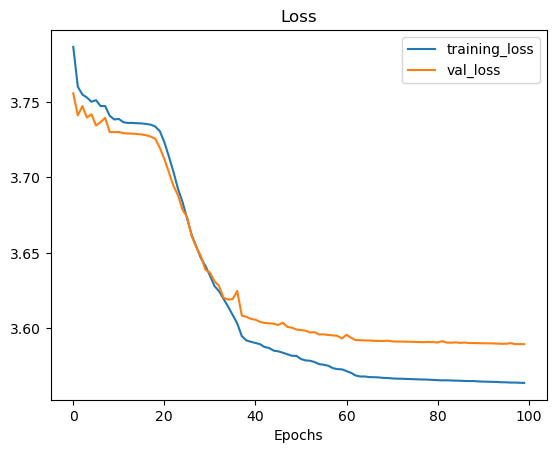

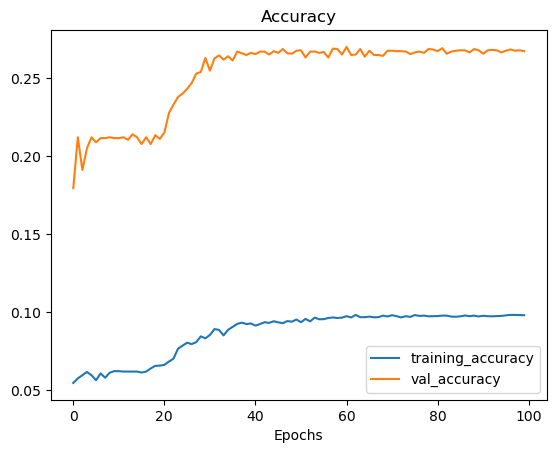

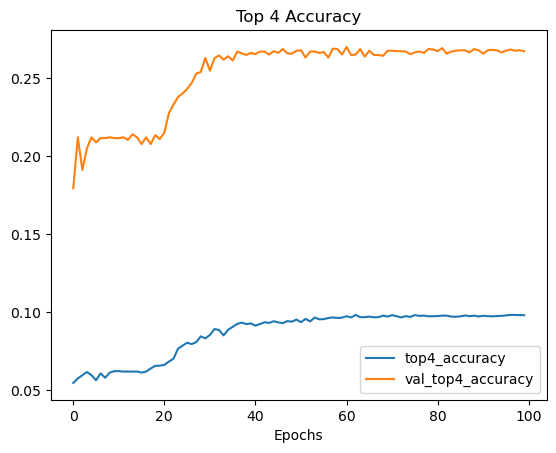

In [28]:
effnet_1_history_mood_ft = fine_tune(effnet_1_config) #b0 0.0001

### Mood | EfficientNetV2-B3 | Learning from stratch

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_5[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 212s 548ms/step - loss: 4.2015 - accuracy: 0.0415 - top_2_accuracy: 0.1142 - top_3_accuracy: 0.1566 - top_4_accuracy: 0.1959 - ROC-AUC: 0.6938 - PR-AUC: 0.0422 - tp: 43.0000 - fp: 173.0000 - tn: 858981.0000 - fn: 14770.0000 - precision: 0.1991 - recall: 0.0029 - f1_score: 0.0277 - val_loss: 4.0102 - val_accuracy: 0.0506 - val_top_2_accuracy: 0.1007 - val_top_3_accuracy: 0.1454 - val_top_4_accuracy: 0.1824 - val_ROC-AUC: 0.6738 - val_PR-AUC: 0.0328 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0097
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.9832 - accuracy: 0.0471 - top_2_accuracy: 0.0886 - top_3_accuracy: 0.1281 - top_4_accuracy: 0.1691 - ROC-AUC: 0.6787 - PR-AUC: 0.0327 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0142INFO:tenso

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 138s 392ms/step - loss: 3.9832 - accuracy: 0.0471 - top_2_accuracy: 0.0886 - top_3_accuracy: 0.1281 - top_4_accuracy: 0.1691 - ROC-AUC: 0.6787 - PR-AUC: 0.0327 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0142 - val_loss: 3.9530 - val_accuracy: 0.0395 - val_top_2_accuracy: 0.0866 - val_top_3_accuracy: 0.1222 - val_top_4_accuracy: 0.1658 - val_ROC-AUC: 0.6949 - val_PR-AUC: 0.0340 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0056
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.9370 - accuracy: 0.0498 - top_2_accuracy: 0.0955 - top_3_accuracy: 0.1346 - top_4_accuracy: 0.1724 - ROC-AUC: 0.6854 - PR-AUC: 0.0336 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 138s 395ms/step - loss: 3.9370 - accuracy: 0.0498 - top_2_accuracy: 0.0955 - top_3_accuracy: 0.1346 - top_4_accuracy: 0.1724 - ROC-AUC: 0.6854 - PR-AUC: 0.0336 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0133 - val_loss: 3.8976 - val_accuracy: 0.0618 - val_top_2_accuracy: 0.1094 - val_top_3_accuracy: 0.1506 - val_top_4_accuracy: 0.1909 - val_ROC-AUC: 0.6944 - val_PR-AUC: 0.0364 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0082
Epoch 4/100
348/348 [==============================] - 121s 346ms/step - loss: 3.9193 - accuracy: 0.0479 - top_2_accuracy: 0.0856 - top_3_accuracy: 0.1274 - top_4_accuracy: 0.1684 - ROC-AUC: 0.6886 - PR-AUC: 0.0334 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 131s 375ms/step - loss: 3.8965 - accuracy: 0.0487 - top_2_accuracy: 0.0924 - top_3_accuracy: 0.1342 - top_4_accuracy: 0.1739 - ROC-AUC: 0.6920 - PR-AUC: 0.0342 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0113 - val_loss: 3.8086 - val_accuracy: 0.0572 - val_top_2_accuracy: 0.1018 - val_top_3_accuracy: 0.1579 - val_top_4_accuracy: 0.2028 - val_ROC-AUC: 0.7120 - val_PR-AUC: 0.0380 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0067
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.8556 - accuracy: 0.0525 - top_2_accuracy: 0.1045 - top_3_accuracy: 0.1503 - top_4_accuracy: 0.1918 - ROC-AUC: 0.7021 - PR-AUC: 0.0364 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 128s 364ms/step - loss: 3.8556 - accuracy: 0.0525 - top_2_accuracy: 0.1045 - top_3_accuracy: 0.1503 - top_4_accuracy: 0.1918 - ROC-AUC: 0.7021 - PR-AUC: 0.0364 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0127 - val_loss: 3.8009 - val_accuracy: 0.0591 - val_top_2_accuracy: 0.1182 - val_top_3_accuracy: 0.1685 - val_top_4_accuracy: 0.2230 - val_ROC-AUC: 0.7132 - val_PR-AUC: 0.0419 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0045
Epoch 7/100
348/348 [==============================] - 117s 334ms/step - loss: 3.8113 - accuracy: 0.0647 - top_2_accuracy: 0.1182 - top_3_accuracy: 0.1652 - top_4_accuracy: 0.2076 - ROC-AUC: 0.7140 - PR-AUC: 0.0417 - tp: 0.0000e+00 - fp: 1.0000 - tn: 644611.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sc

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 132s 380ms/step - loss: 3.7614 - accuracy: 0.0678 - top_2_accuracy: 0.1254 - top_3_accuracy: 0.1782 - top_4_accuracy: 0.2245 - ROC-AUC: 0.7272 - PR-AUC: 0.0446 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0201 - val_loss: 3.7208 - val_accuracy: 0.0828 - val_top_2_accuracy: 0.1356 - val_top_3_accuracy: 0.1930 - val_top_4_accuracy: 0.2458 - val_ROC-AUC: 0.7358 - val_PR-AUC: 0.0517 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0154
Epoch 9/100
348/348 [==============================] - ETA: 0s - loss: 3.7093 - accuracy: 0.0779 - top_2_accuracy: 0.1443 - top_3_accuracy: 0.1980 - top_4_accuracy: 0.2493 - ROC-AUC: 0.7405 - PR-AUC: 0.0501 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0254INFO:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 132s 377ms/step - loss: 3.7093 - accuracy: 0.0779 - top_2_accuracy: 0.1443 - top_3_accuracy: 0.1980 - top_4_accuracy: 0.2493 - ROC-AUC: 0.7405 - PR-AUC: 0.0501 - tp: 1.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11113.0000 - precision: 0.5000 - recall: 8.9977e-05 - f1_score: 0.0254 - val_loss: 3.6995 - val_accuracy: 0.0847 - val_top_2_accuracy: 0.1438 - val_top_3_accuracy: 0.2045 - val_top_4_accuracy: 0.2431 - val_ROC-AUC: 0.7422 - val_PR-AUC: 0.0503 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0209
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.6698 - accuracy: 0.0886 - top_2_accuracy: 0.1518 - top_3_accuracy: 0.2078 - top_4_accuracy: 0.2593 - ROC-AUC: 0.7486 - PR-AUC: 0.0551 - tp: 4.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11110.0000 - precision: 0.3333 - recall: 3.5991e-04 - f1_score: 0.0304INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 129s 369ms/step - loss: 3.6698 - accuracy: 0.0886 - top_2_accuracy: 0.1518 - top_3_accuracy: 0.2078 - top_4_accuracy: 0.2593 - ROC-AUC: 0.7486 - PR-AUC: 0.0551 - tp: 4.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11110.0000 - precision: 0.3333 - recall: 3.5991e-04 - f1_score: 0.0304 - val_loss: 3.6729 - val_accuracy: 0.0773 - val_top_2_accuracy: 0.1525 - val_top_3_accuracy: 0.2094 - val_top_4_accuracy: 0.2578 - val_ROC-AUC: 0.7523 - val_PR-AUC: 0.0542 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0178
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.6181 - accuracy: 0.0957 - top_2_accuracy: 0.1662 - top_3_accuracy: 0.2247 - top_4_accuracy: 0.2760 - ROC-AUC: 0.7601 - PR-AUC: 0.0609 - tp: 4.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11110.0000 - precision: 0.3077 - recall: 3.5991e-04 - f1_score: 0.0374INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 134s 384ms/step - loss: 3.6181 - accuracy: 0.0957 - top_2_accuracy: 0.1662 - top_3_accuracy: 0.2247 - top_4_accuracy: 0.2760 - ROC-AUC: 0.7601 - PR-AUC: 0.0609 - tp: 4.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11110.0000 - precision: 0.3077 - recall: 3.5991e-04 - f1_score: 0.0374 - val_loss: 3.6165 - val_accuracy: 0.0931 - val_top_2_accuracy: 0.1691 - val_top_3_accuracy: 0.2268 - val_top_4_accuracy: 0.2815 - val_ROC-AUC: 0.7627 - val_PR-AUC: 0.0611 - val_tp: 5.0000 - val_fp: 14.0000 - val_tn: 213020.0000 - val_fn: 3668.0000 - val_precision: 0.2632 - val_recall: 0.0014 - val_f1_score: 0.0227
Epoch 12/100
348/348 [==============================] - ETA: 0s - loss: 3.5699 - accuracy: 0.1076 - top_2_accuracy: 0.1817 - top_3_accuracy: 0.2389 - top_4_accuracy: 0.2932 - ROC-AUC: 0.7696 - PR-AUC: 0.0687 - tp: 12.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11102.0000 - precision: 0.5714 - recall: 0.0011 - f1_score: 0.0417INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 130s 371ms/step - loss: 3.5699 - accuracy: 0.1076 - top_2_accuracy: 0.1817 - top_3_accuracy: 0.2389 - top_4_accuracy: 0.2932 - ROC-AUC: 0.7696 - PR-AUC: 0.0687 - tp: 12.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11102.0000 - precision: 0.5714 - recall: 0.0011 - f1_score: 0.0417 - val_loss: 3.6078 - val_accuracy: 0.1086 - val_top_2_accuracy: 0.1786 - val_top_3_accuracy: 0.2382 - val_top_4_accuracy: 0.2853 - val_ROC-AUC: 0.7637 - val_PR-AUC: 0.0636 - val_tp: 4.0000 - val_fp: 18.0000 - val_tn: 213016.0000 - val_fn: 3669.0000 - val_precision: 0.1818 - val_recall: 0.0011 - val_f1_score: 0.0334
Epoch 13/100
348/348 [==============================] - 118s 336ms/step - loss: 3.5042 - accuracy: 0.1177 - top_2_accuracy: 0.1964 - top_3_accuracy: 0.2630 - top_4_accuracy: 0.3200 - ROC-AUC: 0.7828 - PR-AUC: 0.0783 - tp: 33.0000 - fp: 18.0000 - tn: 644594.0000 - fn: 11081.0000 - precision: 0.6471 - recall: 0.0030 - f1_score: 0.0519 - val_loss: 3.6221 - val_ac

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 127s 364ms/step - loss: 3.4333 - accuracy: 0.1374 - top_2_accuracy: 0.2218 - top_3_accuracy: 0.2875 - top_4_accuracy: 0.3416 - ROC-AUC: 0.7949 - PR-AUC: 0.0904 - tp: 38.0000 - fp: 35.0000 - tn: 644577.0000 - fn: 11076.0000 - precision: 0.5205 - recall: 0.0034 - f1_score: 0.0631 - val_loss: 3.5960 - val_accuracy: 0.1127 - val_top_2_accuracy: 0.1830 - val_top_3_accuracy: 0.2350 - val_top_4_accuracy: 0.2900 - val_ROC-AUC: 0.7638 - val_PR-AUC: 0.0712 - val_tp: 20.0000 - val_fp: 25.0000 - val_tn: 213009.0000 - val_fn: 3653.0000 - val_precision: 0.4444 - val_recall: 0.0054 - val_f1_score: 0.0414
Epoch 15/100
348/348 [==============================] - 119s 339ms/step - loss: 3.3422 - accuracy: 0.1533 - top_2_accuracy: 0.2432 - top_3_accuracy: 0.3111 - top_4_accuracy: 0.3704 - ROC-AUC: 0.8099 - PR-AUC: 0.1088 - tp: 86.0000 - fp: 42.0000 - tn: 644570.0000 - fn: 11028.0000 - precision: 0.6719 - recall: 0.0077 - f1_score: 0.0754 - val_loss: 3.6310 - val_

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/EfficientNetV2B0_2/assets


115/115 [==============================] - 14s 122ms/step - loss: 3.6365 - accuracy: 0.1187 - top_2_accuracy: 0.1887 - top_3_accuracy: 0.2420 - top_4_accuracy: 0.2927 - ROC-AUC: 0.7574 - PR-AUC: 0.0736 - tp: 30.0000 - fp: 53.0000 - tn: 212981.0000 - fn: 3643.0000 - precision: 0.3614 - recall: 0.0082 - f1_score: 0.0603
VALID:
 [3.6365253925323486, 0.11870405822992325, 0.18867410719394684, 0.24203647673130035, 0.29267629981040955, 0.7573826313018799, 0.0736360028386116, 30.0, 53.0, 212981.0, 3643.0, 0.3614457845687866, 0.008167710155248642, 0.060269542038440704]
116/116 [==============================] - 19s 162ms/step - loss: 4.0365 - accuracy: 0.0679 - top_2_accuracy: 0.1192 - top_3_accuracy: 0.1682 - top_4_accuracy: 0.2076 - ROC-AUC: 0.6829 - PR-AUC: 0.0396 - tp: 10.0000 - fp: 49.0000 - tn: 214493.0000 - fn: 3689.0000 - precision: 0.1695 - recall: 0.0027 - f1_score: 0.0301
TEST:
 [4.036487102508545, 0.06785617768764496, 0.11922141164541245, 0.1681535542011261, 0.2076236754655838, 0.68

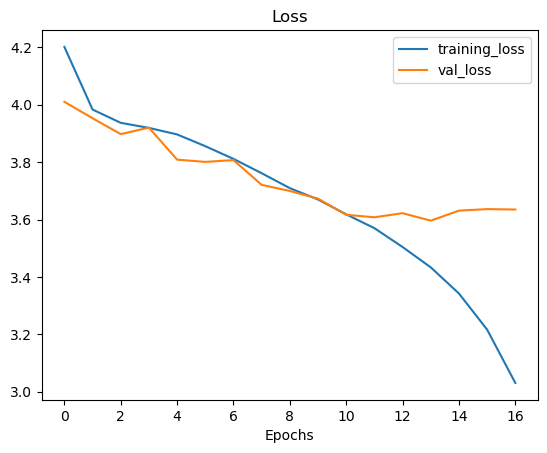

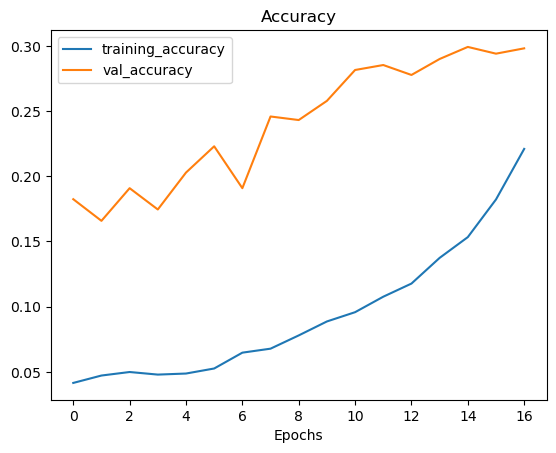

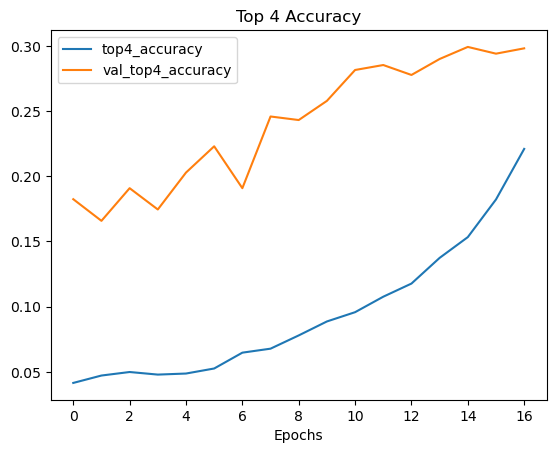

In [33]:
effnet_2_history_mood = effnet(effnet_2_config)

## Mood | Xception

### Mood | Xception | Transfer Learning

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, None, None, 728)      0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, None, None, 728)      536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, None, None, 728)      2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, None, None, 728)      536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, None, None, 728)      2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, None, None, 728)      0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, None, None, 728)      0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, None, None, 728)      0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, None, None, 728)      536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, None, None, 728)      0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, None, None, 728)      536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, None, None, 728)      2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, None, None, 728)      0         ['block12_sepconv3_bn[0][0]', 
          

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 115s 323ms/step - loss: 3.7958 - accuracy: 0.0594 - top_2_accuracy: 0.1254 - top_3_accuracy: 0.1761 - top_4_accuracy: 0.2207 - ROC-AUC: 0.7299 - PR-AUC: 0.0447 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 859154.0000 - fn: 14813.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0171 - val_loss: 3.6833 - val_accuracy: 0.0803 - val_top_2_accuracy: 0.1402 - val_top_3_accuracy: 0.1892 - val_top_4_accuracy: 0.2385 - val_ROC-AUC: 0.7456 - val_PR-AUC: 0.0497 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0218
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.6267 - accuracy: 0.0915 - top_2_accuracy: 0.1588 - top_3_accuracy: 0.2180 - top_4_accuracy: 0.2690 - ROC-AUC: 0.7586 - PR-AUC: 0.0561 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 297ms/step - loss: 3.6267 - accuracy: 0.0915 - top_2_accuracy: 0.1588 - top_3_accuracy: 0.2180 - top_4_accuracy: 0.2690 - ROC-AUC: 0.7586 - PR-AUC: 0.0561 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11114.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0256 - val_loss: 3.6132 - val_accuracy: 0.0942 - val_top_2_accuracy: 0.1530 - val_top_3_accuracy: 0.2162 - val_top_4_accuracy: 0.2684 - val_ROC-AUC: 0.7620 - val_PR-AUC: 0.0587 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0266
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.5465 - accuracy: 0.1050 - top_2_accuracy: 0.1773 - top_3_accuracy: 0.2421 - top_4_accuracy: 0.3016 - ROC-AUC: 0.7774 - PR-AUC: 0.0657 - tp: 1.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11113.0000 - precision: 1.0000 - recall: 8.9977e-05 - f1_score: 0.0306I

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 297ms/step - loss: 3.5465 - accuracy: 0.1050 - top_2_accuracy: 0.1773 - top_3_accuracy: 0.2421 - top_4_accuracy: 0.3016 - ROC-AUC: 0.7774 - PR-AUC: 0.0657 - tp: 1.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11113.0000 - precision: 1.0000 - recall: 8.9977e-05 - f1_score: 0.0306 - val_loss: 3.5760 - val_accuracy: 0.1067 - val_top_2_accuracy: 0.1816 - val_top_3_accuracy: 0.2385 - val_top_4_accuracy: 0.2880 - val_ROC-AUC: 0.7712 - val_PR-AUC: 0.0652 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0305
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.4877 - accuracy: 0.1194 - top_2_accuracy: 0.1985 - top_3_accuracy: 0.2648 - top_4_accuracy: 0.3158 - ROC-AUC: 0.7903 - PR-AUC: 0.0742 - tp: 2.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11112.0000 - precision: 0.6667 - recall: 1.7995e-04 - f1_score: 0.0375INFO:tensorfl

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 305ms/step - loss: 3.4877 - accuracy: 0.1194 - top_2_accuracy: 0.1985 - top_3_accuracy: 0.2648 - top_4_accuracy: 0.3158 - ROC-AUC: 0.7903 - PR-AUC: 0.0742 - tp: 2.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11112.0000 - precision: 0.6667 - recall: 1.7995e-04 - f1_score: 0.0375 - val_loss: 3.5525 - val_accuracy: 0.1122 - val_top_2_accuracy: 0.1764 - val_top_3_accuracy: 0.2439 - val_top_4_accuracy: 0.2968 - val_ROC-AUC: 0.7755 - val_PR-AUC: 0.0670 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0302
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.4413 - accuracy: 0.1289 - top_2_accuracy: 0.2110 - top_3_accuracy: 0.2788 - top_4_accuracy: 0.3327 - ROC-AUC: 0.7994 - PR-AUC: 0.0811 - tp: 4.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11110.0000 - precision: 0.5714 - recall: 3.5991e-04 - f1_score: 0.0430INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 297ms/step - loss: 3.4413 - accuracy: 0.1289 - top_2_accuracy: 0.2110 - top_3_accuracy: 0.2788 - top_4_accuracy: 0.3327 - ROC-AUC: 0.7994 - PR-AUC: 0.0811 - tp: 4.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11110.0000 - precision: 0.5714 - recall: 3.5991e-04 - f1_score: 0.0430 - val_loss: 3.5289 - val_accuracy: 0.1135 - val_top_2_accuracy: 0.1892 - val_top_3_accuracy: 0.2505 - val_top_4_accuracy: 0.3000 - val_ROC-AUC: 0.7809 - val_PR-AUC: 0.0711 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0321
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.4005 - accuracy: 0.1325 - top_2_accuracy: 0.2207 - top_3_accuracy: 0.2882 - top_4_accuracy: 0.3434 - ROC-AUC: 0.8077 - PR-AUC: 0.0874 - tp: 4.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11110.0000 - precision: 0.8000 - recall: 3.5991e-04 - f1_score: 0.0481INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 305ms/step - loss: 3.4005 - accuracy: 0.1325 - top_2_accuracy: 0.2207 - top_3_accuracy: 0.2882 - top_4_accuracy: 0.3434 - ROC-AUC: 0.8077 - PR-AUC: 0.0874 - tp: 4.0000 - fp: 1.0000 - tn: 644611.0000 - fn: 11110.0000 - precision: 0.8000 - recall: 3.5991e-04 - f1_score: 0.0481 - val_loss: 3.5093 - val_accuracy: 0.1220 - val_top_2_accuracy: 0.1944 - val_top_3_accuracy: 0.2597 - val_top_4_accuracy: 0.3079 - val_ROC-AUC: 0.7832 - val_PR-AUC: 0.0744 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0381
Epoch 7/100
348/348 [==============================] - ETA: 0s - loss: 3.3645 - accuracy: 0.1393 - top_2_accuracy: 0.2341 - top_3_accuracy: 0.3012 - top_4_accuracy: 0.3597 - ROC-AUC: 0.8143 - PR-AUC: 0.0936 - tp: 5.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11109.0000 - precision: 0.7143 - recall: 4.4988e-04 - f1_score: 0.0528INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 296ms/step - loss: 3.3645 - accuracy: 0.1393 - top_2_accuracy: 0.2341 - top_3_accuracy: 0.3012 - top_4_accuracy: 0.3597 - ROC-AUC: 0.8143 - PR-AUC: 0.0936 - tp: 5.0000 - fp: 2.0000 - tn: 644610.0000 - fn: 11109.0000 - precision: 0.7143 - recall: 4.4988e-04 - f1_score: 0.0528 - val_loss: 3.5012 - val_accuracy: 0.1195 - val_top_2_accuracy: 0.1985 - val_top_3_accuracy: 0.2649 - val_top_4_accuracy: 0.3120 - val_ROC-AUC: 0.7847 - val_PR-AUC: 0.0769 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0436
Epoch 8/100
348/348 [==============================] - ETA: 0s - loss: 3.3310 - accuracy: 0.1477 - top_2_accuracy: 0.2415 - top_3_accuracy: 0.3119 - top_4_accuracy: 0.3699 - ROC-AUC: 0.8208 - PR-AUC: 0.0995 - tp: 9.0000 - fp: 4.0000 - tn: 644608.0000 - fn: 11105.0000 - precision: 0.6923 - recall: 8.0979e-04 - f1_score: 0.0598INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.3310 - accuracy: 0.1477 - top_2_accuracy: 0.2415 - top_3_accuracy: 0.3119 - top_4_accuracy: 0.3699 - ROC-AUC: 0.8208 - PR-AUC: 0.0995 - tp: 9.0000 - fp: 4.0000 - tn: 644608.0000 - fn: 11105.0000 - precision: 0.6923 - recall: 8.0979e-04 - f1_score: 0.0598 - val_loss: 3.4904 - val_accuracy: 0.1261 - val_top_2_accuracy: 0.2023 - val_top_3_accuracy: 0.2674 - val_top_4_accuracy: 0.3188 - val_ROC-AUC: 0.7875 - val_PR-AUC: 0.0786 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0477
Epoch 9/100
348/348 [==============================] - ETA: 0s - loss: 3.3033 - accuracy: 0.1537 - top_2_accuracy: 0.2499 - top_3_accuracy: 0.3225 - top_4_accuracy: 0.3785 - ROC-AUC: 0.8255 - PR-AUC: 0.1053 - tp: 10.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11104.0000 - precision: 0.7692 - recall: 8.9977e-04 - f1_score: 0.0641INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 305ms/step - loss: 3.3033 - accuracy: 0.1537 - top_2_accuracy: 0.2499 - top_3_accuracy: 0.3225 - top_4_accuracy: 0.3785 - ROC-AUC: 0.8255 - PR-AUC: 0.1053 - tp: 10.0000 - fp: 3.0000 - tn: 644609.0000 - fn: 11104.0000 - precision: 0.7692 - recall: 8.9977e-04 - f1_score: 0.0641 - val_loss: 3.4820 - val_accuracy: 0.1247 - val_top_2_accuracy: 0.2034 - val_top_3_accuracy: 0.2704 - val_top_4_accuracy: 0.3183 - val_ROC-AUC: 0.7889 - val_PR-AUC: 0.0801 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3672.0000 - val_precision: 1.0000 - val_recall: 2.7226e-04 - val_f1_score: 0.0476
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.2740 - accuracy: 0.1584 - top_2_accuracy: 0.2558 - top_3_accuracy: 0.3296 - top_4_accuracy: 0.3870 - ROC-AUC: 0.8312 - PR-AUC: 0.1107 - tp: 15.0000 - fp: 5.0000 - tn: 644607.0000 - fn: 11099.0000 - precision: 0.7500 - recall: 0.0013 - f1_score: 0.0731INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 297ms/step - loss: 3.2740 - accuracy: 0.1584 - top_2_accuracy: 0.2558 - top_3_accuracy: 0.3296 - top_4_accuracy: 0.3870 - ROC-AUC: 0.8312 - PR-AUC: 0.1107 - tp: 15.0000 - fp: 5.0000 - tn: 644607.0000 - fn: 11099.0000 - precision: 0.7500 - recall: 0.0013 - f1_score: 0.0731 - val_loss: 3.4759 - val_accuracy: 0.1244 - val_top_2_accuracy: 0.2015 - val_top_3_accuracy: 0.2772 - val_top_4_accuracy: 0.3313 - val_ROC-AUC: 0.7901 - val_PR-AUC: 0.0816 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0495
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.2482 - accuracy: 0.1640 - top_2_accuracy: 0.2644 - top_3_accuracy: 0.3393 - top_4_accuracy: 0.3984 - ROC-AUC: 0.8350 - PR-AUC: 0.1160 - tp: 12.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11102.0000 - precision: 0.6000 - recall: 0.0011 - f1_score: 0.0768INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.2482 - accuracy: 0.1640 - top_2_accuracy: 0.2644 - top_3_accuracy: 0.3393 - top_4_accuracy: 0.3984 - ROC-AUC: 0.8350 - PR-AUC: 0.1160 - tp: 12.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11102.0000 - precision: 0.6000 - recall: 0.0011 - f1_score: 0.0768 - val_loss: 3.4735 - val_accuracy: 0.1255 - val_top_2_accuracy: 0.2072 - val_top_3_accuracy: 0.2753 - val_top_4_accuracy: 0.3281 - val_ROC-AUC: 0.7903 - val_PR-AUC: 0.0814 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0533
Epoch 12/100
348/348 [==============================] - ETA: 0s - loss: 3.2236 - accuracy: 0.1709 - top_2_accuracy: 0.2714 - top_3_accuracy: 0.3461 - top_4_accuracy: 0.4074 - ROC-AUC: 0.8389 - PR-AUC: 0.1219 - tp: 18.0000 - fp: 4.0000 - tn: 644608.0000 - fn: 11096.0000 - precision: 0.8182 - recall: 0.0016 - f1_score: 0.0839INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 304ms/step - loss: 3.2236 - accuracy: 0.1709 - top_2_accuracy: 0.2714 - top_3_accuracy: 0.3461 - top_4_accuracy: 0.4074 - ROC-AUC: 0.8389 - PR-AUC: 0.1219 - tp: 18.0000 - fp: 4.0000 - tn: 644608.0000 - fn: 11096.0000 - precision: 0.8182 - recall: 0.0016 - f1_score: 0.0839 - val_loss: 3.4686 - val_accuracy: 0.1334 - val_top_2_accuracy: 0.2085 - val_top_3_accuracy: 0.2725 - val_top_4_accuracy: 0.3248 - val_ROC-AUC: 0.7910 - val_PR-AUC: 0.0815 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 213030.0000 - val_fn: 3672.0000 - val_precision: 0.2000 - val_recall: 2.7226e-04 - val_f1_score: 0.0504
Epoch 13/100
348/348 [==============================] - ETA: 0s - loss: 3.2004 - accuracy: 0.1757 - top_2_accuracy: 0.2787 - top_3_accuracy: 0.3525 - top_4_accuracy: 0.4101 - ROC-AUC: 0.8428 - PR-AUC: 0.1274 - tp: 27.0000 - fp: 7.0000 - tn: 644605.0000 - fn: 11087.0000 - precision: 0.7941 - recall: 0.0024 - f1_score: 0.0905INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 296ms/step - loss: 3.2004 - accuracy: 0.1757 - top_2_accuracy: 0.2787 - top_3_accuracy: 0.3525 - top_4_accuracy: 0.4101 - ROC-AUC: 0.8428 - PR-AUC: 0.1274 - tp: 27.0000 - fp: 7.0000 - tn: 644605.0000 - fn: 11087.0000 - precision: 0.7941 - recall: 0.0024 - f1_score: 0.0905 - val_loss: 3.4664 - val_accuracy: 0.1285 - val_top_2_accuracy: 0.2129 - val_top_3_accuracy: 0.2788 - val_top_4_accuracy: 0.3341 - val_ROC-AUC: 0.7908 - val_PR-AUC: 0.0841 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3671.0000 - val_precision: 0.6667 - val_recall: 5.4451e-04 - val_f1_score: 0.0510
Epoch 14/100
348/348 [==============================] - ETA: 0s - loss: 3.1793 - accuracy: 0.1789 - top_2_accuracy: 0.2836 - top_3_accuracy: 0.3604 - top_4_accuracy: 0.4207 - ROC-AUC: 0.8459 - PR-AUC: 0.1317 - tp: 28.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11086.0000 - precision: 0.7568 - recall: 0.0025 - f1_score: 0.0951INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.1793 - accuracy: 0.1789 - top_2_accuracy: 0.2836 - top_3_accuracy: 0.3604 - top_4_accuracy: 0.4207 - ROC-AUC: 0.8459 - PR-AUC: 0.1317 - tp: 28.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11086.0000 - precision: 0.7568 - recall: 0.0025 - f1_score: 0.0951 - val_loss: 3.4577 - val_accuracy: 0.1307 - val_top_2_accuracy: 0.2148 - val_top_3_accuracy: 0.2780 - val_top_4_accuracy: 0.3302 - val_ROC-AUC: 0.7934 - val_PR-AUC: 0.0845 - val_tp: 3.0000 - val_fp: 2.0000 - val_tn: 213032.0000 - val_fn: 3670.0000 - val_precision: 0.6000 - val_recall: 8.1677e-04 - val_f1_score: 0.0554
Epoch 15/100
348/348 [==============================] - ETA: 0s - loss: 3.1592 - accuracy: 0.1797 - top_2_accuracy: 0.2883 - top_3_accuracy: 0.3643 - top_4_accuracy: 0.4262 - ROC-AUC: 0.8494 - PR-AUC: 0.1364 - tp: 31.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11083.0000 - precision: 0.7949 - recall: 0.0028 - f1_score: 0.0975INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 305ms/step - loss: 3.1592 - accuracy: 0.1797 - top_2_accuracy: 0.2883 - top_3_accuracy: 0.3643 - top_4_accuracy: 0.4262 - ROC-AUC: 0.8494 - PR-AUC: 0.1364 - tp: 31.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11083.0000 - precision: 0.7949 - recall: 0.0028 - f1_score: 0.0975 - val_loss: 3.4556 - val_accuracy: 0.1288 - val_top_2_accuracy: 0.2192 - val_top_3_accuracy: 0.2880 - val_top_4_accuracy: 0.3371 - val_ROC-AUC: 0.7925 - val_PR-AUC: 0.0873 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 213033.0000 - val_fn: 3672.0000 - val_precision: 0.5000 - val_recall: 2.7226e-04 - val_f1_score: 0.0605
Epoch 16/100
348/348 [==============================] - ETA: 0s - loss: 3.1366 - accuracy: 0.1901 - top_2_accuracy: 0.2974 - top_3_accuracy: 0.3716 - top_4_accuracy: 0.4334 - ROC-AUC: 0.8530 - PR-AUC: 0.1423 - tp: 34.0000 - fp: 11.0000 - tn: 644601.0000 - fn: 11080.0000 - precision: 0.7556 - recall: 0.0031 - f1_score: 0.1100INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 104s 297ms/step - loss: 3.1366 - accuracy: 0.1901 - top_2_accuracy: 0.2974 - top_3_accuracy: 0.3716 - top_4_accuracy: 0.4334 - ROC-AUC: 0.8530 - PR-AUC: 0.1423 - tp: 34.0000 - fp: 11.0000 - tn: 644601.0000 - fn: 11080.0000 - precision: 0.7556 - recall: 0.0031 - f1_score: 0.1100 - val_loss: 3.4522 - val_accuracy: 0.1337 - val_top_2_accuracy: 0.2173 - val_top_3_accuracy: 0.2851 - val_top_4_accuracy: 0.3343 - val_ROC-AUC: 0.7930 - val_PR-AUC: 0.0891 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 213031.0000 - val_fn: 3668.0000 - val_precision: 0.6250 - val_recall: 0.0014 - val_f1_score: 0.0581
Epoch 17/100
348/348 [==============================] - ETA: 0s - loss: 3.1143 - accuracy: 0.1919 - top_2_accuracy: 0.3031 - top_3_accuracy: 0.3816 - top_4_accuracy: 0.4431 - ROC-AUC: 0.8565 - PR-AUC: 0.1475 - tp: 45.0000 - fp: 11.0000 - tn: 644601.0000 - fn: 11069.0000 - precision: 0.8036 - recall: 0.0040 - f1_score: 0.1177INFO:tensorflow:Assets written to: /

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.1143 - accuracy: 0.1919 - top_2_accuracy: 0.3031 - top_3_accuracy: 0.3816 - top_4_accuracy: 0.4431 - ROC-AUC: 0.8565 - PR-AUC: 0.1475 - tp: 45.0000 - fp: 11.0000 - tn: 644601.0000 - fn: 11069.0000 - precision: 0.8036 - recall: 0.0040 - f1_score: 0.1177 - val_loss: 3.4515 - val_accuracy: 0.1369 - val_top_2_accuracy: 0.2164 - val_top_3_accuracy: 0.2870 - val_top_4_accuracy: 0.3390 - val_ROC-AUC: 0.7920 - val_PR-AUC: 0.0898 - val_tp: 9.0000 - val_fp: 3.0000 - val_tn: 213031.0000 - val_fn: 3664.0000 - val_precision: 0.7500 - val_recall: 0.0025 - val_f1_score: 0.0628
Epoch 18/100
348/348 [==============================] - ETA: 0s - loss: 3.0978 - accuracy: 0.1981 - top_2_accuracy: 0.3084 - top_3_accuracy: 0.3858 - top_4_accuracy: 0.4490 - ROC-AUC: 0.8585 - PR-AUC: 0.1520 - tp: 45.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11069.0000 - precision: 0.8491 - recall: 0.0040 - f1_score: 0.1243INFO:tensorflow:Assets written to: /V

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 106s 305ms/step - loss: 3.0978 - accuracy: 0.1981 - top_2_accuracy: 0.3084 - top_3_accuracy: 0.3858 - top_4_accuracy: 0.4490 - ROC-AUC: 0.8585 - PR-AUC: 0.1520 - tp: 45.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11069.0000 - precision: 0.8491 - recall: 0.0040 - f1_score: 0.1243 - val_loss: 3.4510 - val_accuracy: 0.1228 - val_top_2_accuracy: 0.2156 - val_top_3_accuracy: 0.2840 - val_top_4_accuracy: 0.3414 - val_ROC-AUC: 0.7930 - val_PR-AUC: 0.0885 - val_tp: 7.0000 - val_fp: 5.0000 - val_tn: 213029.0000 - val_fn: 3666.0000 - val_precision: 0.5833 - val_recall: 0.0019 - val_f1_score: 0.0648
Epoch 19/100
348/348 [==============================] - 99s 284ms/step - loss: 3.0780 - accuracy: 0.2032 - top_2_accuracy: 0.3149 - top_3_accuracy: 0.3908 - top_4_accuracy: 0.4540 - ROC-AUC: 0.8617 - PR-AUC: 0.1574 - tp: 53.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11061.0000 - precision: 0.8689 - recall: 0.0048 - f1_score: 0.1334 - val_loss: 3.4561 - val_accur

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.0606 - accuracy: 0.2036 - top_2_accuracy: 0.3204 - top_3_accuracy: 0.3982 - top_4_accuracy: 0.4626 - ROC-AUC: 0.8640 - PR-AUC: 0.1618 - tp: 53.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11061.0000 - precision: 0.8548 - recall: 0.0048 - f1_score: 0.1323 - val_loss: 3.4427 - val_accuracy: 0.1394 - val_top_2_accuracy: 0.2224 - val_top_3_accuracy: 0.2908 - val_top_4_accuracy: 0.3411 - val_ROC-AUC: 0.7945 - val_PR-AUC: 0.0908 - val_tp: 9.0000 - val_fp: 3.0000 - val_tn: 213031.0000 - val_fn: 3664.0000 - val_precision: 0.7500 - val_recall: 0.0025 - val_f1_score: 0.0760
Epoch 21/100
348/348 [==============================] - ETA: 0s - loss: 3.0448 - accuracy: 0.2092 - top_2_accuracy: 0.3258 - top_3_accuracy: 0.4027 - top_4_accuracy: 0.4613 - ROC-AUC: 0.8666 - PR-AUC: 0.1664 - tp: 60.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11054.0000 - precision: 0.8824 - recall: 0.0054 - f1_score: 0.1417INFO:tensorflow:Assets written to: /Vo

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 103s 296ms/step - loss: 3.0448 - accuracy: 0.2092 - top_2_accuracy: 0.3258 - top_3_accuracy: 0.4027 - top_4_accuracy: 0.4613 - ROC-AUC: 0.8666 - PR-AUC: 0.1664 - tp: 60.0000 - fp: 8.0000 - tn: 644604.0000 - fn: 11054.0000 - precision: 0.8824 - recall: 0.0054 - f1_score: 0.1417 - val_loss: 3.4346 - val_accuracy: 0.1397 - val_top_2_accuracy: 0.2268 - val_top_3_accuracy: 0.2916 - val_top_4_accuracy: 0.3452 - val_ROC-AUC: 0.7960 - val_PR-AUC: 0.0934 - val_tp: 12.0000 - val_fp: 6.0000 - val_tn: 213028.0000 - val_fn: 3661.0000 - val_precision: 0.6667 - val_recall: 0.0033 - val_f1_score: 0.0729
Epoch 22/100
348/348 [==============================] - 99s 284ms/step - loss: 3.0266 - accuracy: 0.2111 - top_2_accuracy: 0.3283 - top_3_accuracy: 0.4089 - top_4_accuracy: 0.4741 - ROC-AUC: 0.8690 - PR-AUC: 0.1712 - tp: 72.0000 - fp: 9.0000 - tn: 644603.0000 - fn: 11042.0000 - precision: 0.8889 - recall: 0.0065 - f1_score: 0.1470 - val_loss: 3.4414 - val_accu

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL/assets


115/115 [==============================] - 25s 216ms/step - loss: 3.4359 - accuracy: 0.1465 - top_2_accuracy: 0.2325 - top_3_accuracy: 0.2976 - top_4_accuracy: 0.3477 - ROC-AUC: 0.7947 - PR-AUC: 0.0943 - tp: 13.0000 - fp: 11.0000 - tn: 213023.0000 - fn: 3660.0000 - precision: 0.5417 - recall: 0.0035 - f1_score: 0.0749
VALID:
 [3.4358699321746826, 0.14647427201271057, 0.23250748217105865, 0.297576904296875, 0.3476721942424774, 0.7946677207946777, 0.094342902302742, 13.0, 11.0, 213023.0, 3660.0, 0.5416666865348816, 0.0035393410362303257, 0.07491692900657654]
116/116 [==============================] - 26s 224ms/step - loss: 3.4460 - accuracy: 0.1403 - top_2_accuracy: 0.2265 - top_3_accuracy: 0.2941 - top_4_accuracy: 0.3487 - ROC-AUC: 0.7937 - PR-AUC: 0.0915 - tp: 14.0000 - fp: 13.0000 - tn: 214529.0000 - fn: 3685.0000 - precision: 0.5185 - recall: 0.0038 - f1_score: 0.0635
TEST:
 [3.4460010528564453, 0.1403081864118576, 0.2265477180480957, 0.2941335439682007, 0.34874290227890015, 0.793735

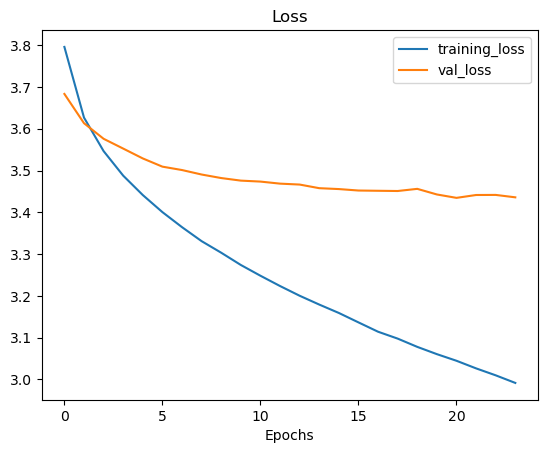

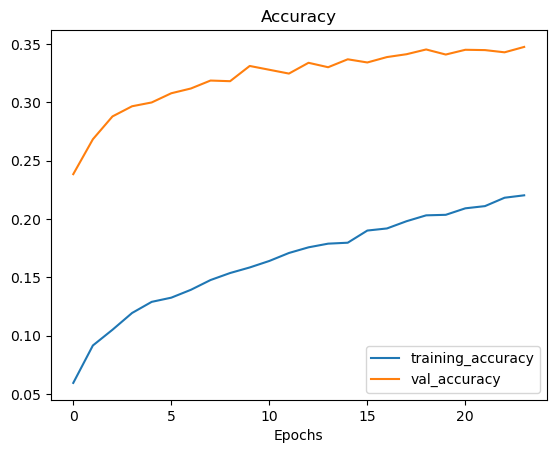

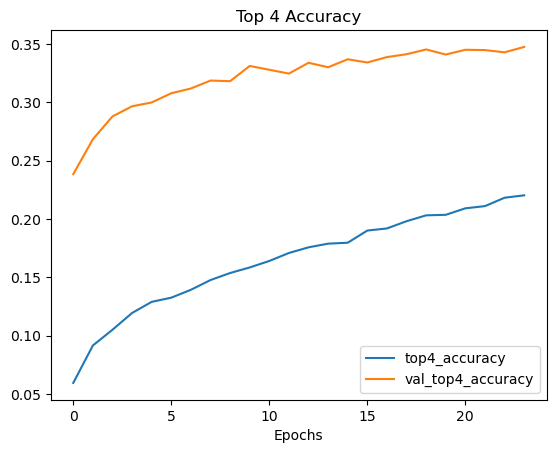

In [29]:
xception_1_history_mood = xception(xception_1_config)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 2048)              0         
 oling2D)                                                        
                                                                 
 dense_2 (Dense)             (None, 59)                120891    
                                                                 
 activation_2 (Activation)   (None, 59)                0         
                                                                 
Total params: 20982371 (80.04 MB)
Trainable params: 2092784

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 310s 870ms/step - loss: 3.4684 - accuracy: 0.1257 - top_2_accuracy: 0.2119 - top_3_accuracy: 0.2764 - top_4_accuracy: 0.3322 - ROC-AUC: 0.7914 - PR-AUC: 0.0823 - tp: 42.0000 - fp: 51.0000 - tn: 859103.0000 - fn: 14771.0000 - precision: 0.4516 - recall: 0.0028 - f1_score: 0.0548 - val_loss: 3.4763 - val_accuracy: 0.1269 - val_top_2_accuracy: 0.2080 - val_top_3_accuracy: 0.2791 - val_top_4_accuracy: 0.3376 - val_ROC-AUC: 0.7906 - val_PR-AUC: 0.0870 - val_tp: 39.0000 - val_fp: 54.0000 - val_tn: 212980.0000 - val_fn: 3634.0000 - val_precision: 0.4194 - val_recall: 0.0106 - val_f1_score: 0.0534 - lr: 1.0000e-04
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.2101 - accuracy: 0.1764 - top_2_accuracy: 0.2751 - top_3_accuracy: 0.3487 - top_4_accuracy: 0.4072 - ROC-AUC: 0.8335 - PR-AUC: 0.1303 - tp: 162.0000 - fp: 106.0000 - tn: 644506.0000 - fn: 10952.0000 - precision: 0.6045 - recall: 0.0146 - f1_score: 0.0949INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_checkpoints/cp.ckpt/assets


348/348 [==============================] - 297s 852ms/step - loss: 3.2101 - accuracy: 0.1764 - top_2_accuracy: 0.2751 - top_3_accuracy: 0.3487 - top_4_accuracy: 0.4072 - ROC-AUC: 0.8335 - PR-AUC: 0.1303 - tp: 162.0000 - fp: 106.0000 - tn: 644506.0000 - fn: 10952.0000 - precision: 0.6045 - recall: 0.0146 - f1_score: 0.0949 - val_loss: 3.3389 - val_accuracy: 0.1617 - val_top_2_accuracy: 0.2516 - val_top_3_accuracy: 0.3191 - val_top_4_accuracy: 0.3724 - val_ROC-AUC: 0.8091 - val_PR-AUC: 0.1155 - val_tp: 49.0000 - val_fp: 36.0000 - val_tn: 212998.0000 - val_fn: 3624.0000 - val_precision: 0.5765 - val_recall: 0.0133 - val_f1_score: 0.0812 - lr: 1.0000e-04
Epoch 3/100
348/348 [==============================] - 289s 828ms/step - loss: 2.9625 - accuracy: 0.2255 - top_2_accuracy: 0.3391 - top_3_accuracy: 0.4211 - top_4_accuracy: 0.4865 - ROC-AUC: 0.8635 - PR-AUC: 0.1874 - tp: 411.0000 - fp: 224.0000 - tn: 644388.0000 - fn: 10703.0000 - precision: 0.6472 - recall: 0.0370 - f1_score: 0.1472 - val

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_1_TL_FT/assets


115/115 [==============================] - 26s 217ms/step - loss: 3.8871 - accuracy: 0.1819 - top_2_accuracy: 0.2761 - top_3_accuracy: 0.3477 - top_4_accuracy: 0.3994 - ROC-AUC: 0.7760 - PR-AUC: 0.1319 - tp: 351.0000 - fp: 725.0000 - tn: 212309.0000 - fn: 3322.0000 - precision: 0.3262 - recall: 0.0956 - f1_score: 0.1329
VALID:
 [3.8871068954467773, 0.18186768889427185, 0.2760685980319977, 0.3476721942424774, 0.3994010388851166, 0.7760075330734253, 0.13194838166236877, 351.0, 725.0, 212309.0, 3322.0, 0.3262081742286682, 0.09556221216917038, 0.13289879262447357]
116/116 [==============================] - 26s 224ms/step - loss: 3.8710 - accuracy: 0.1855 - top_2_accuracy: 0.2776 - top_3_accuracy: 0.3406 - top_4_accuracy: 0.3966 - ROC-AUC: 0.7833 - PR-AUC: 0.1314 - tp: 341.0000 - fp: 674.0000 - tn: 213868.0000 - fn: 3358.0000 - precision: 0.3360 - recall: 0.0922 - f1_score: 0.1191
TEST:
 [3.871032953262329, 0.1854555308818817, 0.2776426076889038, 0.3406326174736023, 0.3965936601161957, 0.78

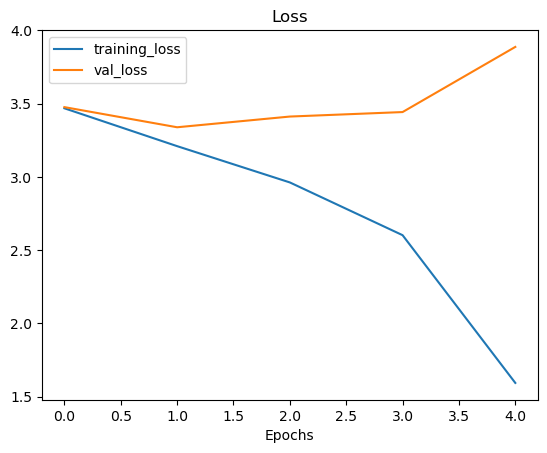

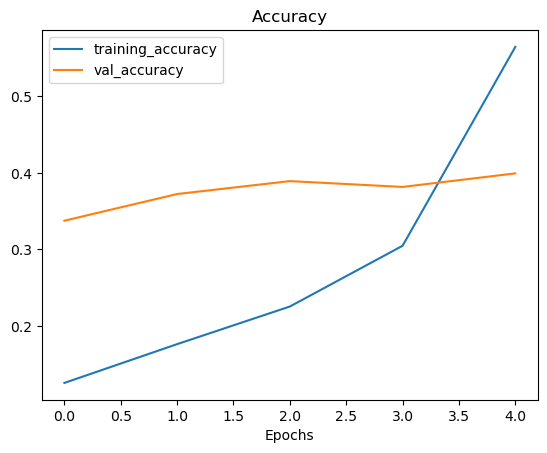

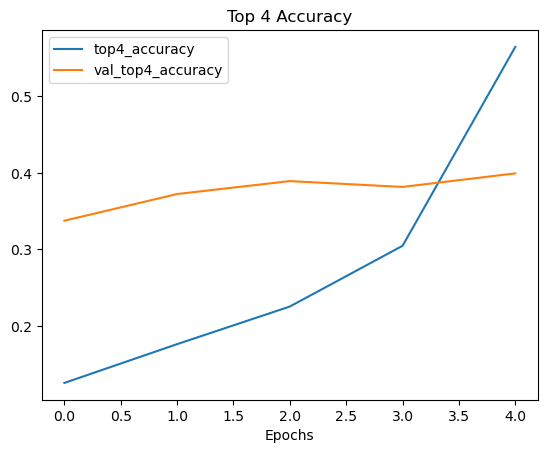

In [30]:
xception_1_history_mood_ft = fine_tune(xception_1_config)

### Mood | Xception | Learning from stratch

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, None, None, 728)      0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, None, None, 728)      536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, None, None, 728)      2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, None, None, 728)      536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, None, None, 728)      2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, None, None, 728)      0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, None, None, 728)      2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_19 (Add)                (None, None, None, 728)      0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_18[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, None, None, 728)      0         ['add_19[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, None, None, 728)      536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, None, None, 728)      0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, None, None, 728)      536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, None, None, 728)      2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_22 (A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 342s 954ms/step - loss: 3.6738 - accuracy: 0.0924 - top_2_accuracy: 0.1496 - top_3_accuracy: 0.2048 - top_4_accuracy: 0.2542 - ROC-AUC: 0.7312 - PR-AUC: 0.0520 - tp: 27.0000 - fp: 91.0000 - tn: 859063.0000 - fn: 14786.0000 - precision: 0.2288 - recall: 0.0018 - f1_score: 0.0333 - val_loss: 3.5756 - val_accuracy: 0.1075 - val_top_2_accuracy: 0.1783 - val_top_3_accuracy: 0.2396 - val_top_4_accuracy: 0.2859 - val_ROC-AUC: 0.7709 - val_PR-AUC: 0.0682 - val_tp: 4.0000 - val_fp: 9.0000 - val_tn: 213025.0000 - val_fn: 3669.0000 - val_precision: 0.3077 - val_recall: 0.0011 - val_f1_score: 0.0351
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.3007 - accuracy: 0.1641 - top_2_accuracy: 0.2568 - top_3_accuracy: 0.3276 - top_4_accuracy: 0.3853 - ROC-AUC: 0.8181 - PR-AUC: 0.1117 - tp: 47.0000 - fp: 34.0000 - tn: 644578.0000 - fn: 11067.0000 - precision: 0.5802 - recall: 0.0042 - f1_score: 0.0742INFO:tensorflow:Assets written to: /V

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 316s 905ms/step - loss: 3.3007 - accuracy: 0.1641 - top_2_accuracy: 0.2568 - top_3_accuracy: 0.3276 - top_4_accuracy: 0.3853 - ROC-AUC: 0.8181 - PR-AUC: 0.1117 - tp: 47.0000 - fp: 34.0000 - tn: 644578.0000 - fn: 11067.0000 - precision: 0.5802 - recall: 0.0042 - f1_score: 0.0742 - val_loss: 3.4989 - val_accuracy: 0.1239 - val_top_2_accuracy: 0.2015 - val_top_3_accuracy: 0.2646 - val_top_4_accuracy: 0.3237 - val_ROC-AUC: 0.7853 - val_PR-AUC: 0.0770 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 213030.0000 - val_fn: 3671.0000 - val_precision: 0.3333 - val_recall: 5.4451e-04 - val_f1_score: 0.0448
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 2.8680 - accuracy: 0.2800 - top_2_accuracy: 0.3948 - top_3_accuracy: 0.4739 - top_4_accuracy: 0.5322 - ROC-AUC: 0.8781 - PR-AUC: 0.2289 - tp: 213.0000 - fp: 46.0000 - tn: 644566.0000 - fn: 10901.0000 - precision: 0.8224 - recall: 0.0192 - f1_score: 0.1569INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 310s 890ms/step - loss: 2.8680 - accuracy: 0.2800 - top_2_accuracy: 0.3948 - top_3_accuracy: 0.4739 - top_4_accuracy: 0.5322 - ROC-AUC: 0.8781 - PR-AUC: 0.2289 - tp: 213.0000 - fp: 46.0000 - tn: 644566.0000 - fn: 10901.0000 - precision: 0.8224 - recall: 0.0192 - f1_score: 0.1569 - val_loss: 3.4805 - val_accuracy: 0.1418 - val_top_2_accuracy: 0.2181 - val_top_3_accuracy: 0.2826 - val_top_4_accuracy: 0.3341 - val_ROC-AUC: 0.7877 - val_PR-AUC: 0.0933 - val_tp: 35.0000 - val_fp: 36.0000 - val_tn: 212998.0000 - val_fn: 3638.0000 - val_precision: 0.4930 - val_recall: 0.0095 - val_f1_score: 0.0626
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 2.1525 - accuracy: 0.5048 - top_2_accuracy: 0.6321 - top_3_accuracy: 0.7065 - top_4_accuracy: 0.7555 - ROC-AUC: 0.9479 - PR-AUC: 0.5157 - tp: 886.0000 - fp: 55.0000 - tn: 644557.0000 - fn: 10228.0000 - precision: 0.9416 - recall: 0.0797 - f1_score: 0.3621INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 310s 889ms/step - loss: 2.1525 - accuracy: 0.5048 - top_2_accuracy: 0.6321 - top_3_accuracy: 0.7065 - top_4_accuracy: 0.7555 - ROC-AUC: 0.9479 - PR-AUC: 0.5157 - tp: 886.0000 - fp: 55.0000 - tn: 644557.0000 - fn: 10228.0000 - precision: 0.9416 - recall: 0.0797 - f1_score: 0.3621 - val_loss: 3.4777 - val_accuracy: 0.1359 - val_top_2_accuracy: 0.2197 - val_top_3_accuracy: 0.2834 - val_top_4_accuracy: 0.3313 - val_ROC-AUC: 0.7932 - val_PR-AUC: 0.0927 - val_tp: 43.0000 - val_fp: 36.0000 - val_tn: 212998.0000 - val_fn: 3630.0000 - val_precision: 0.5443 - val_recall: 0.0117 - val_f1_score: 0.0673
Epoch 5/100
348/348 [==============================] - 305s 874ms/step - loss: 1.1804 - accuracy: 0.8232 - top_2_accuracy: 0.8952 - top_3_accuracy: 0.9249 - top_4_accuracy: 0.9419 - ROC-AUC: 0.9916 - PR-AUC: 0.8758 - tp: 4063.0000 - fp: 44.0000 - tn: 644568.0000 - fn: 7051.0000 - precision: 0.9893 - recall: 0.3656 - f1_score: 0.7394 - val_loss: 3.5317 - val

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/Xception_2/assets


115/115 [==============================] - 28s 240ms/step - loss: 3.5781 - accuracy: 0.1465 - top_2_accuracy: 0.2333 - top_3_accuracy: 0.2973 - top_4_accuracy: 0.3485 - ROC-AUC: 0.7772 - PR-AUC: 0.0994 - tp: 138.0000 - fp: 217.0000 - tn: 212817.0000 - fn: 3535.0000 - precision: 0.3887 - recall: 0.0376 - f1_score: 0.0861
VALID:
 [3.5780980587005615, 0.14647427201271057, 0.23332425951957703, 0.2973046600818634, 0.348488986492157, 0.7772160172462463, 0.09941659867763519, 138.0, 217.0, 212817.0, 3535.0, 0.3887324035167694, 0.03757146745920181, 0.0861314907670021]
116/116 [==============================] - 30s 261ms/step - loss: 4.2333 - accuracy: 0.0746 - top_2_accuracy: 0.1187 - top_3_accuracy: 0.1695 - top_4_accuracy: 0.2125 - ROC-AUC: 0.6773 - PR-AUC: 0.0424 - tp: 35.0000 - fp: 184.0000 - tn: 214358.0000 - fn: 3664.0000 - precision: 0.1598 - recall: 0.0095 - f1_score: 0.0378
TEST:
 [4.233280658721924, 0.0746147632598877, 0.11868072301149368, 0.1695052683353424, 0.21248985826969147, 0.67

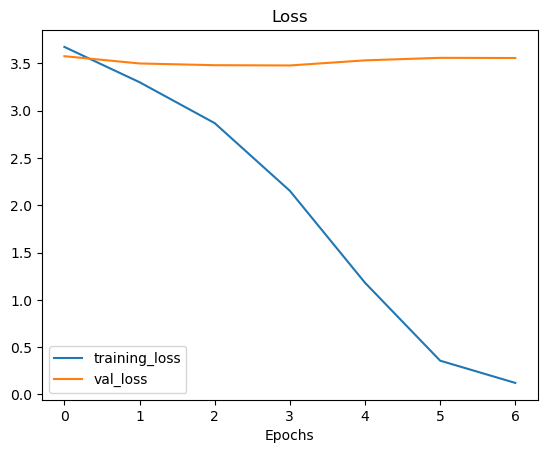

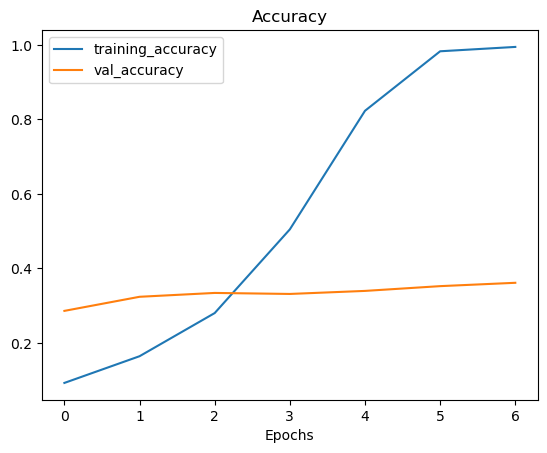

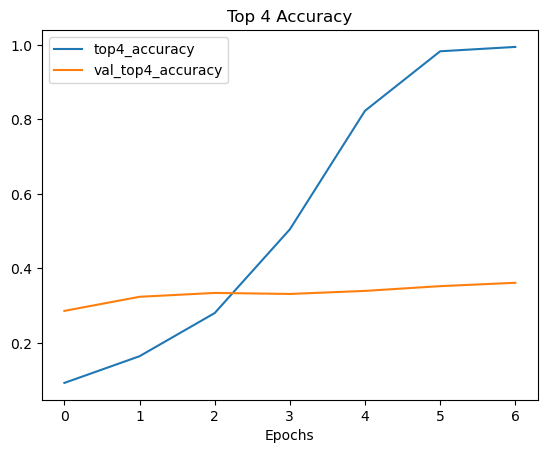

In [34]:
# Model 2
xception_2_history_mood = xception(xception_2_config)

## Mood | Densenet201

### Mood | Densenet201 | Transfer Learning

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, None, None, 160)      640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, None, None, 160)      0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, None, None, 128)      20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, None, None, 128)      512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, None, None, 160)      0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, None, None, 288)      0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, None, None, 256)      0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, None, None, 256)      1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, None, None, 128)      32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, None, None, 384)      0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, None, None, 384)      1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, None, None, 384)      0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, None, None, 512)      0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, None, None, 512)      2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, None, None, 512)      0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, None, None, 640)      0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, None, None, 640)      2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, None, None, 640)      0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, None, None, 768)      0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, None, None, 768)      3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, None, None, 896)      0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, None, None, 896)      3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, None, None, 1024)     0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, None, None, 1024)     4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, None, None, 1152)     0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, None, None, 1280)     0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, None, None, 1408)     0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, None, None, 128)      225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, None, None, 992)      0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, None, None, 992)      3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, None, None, 992)      0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, None, None, 32)       36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, None, None, 1120)     0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, None, None, 1120)     4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, None, None, 1120)     0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, None, None, 1248)     0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, None, None, 1248)     4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, None, None, 1376)     0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, None, None, 1376)     5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, None, None, 1504)     0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, None, None, 1504)     6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, None, None, 1632)     0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, None, None, 1760)     0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, None, None, 128)      512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, None, None, 1888)     0         ['conv5_block30_concat[0][0]',
 atenate) 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 139s 385ms/step - loss: 4.2472 - accuracy: 0.0479 - top_2_accuracy: 0.0911 - top_3_accuracy: 0.1333 - top_4_accuracy: 0.1711 - ROC-AUC: 0.6628 - PR-AUC: 0.0321 - tp: 2.0000 - fp: 140.0000 - tn: 644472.0000 - fn: 11112.0000 - precision: 0.0141 - recall: 1.7995e-04 - f1_score: 0.0181 - val_loss: 3.9827 - val_accuracy: 0.0689 - val_top_2_accuracy: 0.1217 - val_top_3_accuracy: 0.1710 - val_top_4_accuracy: 0.2107 - val_ROC-AUC: 0.6957 - val_PR-AUC: 0.0406 - val_tp: 6.0000 - val_fp: 12.0000 - val_tn: 213022.0000 - val_fn: 3667.0000 - val_precision: 0.3333 - val_recall: 0.0016 - val_f1_score: 0.0221
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.8798 - accuracy: 0.0761 - top_2_accuracy: 0.1340 - top_3_accuracy: 0.1822 - top_4_accuracy: 0.2247 - ROC-AUC: 0.7153 - PR-AUC: 0.0454 - tp: 10.0000 - fp: 38.0000 - tn: 644574.0000 - fn: 11104.0000 - precision: 0.2083 - recall: 8.9977e-04 - f1_score: 0.0296INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 128s 366ms/step - loss: 3.8798 - accuracy: 0.0761 - top_2_accuracy: 0.1340 - top_3_accuracy: 0.1822 - top_4_accuracy: 0.2247 - ROC-AUC: 0.7153 - PR-AUC: 0.0454 - tp: 10.0000 - fp: 38.0000 - tn: 644574.0000 - fn: 11104.0000 - precision: 0.2083 - recall: 8.9977e-04 - f1_score: 0.0296 - val_loss: 3.8639 - val_accuracy: 0.0743 - val_top_2_accuracy: 0.1345 - val_top_3_accuracy: 0.1846 - val_top_4_accuracy: 0.2311 - val_ROC-AUC: 0.7136 - val_PR-AUC: 0.0450 - val_tp: 2.0000 - val_fp: 12.0000 - val_tn: 213022.0000 - val_fn: 3671.0000 - val_precision: 0.1429 - val_recall: 5.4451e-04 - val_f1_score: 0.0319
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.7355 - accuracy: 0.0929 - top_2_accuracy: 0.1611 - top_3_accuracy: 0.2152 - top_4_accuracy: 0.2600 - ROC-AUC: 0.7413 - PR-AUC: 0.0556 - tp: 18.0000 - fp: 46.0000 - tn: 644566.0000 - fn: 11096.0000 - precision: 0.2812 - recall: 0.0016 - f1_score: 0.0412INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 130s 371ms/step - loss: 3.7355 - accuracy: 0.0929 - top_2_accuracy: 0.1611 - top_3_accuracy: 0.2152 - top_4_accuracy: 0.2600 - ROC-AUC: 0.7413 - PR-AUC: 0.0556 - tp: 18.0000 - fp: 46.0000 - tn: 644566.0000 - fn: 11096.0000 - precision: 0.2812 - recall: 0.0016 - f1_score: 0.0412 - val_loss: 3.7817 - val_accuracy: 0.0852 - val_top_2_accuracy: 0.1544 - val_top_3_accuracy: 0.2064 - val_top_4_accuracy: 0.2603 - val_ROC-AUC: 0.7355 - val_PR-AUC: 0.0538 - val_tp: 5.0000 - val_fp: 15.0000 - val_tn: 213019.0000 - val_fn: 3668.0000 - val_precision: 0.2500 - val_recall: 0.0014 - val_f1_score: 0.0322
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.6337 - accuracy: 0.1081 - top_2_accuracy: 0.1779 - top_3_accuracy: 0.2357 - top_4_accuracy: 0.2850 - ROC-AUC: 0.7621 - PR-AUC: 0.0645 - tp: 19.0000 - fp: 39.0000 - tn: 644573.0000 - fn: 11095.0000 - precision: 0.3276 - recall: 0.0017 - f1_score: 0.0500INFO:tensorflow:Assets written to: /

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 130s 373ms/step - loss: 3.6337 - accuracy: 0.1081 - top_2_accuracy: 0.1779 - top_3_accuracy: 0.2357 - top_4_accuracy: 0.2850 - ROC-AUC: 0.7621 - PR-AUC: 0.0645 - tp: 19.0000 - fp: 39.0000 - tn: 644573.0000 - fn: 11095.0000 - precision: 0.3276 - recall: 0.0017 - f1_score: 0.0500 - val_loss: 3.7150 - val_accuracy: 0.0964 - val_top_2_accuracy: 0.1661 - val_top_3_accuracy: 0.2227 - val_top_4_accuracy: 0.2739 - val_ROC-AUC: 0.7505 - val_PR-AUC: 0.0601 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 213019.0000 - val_fn: 3664.0000 - val_precision: 0.3750 - val_recall: 0.0025 - val_f1_score: 0.0380
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.5503 - accuracy: 0.1162 - top_2_accuracy: 0.1924 - top_3_accuracy: 0.2530 - top_4_accuracy: 0.3031 - ROC-AUC: 0.7780 - PR-AUC: 0.0727 - tp: 22.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11092.0000 - precision: 0.3284 - recall: 0.0020 - f1_score: 0.0553INFO:tensorflow:Assets written to: /

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 136s 389ms/step - loss: 3.5503 - accuracy: 0.1162 - top_2_accuracy: 0.1924 - top_3_accuracy: 0.2530 - top_4_accuracy: 0.3031 - ROC-AUC: 0.7780 - PR-AUC: 0.0727 - tp: 22.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11092.0000 - precision: 0.3284 - recall: 0.0020 - f1_score: 0.0553 - val_loss: 3.6890 - val_accuracy: 0.0947 - val_top_2_accuracy: 0.1666 - val_top_3_accuracy: 0.2243 - val_top_4_accuracy: 0.2785 - val_ROC-AUC: 0.7512 - val_PR-AUC: 0.0601 - val_tp: 8.0000 - val_fp: 10.0000 - val_tn: 213024.0000 - val_fn: 3665.0000 - val_precision: 0.4444 - val_recall: 0.0022 - val_f1_score: 0.0435
Epoch 6/100
348/348 [==============================] - ETA: 0s - loss: 3.4824 - accuracy: 0.1279 - top_2_accuracy: 0.2064 - top_3_accuracy: 0.2714 - top_4_accuracy: 0.3286 - ROC-AUC: 0.7894 - PR-AUC: 0.0815 - tp: 37.0000 - fp: 43.0000 - tn: 644569.0000 - fn: 11077.0000 - precision: 0.4625 - recall: 0.0033 - f1_score: 0.0646INFO:tensorflow:Assets written to: /

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 139s 397ms/step - loss: 3.4824 - accuracy: 0.1279 - top_2_accuracy: 0.2064 - top_3_accuracy: 0.2714 - top_4_accuracy: 0.3286 - ROC-AUC: 0.7894 - PR-AUC: 0.0815 - tp: 37.0000 - fp: 43.0000 - tn: 644569.0000 - fn: 11077.0000 - precision: 0.4625 - recall: 0.0033 - f1_score: 0.0646 - val_loss: 3.6510 - val_accuracy: 0.1092 - val_top_2_accuracy: 0.1726 - val_top_3_accuracy: 0.2360 - val_top_4_accuracy: 0.2916 - val_ROC-AUC: 0.7603 - val_PR-AUC: 0.0678 - val_tp: 18.0000 - val_fp: 21.0000 - val_tn: 213013.0000 - val_fn: 3655.0000 - val_precision: 0.4615 - val_recall: 0.0049 - val_f1_score: 0.0433
Epoch 7/100
348/348 [==============================] - ETA: 0s - loss: 3.4213 - accuracy: 0.1375 - top_2_accuracy: 0.2215 - top_3_accuracy: 0.2859 - top_4_accuracy: 0.3467 - ROC-AUC: 0.7998 - PR-AUC: 0.0901 - tp: 47.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11067.0000 - precision: 0.5109 - recall: 0.0042 - f1_score: 0.0692INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 135s 385ms/step - loss: 3.4213 - accuracy: 0.1375 - top_2_accuracy: 0.2215 - top_3_accuracy: 0.2859 - top_4_accuracy: 0.3467 - ROC-AUC: 0.7998 - PR-AUC: 0.0901 - tp: 47.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11067.0000 - precision: 0.5109 - recall: 0.0042 - f1_score: 0.0692 - val_loss: 3.6168 - val_accuracy: 0.1097 - val_top_2_accuracy: 0.1840 - val_top_3_accuracy: 0.2456 - val_top_4_accuracy: 0.2998 - val_ROC-AUC: 0.7653 - val_PR-AUC: 0.0695 - val_tp: 14.0000 - val_fp: 16.0000 - val_tn: 213018.0000 - val_fn: 3659.0000 - val_precision: 0.4667 - val_recall: 0.0038 - val_f1_score: 0.0480
Epoch 8/100
348/348 [==============================] - ETA: 0s - loss: 3.3703 - accuracy: 0.1450 - top_2_accuracy: 0.2326 - top_3_accuracy: 0.3038 - top_4_accuracy: 0.3612 - ROC-AUC: 0.8080 - PR-AUC: 0.0967 - tp: 57.0000 - fp: 48.0000 - tn: 644564.0000 - fn: 11057.0000 - precision: 0.5429 - recall: 0.0051 - f1_score: 0.0740INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 133s 380ms/step - loss: 3.3703 - accuracy: 0.1450 - top_2_accuracy: 0.2326 - top_3_accuracy: 0.3038 - top_4_accuracy: 0.3612 - ROC-AUC: 0.8080 - PR-AUC: 0.0967 - tp: 57.0000 - fp: 48.0000 - tn: 644564.0000 - fn: 11057.0000 - precision: 0.5429 - recall: 0.0051 - f1_score: 0.0740 - val_loss: 3.6021 - val_accuracy: 0.1154 - val_top_2_accuracy: 0.1816 - val_top_3_accuracy: 0.2388 - val_top_4_accuracy: 0.2989 - val_ROC-AUC: 0.7681 - val_PR-AUC: 0.0715 - val_tp: 15.0000 - val_fp: 17.0000 - val_tn: 213017.0000 - val_fn: 3658.0000 - val_precision: 0.4688 - val_recall: 0.0041 - val_f1_score: 0.0515
Epoch 9/100
348/348 [==============================] - ETA: 0s - loss: 3.3185 - accuracy: 0.1513 - top_2_accuracy: 0.2457 - top_3_accuracy: 0.3167 - top_4_accuracy: 0.3725 - ROC-AUC: 0.8165 - PR-AUC: 0.1049 - tp: 63.0000 - fp: 47.0000 - tn: 644565.0000 - fn: 11051.0000 - precision: 0.5727 - recall: 0.0057 - f1_score: 0.0826INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 137s 392ms/step - loss: 3.3185 - accuracy: 0.1513 - top_2_accuracy: 0.2457 - top_3_accuracy: 0.3167 - top_4_accuracy: 0.3725 - ROC-AUC: 0.8165 - PR-AUC: 0.1049 - tp: 63.0000 - fp: 47.0000 - tn: 644565.0000 - fn: 11051.0000 - precision: 0.5727 - recall: 0.0057 - f1_score: 0.0826 - val_loss: 3.5975 - val_accuracy: 0.1146 - val_top_2_accuracy: 0.1996 - val_top_3_accuracy: 0.2611 - val_top_4_accuracy: 0.3175 - val_ROC-AUC: 0.7718 - val_PR-AUC: 0.0744 - val_tp: 19.0000 - val_fp: 23.0000 - val_tn: 213011.0000 - val_fn: 3654.0000 - val_precision: 0.4524 - val_recall: 0.0052 - val_f1_score: 0.0475
Epoch 10/100
348/348 [==============================] - ETA: 0s - loss: 3.2771 - accuracy: 0.1605 - top_2_accuracy: 0.2558 - top_3_accuracy: 0.3259 - top_4_accuracy: 0.3862 - ROC-AUC: 0.8228 - PR-AUC: 0.1118 - tp: 61.0000 - fp: 52.0000 - tn: 644560.0000 - fn: 11053.0000 - precision: 0.5398 - recall: 0.0055 - f1_score: 0.0899INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 132s 379ms/step - loss: 3.2771 - accuracy: 0.1605 - top_2_accuracy: 0.2558 - top_3_accuracy: 0.3259 - top_4_accuracy: 0.3862 - ROC-AUC: 0.8228 - PR-AUC: 0.1118 - tp: 61.0000 - fp: 52.0000 - tn: 644560.0000 - fn: 11053.0000 - precision: 0.5398 - recall: 0.0055 - f1_score: 0.0899 - val_loss: 3.5634 - val_accuracy: 0.1244 - val_top_2_accuracy: 0.2004 - val_top_3_accuracy: 0.2616 - val_top_4_accuracy: 0.3134 - val_ROC-AUC: 0.7731 - val_PR-AUC: 0.0794 - val_tp: 25.0000 - val_fp: 25.0000 - val_tn: 213009.0000 - val_fn: 3648.0000 - val_precision: 0.5000 - val_recall: 0.0068 - val_f1_score: 0.0540
Epoch 11/100
348/348 [==============================] - ETA: 0s - loss: 3.2311 - accuracy: 0.1694 - top_2_accuracy: 0.2639 - top_3_accuracy: 0.3394 - top_4_accuracy: 0.4000 - ROC-AUC: 0.8306 - PR-AUC: 0.1206 - tp: 80.0000 - fp: 47.0000 - tn: 644565.0000 - fn: 11034.0000 - precision: 0.6299 - recall: 0.0072 - f1_score: 0.0978INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 135s 386ms/step - loss: 3.2311 - accuracy: 0.1694 - top_2_accuracy: 0.2639 - top_3_accuracy: 0.3394 - top_4_accuracy: 0.4000 - ROC-AUC: 0.8306 - PR-AUC: 0.1206 - tp: 80.0000 - fp: 47.0000 - tn: 644565.0000 - fn: 11034.0000 - precision: 0.6299 - recall: 0.0072 - f1_score: 0.0978 - val_loss: 3.5590 - val_accuracy: 0.1182 - val_top_2_accuracy: 0.2061 - val_top_3_accuracy: 0.2684 - val_top_4_accuracy: 0.3256 - val_ROC-AUC: 0.7755 - val_PR-AUC: 0.0801 - val_tp: 22.0000 - val_fp: 29.0000 - val_tn: 213005.0000 - val_fn: 3651.0000 - val_precision: 0.4314 - val_recall: 0.0060 - val_f1_score: 0.0524
Epoch 12/100
348/348 [==============================] - ETA: 0s - loss: 3.1935 - accuracy: 0.1728 - top_2_accuracy: 0.2771 - top_3_accuracy: 0.3520 - top_4_accuracy: 0.4140 - ROC-AUC: 0.8358 - PR-AUC: 0.1269 - tp: 91.0000 - fp: 59.0000 - tn: 644553.0000 - fn: 11023.0000 - precision: 0.6067 - recall: 0.0082 - f1_score: 0.1012INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 131s 375ms/step - loss: 3.1935 - accuracy: 0.1728 - top_2_accuracy: 0.2771 - top_3_accuracy: 0.3520 - top_4_accuracy: 0.4140 - ROC-AUC: 0.8358 - PR-AUC: 0.1269 - tp: 91.0000 - fp: 59.0000 - tn: 644553.0000 - fn: 11023.0000 - precision: 0.6067 - recall: 0.0082 - f1_score: 0.1012 - val_loss: 3.5480 - val_accuracy: 0.1252 - val_top_2_accuracy: 0.2085 - val_top_3_accuracy: 0.2676 - val_top_4_accuracy: 0.3147 - val_ROC-AUC: 0.7782 - val_PR-AUC: 0.0807 - val_tp: 22.0000 - val_fp: 30.0000 - val_tn: 213004.0000 - val_fn: 3651.0000 - val_precision: 0.4231 - val_recall: 0.0060 - val_f1_score: 0.0564
Epoch 13/100
348/348 [==============================] - ETA: 0s - loss: 3.1589 - accuracy: 0.1822 - top_2_accuracy: 0.2856 - top_3_accuracy: 0.3586 - top_4_accuracy: 0.4225 - ROC-AUC: 0.8413 - PR-AUC: 0.1348 - tp: 89.0000 - fp: 50.0000 - tn: 644562.0000 - fn: 11025.0000 - precision: 0.6403 - recall: 0.0080 - f1_score: 0.1121INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 135s 386ms/step - loss: 3.1589 - accuracy: 0.1822 - top_2_accuracy: 0.2856 - top_3_accuracy: 0.3586 - top_4_accuracy: 0.4225 - ROC-AUC: 0.8413 - PR-AUC: 0.1348 - tp: 89.0000 - fp: 50.0000 - tn: 644562.0000 - fn: 11025.0000 - precision: 0.6403 - recall: 0.0080 - f1_score: 0.1121 - val_loss: 3.5403 - val_accuracy: 0.1293 - val_top_2_accuracy: 0.2162 - val_top_3_accuracy: 0.2701 - val_top_4_accuracy: 0.3294 - val_ROC-AUC: 0.7790 - val_PR-AUC: 0.0858 - val_tp: 40.0000 - val_fp: 48.0000 - val_tn: 212986.0000 - val_fn: 3633.0000 - val_precision: 0.4545 - val_recall: 0.0109 - val_f1_score: 0.0538
Epoch 14/100
348/348 [==============================] - ETA: 0s - loss: 3.1267 - accuracy: 0.1883 - top_2_accuracy: 0.2922 - top_3_accuracy: 0.3663 - top_4_accuracy: 0.4317 - ROC-AUC: 0.8466 - PR-AUC: 0.1396 - tp: 100.0000 - fp: 51.0000 - tn: 644561.0000 - fn: 11014.0000 - precision: 0.6623 - recall: 0.0090 - f1_score: 0.1202INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 133s 380ms/step - loss: 3.1267 - accuracy: 0.1883 - top_2_accuracy: 0.2922 - top_3_accuracy: 0.3663 - top_4_accuracy: 0.4317 - ROC-AUC: 0.8466 - PR-AUC: 0.1396 - tp: 100.0000 - fp: 51.0000 - tn: 644561.0000 - fn: 11014.0000 - precision: 0.6623 - recall: 0.0090 - f1_score: 0.1202 - val_loss: 3.5217 - val_accuracy: 0.1252 - val_top_2_accuracy: 0.2143 - val_top_3_accuracy: 0.2733 - val_top_4_accuracy: 0.3319 - val_ROC-AUC: 0.7811 - val_PR-AUC: 0.0860 - val_tp: 26.0000 - val_fp: 27.0000 - val_tn: 213007.0000 - val_fn: 3647.0000 - val_precision: 0.4906 - val_recall: 0.0071 - val_f1_score: 0.0598
Epoch 15/100
348/348 [==============================] - 111s 317ms/step - loss: 3.0933 - accuracy: 0.1957 - top_2_accuracy: 0.3017 - top_3_accuracy: 0.3812 - top_4_accuracy: 0.4449 - ROC-AUC: 0.8511 - PR-AUC: 0.1467 - tp: 134.0000 - fp: 66.0000 - tn: 644546.0000 - fn: 10980.0000 - precision: 0.6700 - recall: 0.0121 - f1_score: 0.1267 - val_loss: 3.5363 - va

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2/assets


115/115 [==============================] - 28s 236ms/step - loss: 3.5320 - accuracy: 0.1369 - top_2_accuracy: 0.2159 - top_3_accuracy: 0.2867 - top_4_accuracy: 0.3387 - ROC-AUC: 0.7811 - PR-AUC: 0.0882 - tp: 30.0000 - fp: 41.0000 - tn: 212993.0000 - fn: 3643.0000 - precision: 0.4225 - recall: 0.0082 - f1_score: 0.0594
VALID:
 [3.531965970993042, 0.13694527745246887, 0.21589981019496918, 0.28668662905693054, 0.3386877179145813, 0.781051516532898, 0.0881965234875679, 30.0, 41.0, 212993.0, 3643.0, 0.4225352108478546, 0.008167710155248642, 0.059367284178733826]
116/116 [==============================] - 31s 268ms/step - loss: 3.5198 - accuracy: 0.1335 - top_2_accuracy: 0.2274 - top_3_accuracy: 0.2893 - top_4_accuracy: 0.3344 - ROC-AUC: 0.7852 - PR-AUC: 0.0881 - tp: 29.0000 - fp: 39.0000 - tn: 214503.0000 - fn: 3670.0000 - precision: 0.4265 - recall: 0.0078 - f1_score: 0.0628
TEST:
 [3.519773244857788, 0.13354960083961487, 0.22735874354839325, 0.289267361164093, 0.3344147205352783, 0.785150

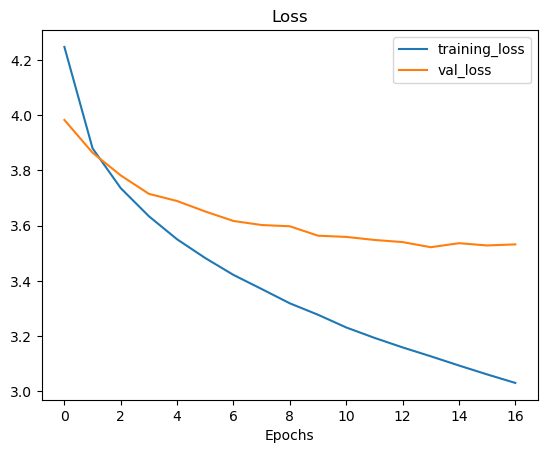

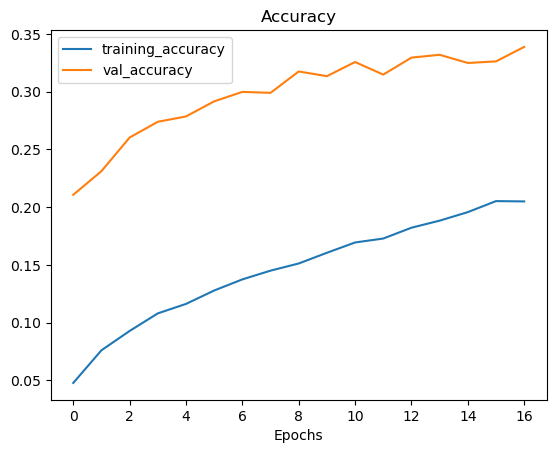

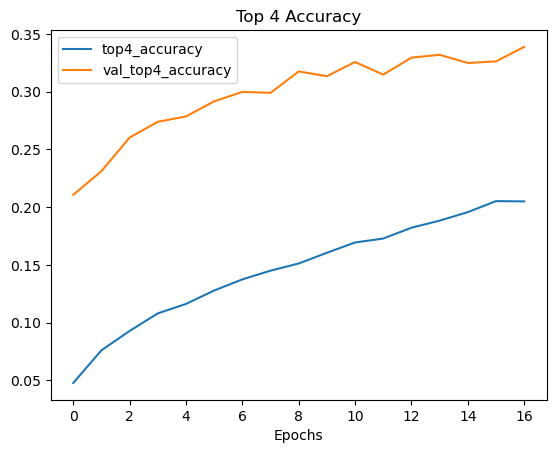

In [26]:
densenet_1_history_mood = densenet(densenet_1_config)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920   18321984  
                             )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 1920)              0         
 oling2D)                                                        
                                                                 
 dense (Dense)               (None, 59)                113339    
                                                                 
 activation (Activation)     (None, 59)                0         
                                                                 
Total params: 18435323 (70.33 MB)
Trainable params: 18206267 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 471s 1s/step - loss: 3.6928 - accuracy: 0.0815 - top_2_accuracy: 0.1706 - top_3_accuracy: 0.2295 - top_4_accuracy: 0.2792 - ROC-AUC: 0.7544 - PR-AUC: 0.0666 - tp: 138.0000 - fp: 239.0000 - tn: 858915.0000 - fn: 14675.0000 - precision: 0.3660 - recall: 0.0093 - f1_score: 0.0460 - val_loss: 3.6335 - val_accuracy: 0.0918 - val_top_2_accuracy: 0.1732 - val_top_3_accuracy: 0.2311 - val_top_4_accuracy: 0.2772 - val_ROC-AUC: 0.7559 - val_PR-AUC: 0.0628 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3673.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0149 - lr: 1.0000e-04
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.5369 - accuracy: 0.1085 - top_2_accuracy: 0.1810 - top_3_accuracy: 0.2410 - top_4_accuracy: 0.2967 - ROC-AUC: 0.7774 - PR-AUC: 0.0702 - tp: 3.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11111.0000 - precision: 1.0000 - recall: 2.6993e-04 - f1_score: 0.028

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 399s 1s/step - loss: 3.5369 - accuracy: 0.1085 - top_2_accuracy: 0.1810 - top_3_accuracy: 0.2410 - top_4_accuracy: 0.2967 - ROC-AUC: 0.7774 - PR-AUC: 0.0702 - tp: 3.0000 - fp: 0.0000e+00 - tn: 644612.0000 - fn: 11111.0000 - precision: 1.0000 - recall: 2.6993e-04 - f1_score: 0.0288 - val_loss: 3.4982 - val_accuracy: 0.1154 - val_top_2_accuracy: 0.1979 - val_top_3_accuracy: 0.2725 - val_top_4_accuracy: 0.3245 - val_ROC-AUC: 0.7840 - val_PR-AUC: 0.0767 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 213032.0000 - val_fn: 3672.0000 - val_precision: 0.3333 - val_recall: 2.7226e-04 - val_f1_score: 0.0316 - lr: 1.0000e-04
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.4378 - accuracy: 0.1334 - top_2_accuracy: 0.2121 - top_3_accuracy: 0.2752 - top_4_accuracy: 0.3334 - ROC-AUC: 0.7970 - PR-AUC: 0.0856 - tp: 28.0000 - fp: 20.0000 - tn: 644592.0000 - fn: 11086.0000 - precision: 0.5833 - recall: 0.0025 - f1_score: 0.0442INFO:tensorfl

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 393s 1s/step - loss: 3.4378 - accuracy: 0.1334 - top_2_accuracy: 0.2121 - top_3_accuracy: 0.2752 - top_4_accuracy: 0.3334 - ROC-AUC: 0.7970 - PR-AUC: 0.0856 - tp: 28.0000 - fp: 20.0000 - tn: 644592.0000 - fn: 11086.0000 - precision: 0.5833 - recall: 0.0025 - f1_score: 0.0442 - val_loss: 3.4650 - val_accuracy: 0.1337 - val_top_2_accuracy: 0.2056 - val_top_3_accuracy: 0.2731 - val_top_4_accuracy: 0.3251 - val_ROC-AUC: 0.7907 - val_PR-AUC: 0.0859 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 213034.0000 - val_fn: 3672.0000 - val_precision: 1.0000 - val_recall: 2.7226e-04 - val_f1_score: 0.0406 - lr: 1.0000e-04
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.3546 - accuracy: 0.1439 - top_2_accuracy: 0.2367 - top_3_accuracy: 0.3031 - top_4_accuracy: 0.3626 - ROC-AUC: 0.8107 - PR-AUC: 0.1004 - tp: 57.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11057.0000 - precision: 0.5588 - recall: 0.0051 - f1_score: 0.0581INFO:tensorflow

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 407s 1s/step - loss: 3.3546 - accuracy: 0.1439 - top_2_accuracy: 0.2367 - top_3_accuracy: 0.3031 - top_4_accuracy: 0.3626 - ROC-AUC: 0.8107 - PR-AUC: 0.1004 - tp: 57.0000 - fp: 45.0000 - tn: 644567.0000 - fn: 11057.0000 - precision: 0.5588 - recall: 0.0051 - f1_score: 0.0581 - val_loss: 3.3673 - val_accuracy: 0.1380 - val_top_2_accuracy: 0.2292 - val_top_3_accuracy: 0.2984 - val_top_4_accuracy: 0.3637 - val_ROC-AUC: 0.8084 - val_PR-AUC: 0.1020 - val_tp: 46.0000 - val_fp: 30.0000 - val_tn: 213004.0000 - val_fn: 3627.0000 - val_precision: 0.6053 - val_recall: 0.0125 - val_f1_score: 0.0497 - lr: 1.0000e-04
Epoch 5/100
348/348 [==============================] - 385s 1s/step - loss: 3.2572 - accuracy: 0.1648 - top_2_accuracy: 0.2644 - top_3_accuracy: 0.3393 - top_4_accuracy: 0.3966 - ROC-AUC: 0.8255 - PR-AUC: 0.1185 - tp: 103.0000 - fp: 68.0000 - tn: 644544.0000 - fn: 11011.0000 - precision: 0.6023 - recall: 0.0093 - f1_score: 0.0737 - val_loss: 3.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 402s 1s/step - loss: 3.1713 - accuracy: 0.1873 - top_2_accuracy: 0.2927 - top_3_accuracy: 0.3665 - top_4_accuracy: 0.4234 - ROC-AUC: 0.8365 - PR-AUC: 0.1407 - tp: 160.0000 - fp: 88.0000 - tn: 644524.0000 - fn: 10954.0000 - precision: 0.6452 - recall: 0.0144 - f1_score: 0.0938 - val_loss: 3.3336 - val_accuracy: 0.1568 - val_top_2_accuracy: 0.2439 - val_top_3_accuracy: 0.3087 - val_top_4_accuracy: 0.3648 - val_ROC-AUC: 0.8103 - val_PR-AUC: 0.1171 - val_tp: 57.0000 - val_fp: 45.0000 - val_tn: 212989.0000 - val_fn: 3616.0000 - val_precision: 0.5588 - val_recall: 0.0155 - val_f1_score: 0.0635 - lr: 1.0000e-04
Epoch 7/100
348/348 [==============================] - ETA: 0s - loss: 3.0531 - accuracy: 0.2098 - top_2_accuracy: 0.3200 - top_3_accuracy: 0.3981 - top_4_accuracy: 0.4631 - ROC-AUC: 0.8529 - PR-AUC: 0.1665 - tp: 252.0000 - fp: 127.0000 - tn: 644485.0000 - fn: 10862.0000 - precision: 0.6649 - recall: 0.0227 - f1_score: 0.1151INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 401s 1s/step - loss: 3.0531 - accuracy: 0.2098 - top_2_accuracy: 0.3200 - top_3_accuracy: 0.3981 - top_4_accuracy: 0.4631 - ROC-AUC: 0.8529 - PR-AUC: 0.1665 - tp: 252.0000 - fp: 127.0000 - tn: 644485.0000 - fn: 10862.0000 - precision: 0.6649 - recall: 0.0227 - f1_score: 0.1151 - val_loss: 3.2986 - val_accuracy: 0.1742 - val_top_2_accuracy: 0.2682 - val_top_3_accuracy: 0.3406 - val_top_4_accuracy: 0.3948 - val_ROC-AUC: 0.8160 - val_PR-AUC: 0.1253 - val_tp: 73.0000 - val_fp: 52.0000 - val_tn: 212982.0000 - val_fn: 3600.0000 - val_precision: 0.5840 - val_recall: 0.0199 - val_f1_score: 0.0774 - lr: 1.0000e-04
Epoch 8/100
348/348 [==============================] - 358s 1s/step - loss: 2.9098 - accuracy: 0.2399 - top_2_accuracy: 0.3615 - top_3_accuracy: 0.4430 - top_4_accuracy: 0.5053 - ROC-AUC: 0.8691 - PR-AUC: 0.2034 - tp: 439.0000 - fp: 197.0000 - tn: 644415.0000 - fn: 10675.0000 - precision: 0.6903 - recall: 0.0395 - f1_score: 0.1479 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_1_TL2_FT/assets


115/115 [==============================] - 33s 281ms/step - loss: 3.4250 - accuracy: 0.1884 - top_2_accuracy: 0.2973 - top_3_accuracy: 0.3667 - top_4_accuracy: 0.4209 - ROC-AUC: 0.8059 - PR-AUC: 0.1460 - tp: 240.0000 - fp: 292.0000 - tn: 212742.0000 - fn: 3433.0000 - precision: 0.4511 - recall: 0.0653 - f1_score: 0.1194
VALID:
 [3.425022602081299, 0.18840184807777405, 0.2973046600818634, 0.3667301833629608, 0.4209093451499939, 0.8058983087539673, 0.14598456025123596, 240.0, 292.0, 212742.0, 3433.0, 0.451127827167511, 0.06534168124198914, 0.11942549794912338]
116/116 [==============================] - 39s 334ms/step - loss: 3.4131 - accuracy: 0.1938 - top_2_accuracy: 0.2968 - top_3_accuracy: 0.3647 - top_4_accuracy: 0.4255 - ROC-AUC: 0.8067 - PR-AUC: 0.1473 - tp: 257.0000 - fp: 319.0000 - tn: 214223.0000 - fn: 3442.0000 - precision: 0.4462 - recall: 0.0695 - f1_score: 0.1161
TEST:
 [3.413125991821289, 0.19383616745471954, 0.2968369722366333, 0.36469316482543945, 0.4255204200744629, 0.80

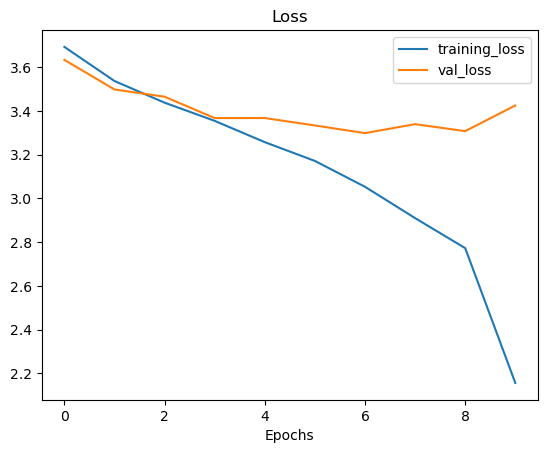

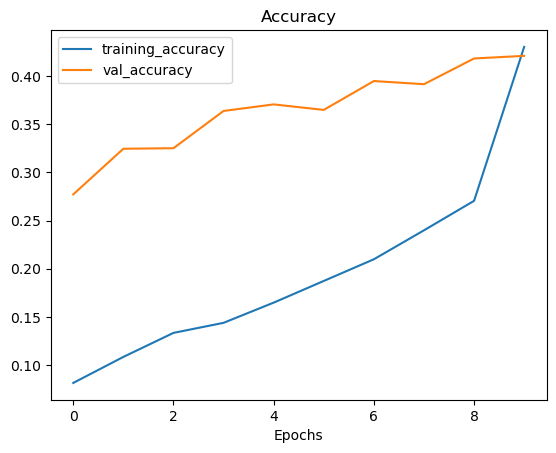

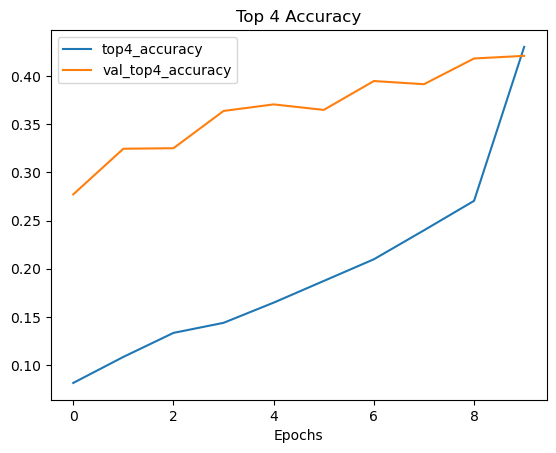

In [29]:
densenet_1_history_mood_ft = fine_tune(densenet_1_config)

### Mood | Densenet201 | Learning from stratch

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_7[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, None, None, 160)      640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, None, None, 160)      0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, None, None, 128)      20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, None, None, 128)      512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, None, None, 160)      0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, None, None, 288)      0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, None, None, 256)      0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, None, None, 256)      1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, None, None, 128)      32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, None, None, 384)      0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, None, None, 384)      1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, None, None, 384)      0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, None, None, 512)      0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, None, None, 512)      2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, None, None, 512)      0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, None, None, 640)      0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, None, None, 640)      2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, None, None, 640)      0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, None, None, 768)      0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, None, None, 768)      3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, None, None, 896)      0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, None, None, 896)      3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, None, None, 1024)     0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, None, None, 1024)     4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, None, None, 1152)     0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, None, None, 1280)     0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, None, None, 1408)     0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, None, None, 128)      225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, None, None, 992)      0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, None, None, 992)      3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, None, None, 992)      0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, None, None, 32)       36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, None, None, 1120)     0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, None, None, 1120)     4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, None, None, 1120)     0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, None, None, 1248)     0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, None, None, 1248)     4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, None, None, 1376)     0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, None, None, 1376)     5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, None, None, 1504)     0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, None, None, 1504)     6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, None, None, 1632)     0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, None, None, 1760)     0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, None, None, 128)      512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, None, None, 1888)     0         ['conv5_block30_concat[0][0]',
 atenate) 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 597s 2s/step - loss: 4.0346 - accuracy: 0.0792 - top_2_accuracy: 0.1360 - top_3_accuracy: 0.1867 - top_4_accuracy: 0.2320 - ROC-AUC: 0.7014 - PR-AUC: 0.0448 - tp: 55.0000 - fp: 461.0000 - tn: 858693.0000 - fn: 14758.0000 - precision: 0.1066 - recall: 0.0037 - f1_score: 0.0357 - val_loss: 3.7319 - val_accuracy: 0.1007 - val_top_2_accuracy: 0.1674 - val_top_3_accuracy: 0.2254 - val_top_4_accuracy: 0.2747 - val_ROC-AUC: 0.7524 - val_PR-AUC: 0.0588 - val_tp: 6.0000 - val_fp: 29.0000 - val_tn: 213005.0000 - val_fn: 3667.0000 - val_precision: 0.1714 - val_recall: 0.0016 - val_f1_score: 0.0410
Epoch 2/100
348/348 [==============================] - ETA: 0s - loss: 3.6365 - accuracy: 0.1145 - top_2_accuracy: 0.1909 - top_3_accuracy: 0.2545 - top_4_accuracy: 0.3084 - ROC-AUC: 0.7625 - PR-AUC: 0.0698 - tp: 56.0000 - fp: 144.0000 - tn: 644468.0000 - fn: 11058.0000 - precision: 0.2800 - recall: 0.0050 - f1_score: 0.0567INFO:tensorflow:Assets written to: /V

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 498s 1s/step - loss: 3.6365 - accuracy: 0.1145 - top_2_accuracy: 0.1909 - top_3_accuracy: 0.2545 - top_4_accuracy: 0.3084 - ROC-AUC: 0.7625 - PR-AUC: 0.0698 - tp: 56.0000 - fp: 144.0000 - tn: 644468.0000 - fn: 11058.0000 - precision: 0.2800 - recall: 0.0050 - f1_score: 0.0567 - val_loss: 3.6363 - val_accuracy: 0.1149 - val_top_2_accuracy: 0.1835 - val_top_3_accuracy: 0.2420 - val_top_4_accuracy: 0.2951 - val_ROC-AUC: 0.7615 - val_PR-AUC: 0.0717 - val_tp: 13.0000 - val_fp: 14.0000 - val_tn: 213020.0000 - val_fn: 3660.0000 - val_precision: 0.4815 - val_recall: 0.0035 - val_f1_score: 0.0487
Epoch 3/100
348/348 [==============================] - ETA: 0s - loss: 3.4446 - accuracy: 0.1467 - top_2_accuracy: 0.2327 - top_3_accuracy: 0.2980 - top_4_accuracy: 0.3523 - ROC-AUC: 0.7946 - PR-AUC: 0.0971 - tp: 130.0000 - fp: 117.0000 - tn: 644495.0000 - fn: 10984.0000 - precision: 0.5263 - recall: 0.0117 - f1_score: 0.0809INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 495s 1s/step - loss: 3.4446 - accuracy: 0.1467 - top_2_accuracy: 0.2327 - top_3_accuracy: 0.2980 - top_4_accuracy: 0.3523 - ROC-AUC: 0.7946 - PR-AUC: 0.0971 - tp: 130.0000 - fp: 117.0000 - tn: 644495.0000 - fn: 10984.0000 - precision: 0.5263 - recall: 0.0117 - f1_score: 0.0809 - val_loss: 3.6029 - val_accuracy: 0.1143 - val_top_2_accuracy: 0.2034 - val_top_3_accuracy: 0.2663 - val_top_4_accuracy: 0.3226 - val_ROC-AUC: 0.7728 - val_PR-AUC: 0.0739 - val_tp: 21.0000 - val_fp: 65.0000 - val_tn: 212969.0000 - val_fn: 3652.0000 - val_precision: 0.2442 - val_recall: 0.0057 - val_f1_score: 0.0582
Epoch 4/100
348/348 [==============================] - ETA: 0s - loss: 3.2217 - accuracy: 0.1844 - top_2_accuracy: 0.2875 - top_3_accuracy: 0.3673 - top_4_accuracy: 0.4203 - ROC-AUC: 0.8265 - PR-AUC: 0.1382 - tp: 219.0000 - fp: 161.0000 - tn: 644451.0000 - fn: 10895.0000 - precision: 0.5763 - recall: 0.0197 - f1_score: 0.1072INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 484s 1s/step - loss: 3.2217 - accuracy: 0.1844 - top_2_accuracy: 0.2875 - top_3_accuracy: 0.3673 - top_4_accuracy: 0.4203 - ROC-AUC: 0.8265 - PR-AUC: 0.1382 - tp: 219.0000 - fp: 161.0000 - tn: 644451.0000 - fn: 10895.0000 - precision: 0.5763 - recall: 0.0197 - f1_score: 0.1072 - val_loss: 3.5073 - val_accuracy: 0.1440 - val_top_2_accuracy: 0.2301 - val_top_3_accuracy: 0.2929 - val_top_4_accuracy: 0.3422 - val_ROC-AUC: 0.7866 - val_PR-AUC: 0.0949 - val_tp: 38.0000 - val_fp: 63.0000 - val_tn: 212971.0000 - val_fn: 3635.0000 - val_precision: 0.3762 - val_recall: 0.0103 - val_f1_score: 0.0751
Epoch 5/100
348/348 [==============================] - ETA: 0s - loss: 3.0277 - accuracy: 0.2195 - top_2_accuracy: 0.3335 - top_3_accuracy: 0.4125 - top_4_accuracy: 0.4737 - ROC-AUC: 0.8535 - PR-AUC: 0.1780 - tp: 370.0000 - fp: 201.0000 - tn: 644411.0000 - fn: 10744.0000 - precision: 0.6480 - recall: 0.0333 - f1_score: 0.1348INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2_checkpoints/cp.ckpt/assets


348/348 [==============================] - 495s 1s/step - loss: 3.0277 - accuracy: 0.2195 - top_2_accuracy: 0.3335 - top_3_accuracy: 0.4125 - top_4_accuracy: 0.4737 - ROC-AUC: 0.8535 - PR-AUC: 0.1780 - tp: 370.0000 - fp: 201.0000 - tn: 644411.0000 - fn: 10744.0000 - precision: 0.6480 - recall: 0.0333 - f1_score: 0.1348 - val_loss: 3.4494 - val_accuracy: 0.1476 - val_top_2_accuracy: 0.2344 - val_top_3_accuracy: 0.3074 - val_top_4_accuracy: 0.3616 - val_ROC-AUC: 0.7954 - val_PR-AUC: 0.1052 - val_tp: 53.0000 - val_fp: 52.0000 - val_tn: 212982.0000 - val_fn: 3620.0000 - val_precision: 0.5048 - val_recall: 0.0144 - val_f1_score: 0.0830
Epoch 6/100
348/348 [==============================] - 446s 1s/step - loss: 2.8100 - accuracy: 0.2706 - top_2_accuracy: 0.3909 - top_3_accuracy: 0.4684 - top_4_accuracy: 0.5305 - ROC-AUC: 0.8797 - PR-AUC: 0.2346 - tp: 581.0000 - fp: 231.0000 - tn: 644381.0000 - fn: 10533.0000 - precision: 0.7155 - recall: 0.0523 - f1_score: 0.1788 - val_loss: 3.4678 - val_acc

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_mood/densenet201_2/assets


115/115 [==============================] - 44s 380ms/step - loss: 3.5097 - accuracy: 0.1625 - top_2_accuracy: 0.2491 - top_3_accuracy: 0.3147 - top_4_accuracy: 0.3635 - ROC-AUC: 0.7887 - PR-AUC: 0.1160 - tp: 113.0000 - fp: 142.0000 - tn: 212892.0000 - fn: 3560.0000 - precision: 0.4431 - recall: 0.0308 - f1_score: 0.0974
VALID:
 [3.509665012359619, 0.16253744065761566, 0.24911516904830933, 0.31472909450531006, 0.3634631037712097, 0.7886936664581299, 0.11597944796085358, 113.0, 142.0, 212892.0, 3560.0, 0.4431372582912445, 0.030765041708946228, 0.0974251851439476]
116/116 [==============================] - 61s 528ms/step - loss: 4.2561 - accuracy: 0.0703 - top_2_accuracy: 0.1295 - top_3_accuracy: 0.1782 - top_4_accuracy: 0.2149 - ROC-AUC: 0.6856 - PR-AUC: 0.0408 - tp: 15.0000 - fp: 122.0000 - tn: 214420.0000 - fn: 3684.0000 - precision: 0.1095 - recall: 0.0041 - f1_score: 0.0457
TEST:
 [4.2560811042785645, 0.07028926908969879, 0.12949445843696594, 0.17815625667572021, 0.2149229496717453, 

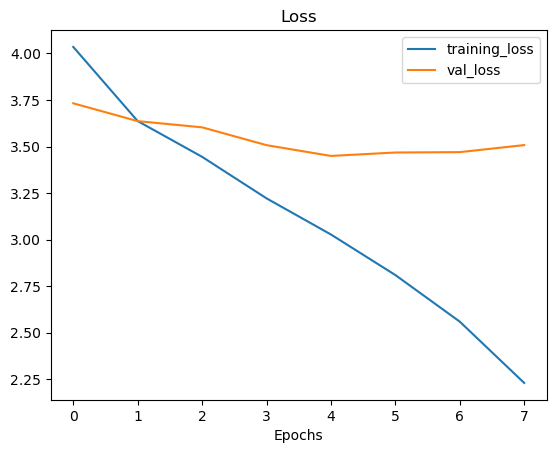

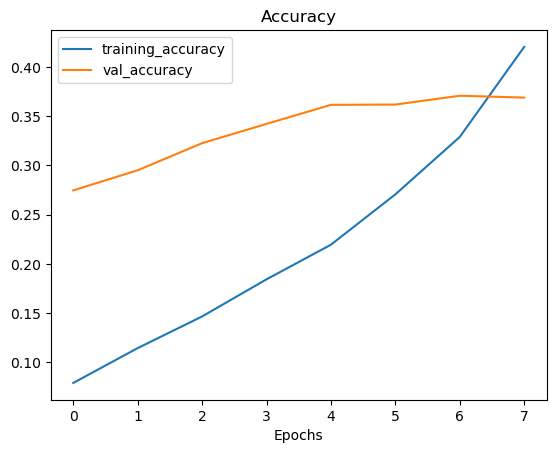

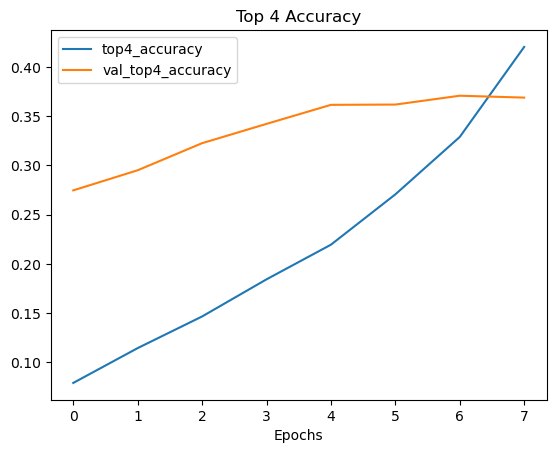

In [35]:
densenet_2_history_mood = densenet(densenet_2_config)

Reading: 18486 tracks, 4506 albums, 1533 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_mood/test/deep/1420460.png
1/1 [==============================] - 9s 9s/step
Track info:
 {'artist_id': 490851, 'album_id': 165678, 'path': '60/1420460.mp3', 'duration': 211.0, 'tags': ['mood/theme---deep'], 'genre': set(), 'instrument': set(), 'mood/theme': {'deep'}}


,class_name,prob
31,deep,0.436960
39,summer,0.221111
36,happy,0.118283
35,funny,0.036395


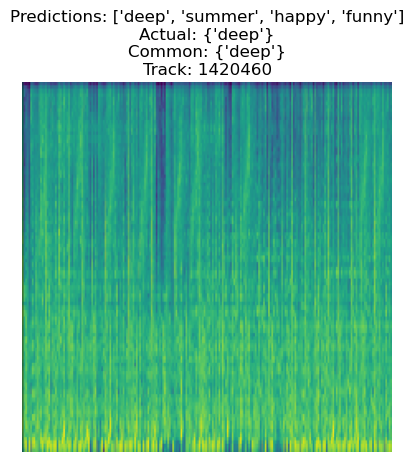

In [88]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_mood', 
                                                               'densenet201_1_TL_FT')),
                       'mood'
                      )

Reading: 18486 tracks, 4506 albums, 1533 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_mood/test/dream/447149.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 342481, 'album_id': 53751, 'path': '49/447149.mp3', 'duration': 219.5, 'tags': ['mood/theme---dream'], 'genre': set(), 'instrument': set(), 'mood/theme': {'dream'}}


,class_name,prob
27,inspiring,0.111280
40,dream,0.089813
22,epic,0.071405
4,melodic,0.067766


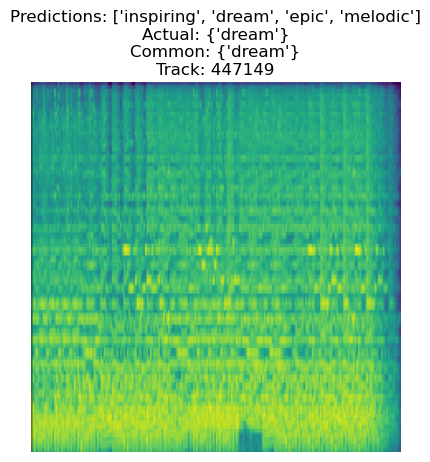

In [9]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_mood', 
                                                               'densenet201_1_TL_FT')),
                       'mood'
                      )

Reading: 18486 tracks, 4506 albums, 1533 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_mood/test/space/117552.png
1/1 [==============================] - 3s 3s/step
Track info:
 {'artist_id': 3769, 'album_id': 15781, 'path': '52/117552.mp3', 'duration': 160.0, 'tags': ['mood/theme---space'], 'genre': set(), 'instrument': set(), 'mood/theme': {'space'}}


,class_name,prob
1,film,0.313866
9,documentary,0.121085
51,movie,0.094523
21,advertising,0.051094


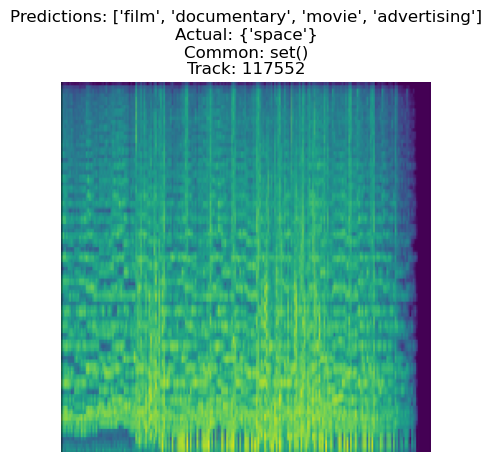

In [10]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_mood', 
                                                               'densenet201_1_TL_FT')),
                       'mood'
                      )

Reading: 18486 tracks, 4506 albums, 1533 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_mood/test/action/1262122.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 466600, 'album_id': 150899, 'path': '22/1262122.mp3', 'duration': 109.1, 'tags': ['mood/theme---action', 'mood/theme---dramatic', 'mood/theme---epic', 'mood/theme---powerful', 'mood/theme---trailer'], 'genre': set(), 'instrument': set(), 'mood/theme': {'action', 'trailer', 'dramatic', 'powerful', 'epic'}}


,class_name,prob
22,epic,0.253149
58,trailer,0.149967
23,action,0.135345
27,inspiring,0.134573


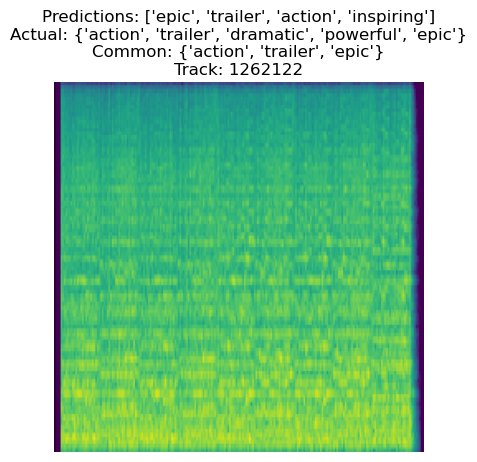

In [11]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_mood', 
                                                               'densenet201_1_TL_FT')),
                       'mood'
                      )

In [ ]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_mood', 
                                                               'densenet201_1_TL_FT')),
                       'mood'
                      )